In [1]:
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, ZZ, RX
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer,MQLayer,MQAnsatzOnlyOps
from mindquantum.simulator import Simulator
from mindspore.common.initializer import Normal,initializer
from mindspore import Tensor,ops
from mindspore import dtype as mstype
from mindspore.common.parameter import Parameter
from mindspore.nn import Adam, TrainOneStepCell                   # 导入Adam模块和TrainOneStepCell模块

import networkx as nx
import mindspore.nn as nn
import mindspore as ms


# 加载额外需要用到的包
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import time


import warnings
warnings.filterwarnings("ignore")

# 将数据保存在服务器上所需代码
import logging
import sys
import datetime
 
def init_logger(filename, logger_name):
    '''
    @brief:
        initialize logger that redirect info to a file just in case we lost connection to the notebook
    @params:
        filename: to which file should we log all the info
        logger_name: an alias to the logger
    '''
 
    # get current timestamp
    timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
    
    logging.basicConfig(
        level=logging.INFO, 
        format='%(message)s',
#         format='%(message)s',
        handlers=[
            logging.FileHandler(filename=filename),
            logging.StreamHandler(sys.stdout)
        ]
    )
 
    # Test
    logger = logging.getLogger(logger_name)
   #logger.info('### Init. Logger {} ###'.format(logger_name))
    return logger


# Initialize
my_logger = init_logger("data/greedy/n = 12(figure8,delta_F)).log", "ml_logger")


In [2]:
# n 是图 G 的顶点数，同时也是量子比特的个数
# 选择n个顶点的3正则图
n = 12
g = nx.Graph()
V = range(n)
g.add_nodes_from(V)

# 对应论文中Figure8中n = 8
# E = [(2, 7), (2, 1), (2, 3), (7, 4), (7, 5), (1, 0), (1, 4), (4, 0), (0, 6), (5, 6), (5, 3), (6, 3)] # random2


# 对应论文中Figure8中n = 10
# E = [(1, 2), (1, 0), (1, 5), (2, 8), (2, 3), (0, 4), (0, 3), (6, 9), (6, 7), (6, 8), (9, 8), (9, 7), (7, 5), (4, 5), (4, 3)]

# 10顶点3正则图，对应论文中Table
# E = [(0, 5), (0, 6), (0, 7), (1, 2), (1, 8), (1, 9), (2, 3), (2, 5), (3, 8), (3, 9), (4, 7), (4, 8), (4, 9), (5, 6), (6, 7)]



# 对应Figure8中n=12
E = [(1, 2), (1, 5), (1, 7), (2, 3), (2, 4), (5, 9), (5, 7), (9, 4), (9, 0), (4, 8), (8, 11), (8, 3), (6, 11), (6, 10), (6, 0), (11, 0), (3, 10), (10, 7)]


In [ ]:
# 8顶点3正则图
# E = [(0,1),(0,3),(0,5),(1,2),(1,6),(2,3),(2,7),(3,4),(4,5),(4,7),(5,6),(6,7)] # 8顶点3正则图1
# E = [(0, 7), (0, 4), (0, 5), (7, 3), (7, 4), (1, 2), (1, 4), (1, 6), (2, 3), (2, 6), (3, 5), (6, 5)] #8顶点3正则图2
# E = [(0, 4), (0, 3), (0, 2), (4, 6), (4, 5), (2, 7), (2, 6), (7, 6), (7, 1), (1, 5), (1, 3), (5, 3)] # 8顶点3正则图3
# E = [(0, 1), (0, 6), (0, 5), (1, 4), (1, 3), (2, 4), (2, 7), (2, 6), (4, 6), (7, 3), (7, 5), (3, 5)] #图4
# E = [(0, 1), (0, 4), (0, 2), (1, 2), (1, 6), (2, 5), (4, 3), (4, 7), (3, 6), (3, 5), (5, 7), (7, 6)]  # 图5
# E = [(0, 1), (0, 7), (0, 5), (1, 4), (1, 6), (7, 3), (7, 5), (2, 4), (2, 3), (2, 6), (4, 5), (3, 6)]  #图6
# E = [(1, 2), (1, 4), (1, 7), (2, 7), (2, 5), (7, 3), (3, 0), (3, 6), (0, 6), (0, 5), (4, 6), (4, 5)] # 图7
# E = [(2, 4), (2, 1), (2, 3), (4, 0), (4, 7), (1, 5), (1, 7), (0, 6), (0, 5), (5, 6), (3, 7), (3, 6)] # 图8
# E = [(0, 1), (0, 3), (0, 6), (1, 4), (1, 6), (2, 7), (2, 3), (2, 5), (7, 5), (7, 4), (3, 6), (5, 4)] # 图9
# E = [(1, 2), (1, 6), (1, 3), (2, 7), (2, 5), (0, 4), (0, 3), (0, 6), (4, 6), (4, 5), (7, 3), (7, 5)] #图10


# E = [(0, 7), (0, 4), (0, 6), (7, 3), (7, 5), (2, 4), (2, 3), (2, 5), (4, 1), (1, 5), (1, 6), (3, 6)] # 图11
# E = [(0, 1), (0, 2), (0, 5), (1, 2), (1, 7), (2, 6), (3, 4), (3, 7), (3, 6), (4, 6), (4, 5), (7, 5)] # 图12
# E = [(0, 1), (0, 6), (0, 2), (1, 4), (1, 3), (2, 7), (2, 6), (7, 3), (7, 5), (3, 5), (4, 6), (4, 5)] # 图13
# E = [(0, 7), (0, 6), (0, 5), (7, 2), (7, 4), (1, 2), (1, 4), (1, 6), (2, 3), (3, 4), (3, 5), (6, 5)] # 图14
# E = [(1, 2), (1, 6), (1, 3), (2, 7), (2, 0), (0, 4), (0, 5), (4, 3), (4, 5), (3, 7), (7, 6), (6, 5)] # 图15
# E = [(0, 7), (0, 4), (0, 6), (7, 2), (7, 5), (1, 2), (1, 6), (1, 3), (2, 3), (4, 3), (4, 5), (5, 6)] # 图16
# E = [(0, 1), (0, 7), (0, 6), (1, 4), (1, 7), (7, 3), (3, 2), (3, 5), (4, 6), (4, 5), (6, 2), (2, 5)] # 图17
# E = [(0, 7), (0, 4), (0, 3), (7, 5), (7, 6), (2, 4), (2, 1), (2, 5), (4, 6), (1, 5), (1, 3), (3, 6)] # 图18
# E = [(0, 1), (0, 3), (0, 2), (1, 5), (1, 7), (2, 4), (2, 6), (4, 3), (4, 6), (3, 7), (5, 7), (5, 6)] # 图19
# E = [(1, 2), (1, 4), (1, 6), (2, 0), (2, 5), (3, 4), (3, 7), (3, 0), (4, 5), (7, 5), (7, 6), (0, 6)] # 图20


# E = [(0, 7), (0, 3), (0, 5), (7, 6), (7, 4), (1, 2), (1, 4), (1, 6), (2, 3), (2, 5), (3, 4), (6, 5)] # 图21
# E = [(0, 1), (0, 4), (0, 5), (1, 4), (1, 7), (4, 5), (3, 7), (3, 2), (3, 6), (7, 6), (2, 6), (2, 5)] # 图22
# E = [(0, 1), (0, 7), (0, 3), (1, 7), (1, 6), (7, 5), (2, 4), (2, 3), (2, 5), (4, 6), (4, 5), (3, 6)] # 图23
# E = [(0, 7), (0, 3), (0, 6), (7, 1), (7, 4), (2, 4), (2, 1), (2, 3), (4, 6), (1, 5), (5, 6), (5, 3)] # 图24
# E = [(0, 1), (0, 4), (0, 3), (1, 2), (1, 4), (2, 4), (2, 7), (7, 5), (7, 6), (3, 6), (3, 5), (5, 6)] # 图25
# E = [(0, 1), (0, 4), (0, 6), (1, 7), (1, 6), (4, 5), (4, 7), (3, 7), (3, 2), (3, 5), (6, 2), (2, 5)] # 图26


In [ ]:
# 10顶点3正则图
# E =[(0,2),(0,5),(0,9),(1,3),(1,5),(1,8),(2,9),(2,4),(3,4),(3,6),(4,9),(5,7),(6,7),(6,8),(7,8)]  # 10顶点正则图1
# E = [(0,5),(0,6),(0,7),(1,2),(1,8),(1,9),(2,3),(2,5),(3,8),(3,9),(4,7),(4,8),(4,9),(5,6),(6,7)]   # 10顶点正则图2
# E = [(0,2),(0,8),(0,9),(1,4),(1,5),(1,7),(2,5),(2,8),(3,4),(3,6),(3,7),(4,9),(5,7),(6,8),(6,9)]  # 10 顶点正则图3
# E = [(0,3),(0,6),(0,9),(1,4),(1,7),(1,8),(2,5),(2,6),(2,8),(3,4),(3,7),(4,9),(5,6),(5,8),(7,9)]   # 10顶点正则图4
# E = [(0,2),(0,5),(0,7),(1,3),(1,4),(1,6),(2,5),(2,7),(3,8),(3,9),(4,8),(4,9),(5,7),(6,8),(6,9)]  # 3正则图5
# E = [(0,1),(0,6),(0,2),(1,2),(1,7),(2,5),(3,6),(3,8),(3,4),(4,7),(4,9),(5,7),(5,9),(6,8),(6,9)]  # 3正则图6
# E = [(2, 7), (2, 8), (2, 4), (7, 0), (7, 1), (5, 9), (5, 0), (5, 3), (9, 6), (9, 8), (6, 0), (6, 3), (8, 1), (1, 4), (4, 3)]#3正则图7
# E = [(0, 1), (0, 4), (0, 3), (1, 3), (1, 5), (7, 8), (7, 6), (7, 9), (8, 6), (8, 5), (2, 6), (2, 9), (2, 5), (4, 9), (4, 3)] # 3正则图8
# E = [(0, 1), (0, 3), (0, 5), (1, 5), (1, 7), (2, 4), (2, 9), (2, 8), (4, 9), (4, 6), (5, 3), (9, 8), (6, 7), (6, 3), (7, 8)] # 3正则图9
# E = [(0, 7), (0, 3), (0, 6), (7, 9), (7, 8), (2, 4), (2, 1), (2, 8), (4, 9), (4, 5), (1, 5), (1, 6), (5, 3), (9, 8), (3, 6)] # 3正则图10


# E = [(3, 8), (3, 7), (3, 1), (8, 9), (8, 2), (0, 4), (0, 6), (0, 5), (4, 6), (4, 7), (2, 7), (2, 9), (1, 5), (1, 6), (5, 9)] #图11
# E = [(0, 1), (0, 4), (0, 8), (1, 4), (1, 6), (4, 8), (2, 7), (2, 6), (2, 8), (7, 3), (7, 5), (3, 9), (3, 5), (5, 9), (9, 6)] # 图12
# E = [(0, 1), (0, 9), (0, 8), (1, 2), (1, 7), (2, 3), (2, 6), (3, 4), (3, 6), (4, 8), (4, 7), (5, 8), (5, 7), (5, 9), (9, 6)] # 图13
# E = [(0, 1), (0, 4), (0, 6), (1, 5), (1, 9), (3, 8), (3, 7), (3, 5), (8, 9), (8, 2), (2, 4), (2, 5), (4, 6), (7, 9), (7, 6)] # 图14
# E = [(0, 1), (0, 9), (0, 5), (1, 4), (1, 9), (3, 8), (3, 7), (3, 5), (8, 9), (8, 4), (2, 7), (2, 6), (2, 5), (7, 6), (4, 6)] # 图15
# E = [(1, 2), (1, 7), (1, 3), (2, 3), (2, 8), (0, 4), (0, 9), (0, 8), (4, 9), (4, 6), (9, 5), (3, 7), (7, 5), (6, 8), (6, 5)] # 图16
# E = [(0, 1), (0, 2), (0, 8), (1, 6), (1, 7), (3, 4), (3, 2), (3, 5), (4, 6), (4, 8), (6, 7), (5, 7), (5, 9), (2, 9), (9, 8)] # 图17
# E = [(0, 1), (0, 6), (0, 8), (1, 9), (1, 6), (3, 4), (3, 7), (3, 5), (4, 5), (4, 7), (5, 8), (8, 2), (7, 9), (9, 2), (6, 2)] # 图18
# E = [(0, 4), (0, 3), (0, 8), (4, 3), (4, 9), (3, 9), (2, 7), (2, 5), (2, 8), (7, 1), (7, 8), (1, 5), (1, 6), (5, 6), (9, 6)] # 图19
# E = [(1, 2), (1, 4), (1, 9), (2, 5), (2, 8), (3, 4), (3, 7), (3, 6), (4, 5), (7, 9), (7, 8), (6, 8), (6, 0), (0, 9), (0, 5)] # 图20


# E = [(0, 1), (0, 9), (0, 6), (1, 2), (1, 7), (3, 8), (3, 4), (3, 2), (8, 4), (8, 7), (2, 5), (4, 6), (6, 5), (9, 7), (9, 5)] #图21
# E = [(1, 3), (1, 2), (1, 8), (3, 8), (3, 5), (8, 0), (2, 7), (2, 9), (0, 4), (0, 7), (4, 6), (4, 5), (7, 6), (6, 9), (9, 5)] # 图22
# E = [(0, 1), (0, 6), (0, 5), (1, 8), (1, 9), (3, 8), (3, 4), (3, 7), (8, 2), (2, 4), (2, 6), (4, 9), (9, 5), (7, 5), (7, 6)] # 图23
# E = [(2, 4), (2, 9), (2, 0), (4, 3), (4, 5), (3, 0), (3, 1), (6, 8), (6, 0), (6, 5), (8, 1), (8, 7), (1, 9), (5, 7), (7, 9)] #图24
# E = [(0, 1), (0, 3), (0, 2), (1, 6), (1, 3), (3, 4), (4, 8), (4, 7), (7, 9), (7, 8), (9, 8), (9, 5), (2, 6), (2, 5), (6, 5)] #图25
# E = [(0, 1), (0, 7), (0, 4), (1, 8), (1, 6), (7, 9), (7, 4), (4, 3), (3, 9), (3, 6), (5, 8), (5, 6), (5, 2), (8, 2), (9, 2)] # 图26
# E = [(0, 7), (0, 9), (0, 8), (7, 2), (7, 9), (3, 4), (3, 2), (3, 9), (4, 6), (4, 8), (2, 5), (1, 5), (1, 8), (1, 6), (5, 6)] # 图27
# E = [(0, 7), (0, 3), (0, 9), (7, 9), (7, 6), (3, 8), (3, 1), (8, 4), (8, 2), (1, 5), (1, 4), (5, 6), (5, 2), (4, 9), (6, 2)] #图28
# E = [(2, 4), (2, 9), (2, 0), (4, 9), (4, 8), (1, 5), (1, 7), (1, 6), (5, 6), (5, 0), (9, 8), (3, 7), (3, 0), (3, 6), (7, 8)] # 图29
# E = [(0, 1), (0, 7), (0, 5), (1, 2), (1, 6), (7, 3), (7, 5), (3, 8), (3, 9), (8, 5), (8, 4), (2, 9), (2, 6), (4, 9), (4, 6)] #图30


In [ ]:
# 12顶点的3正则图
# E = [(0, 7), (0, 4), (0, 9), (7, 10), (7, 1), (2, 4), (2, 3), (2, 8), (4, 11), (10, 11), (10, 5), (11, 6), (6, 8), (6, 1), (8, 9), (9, 5), (3, 1), (3, 5)] # 12顶点3正则图1
# E = [(3, 8), (3, 7), (3, 1), (8, 4), (8, 0), (1, 2), (1, 9), (2, 10), (2, 11), (5, 11), (5, 6), (5, 0), (11, 4), (0, 10), (10, 7), (6, 9), (6, 4), (9, 7)]#图2
# E = [(1, 3), (1, 2), (1, 6), (3, 8), (3, 7), (8, 5), (8, 7), (2, 7), (2, 11), (10, 11), (10, 0), (10, 5), (11, 0), (0, 9), (6, 9), (6, 4), (9, 4), (4, 5)] # 图3
# E = [(3, 8), (3, 4), (3, 7), (8, 9), (8, 0), (4, 6), (4, 1), (1, 11), (1, 7), (11, 9), (11, 0), (7, 5), (2, 10), (2, 0), (2, 5), (10, 5), (10, 6), (6, 9)]#图4
# E = [(0, 1), (0, 2), (0, 5), (1, 6), (1, 9), (3, 8), (3, 10), (3, 9), (8, 6), (8, 4), (10, 11), (10, 5), (11, 7), (11, 4), (6, 2), (7, 9), (7, 4), (2, 5)] # 图5
# E = [(4, 10), (4, 9), (4, 1), (10, 7), (10, 5), (1, 2), (1, 8), (2, 3), (2, 5), (9, 7), (9, 11), (7, 11), (6, 8), (6, 0), (6, 3), (8, 11), (0, 3), (0, 5)] #图6
# E = [(9, 10), (9, 0), (9, 6), (10, 7), (10, 2), (0, 7), (0, 2), (7, 5), (3, 4), (3, 2), (3, 11), (4, 5), (4, 8), (5, 8), (8, 1), (6, 11), (6, 1), (11, 1)] # 图7
# E = [(1, 2), (1, 8), (1, 3), (2, 9), (2, 6), (0, 4), (0, 10), (0, 11), (4, 6), (4, 5), (10, 7), (10, 5), (5, 8), (8, 11), (6, 9), (9, 3), (7, 3), (7, 11)] # 图8
# E = [(0, 1), (0, 4), (0, 5), (1, 8), (1, 6), (3, 8), (3, 10), (3, 9), (8, 7), (4, 7), (4, 5), (2, 10), (2, 6), (2, 11), (10, 5), (7, 11), (6, 9), (9, 11)] #图9
# E = [(1, 3), (1, 6), (1, 7), (3, 4), (3, 10), (4, 6), (4, 7), (6, 7), (10, 8), (10, 5), (0, 9), (0, 8), (0, 11), (9, 5), (9, 11), (8, 2), (5, 2), (11, 2)] # 图10


# E = [(0, 1), (0, 10), (0, 11), (1, 4), (1, 10), (3, 4), (3, 7), (3, 6), (4, 5), (10, 5), (7, 9), (7, 6), (6, 8), (8, 11), (8, 2), (11, 9), (9, 2), (2, 5)]# 图11
# E = [(9, 10), (9, 8), (9, 5), (10, 11), (10, 6), (0, 1), (0, 4), (0, 2), (1, 7), (1, 3), (11, 5), (11, 6), (5, 6), (3, 4), (3, 2), (4, 8), (2, 7), (7, 8)] #图12
# E = [(4, 10), (4, 0), (4, 6), (10, 11), (10, 2), (3, 8), (3, 0), (3, 2), (8, 0), (8, 11), (11, 1), (1, 5), (1, 7), (5, 7), (5, 9), (2, 9), (6, 7), (6, 9)] # 图13
# E = [(2, 4), (2, 9), (2, 0), (4, 7), (4, 11), (10, 11), (10, 3), (10, 5), (11, 3), (5, 8), (5, 1), (8, 6), (8, 0), (1, 6), (1, 9), (3, 7), (7, 9), (6, 0)] #图14
# E = [(4, 10), (4, 0), (4, 8), (10, 11), (10, 2), (11, 6), (11, 1), (0, 3), (0, 5), (6, 8), (6, 1), (1, 7), (5, 8), (5, 7), (2, 3), (2, 9), (3, 9), (7, 9)] #图15
# E = [(9, 10), (9, 3), (9, 6), (10, 11), (10, 3), (2, 4), (2, 1), (2, 8), (4, 0), (4, 7), (1, 7), (1, 6), (8, 0), (8, 7), (5, 11), (5, 6), (5, 0), (11, 3)]#图16
# E = [(9, 10), (9, 4), (9, 11), (10, 4), (10, 3), (0, 7), (0, 6), (0, 2), (7, 2), (7, 1), (4, 3), (1, 2), (1, 5), (3, 8), (8, 5), (8, 11), (6, 11), (6, 5)]#图17
# E = [(1, 3), (1, 6), (1, 9), (3, 8), (3, 9), (8, 0), (8, 11), (10, 11), (10, 5), (10, 6), (11, 2), (2, 4), (2, 6), (4, 9), (4, 7), (0, 7), (0, 5), (7, 5)]#图18
# E = [(9, 10), (9, 0), (9, 1), (10, 7), (10, 8), (2, 4), (2, 3), (2, 0), (4, 7), (4, 8), (5, 11), (5, 1), (5, 3), (11, 6), (11, 0), (1, 3), (6, 8), (6, 7)]#图19
# E = [(9, 10), (9, 2), (9, 11), (10, 11), (10, 8), (0, 7), (0, 4), (0, 5), (7, 2), (7, 8), (3, 8), (3, 4), (3, 11), (1, 2), (1, 5), (1, 6), (4, 6), (5, 6)]#图20

In [ ]:
# # 16顶点3正则图
# E = [(4, 12), (4, 14), (4, 0), (12, 7), (12, 14), (3, 13), (3, 1), (3, 6), (13, 2), (13, 15), (0, 5), (0, 9), (5, 9), (5, 11), (1, 15), (1, 8), (10, 15), (10, 7), (10, 11), (7, 6), (14, 8), (6, 2), (9, 2), (8, 11)] #图1
# E = [(12, 13), (12, 1), (12, 7), (13, 0), (13, 11), (3, 10), (3, 6), (3, 11), (10, 9), (10, 14), (5, 7), (5, 0), (5, 6), (7, 15), (0, 9), (9, 14), (14, 6), (2, 8), (2, 4), (2, 15), (8, 4), (8, 11), (1, 15), (1, 4)]#图2
# E = [(4, 9), (4, 6), (4, 14), (9, 5), (9, 2), (3, 7), (3, 13), (3, 14), (7, 6), (7, 11), (6, 11), (13, 11), (13, 10), (8, 15), (8, 14), (8, 5), (15, 1), (15, 0), (2, 5), (2, 12), (1, 12), (1, 10), (12, 0), (0, 10)] #图3
# E = [(4, 6), (4, 15), (4, 2), (6, 5), (6, 0), (15, 8), (15, 1), (0, 2), (0, 3), (2, 10), (8, 9), (8, 13), (9, 13), (9, 12), (1, 3), (1, 11), (3, 14), (7, 10), (7, 11), (7, 14), (10, 13), (5, 12), (5, 14), (12, 11)] #图4
# E = [(6, 15), (6, 3), (6, 7), (15, 7), (15, 9), (4, 9), (4, 11), (4, 2), (9, 14), (12, 13), (12, 8), (12, 3), (13, 5), (13, 14), (5, 0), (5, 3), (0, 1), (0, 10), (8, 14), (8, 1), (2, 11), (2, 10), (11, 10), (1, 7)] #图5
# E = [(6, 12), (6, 1), (6, 5), (12, 15), (12, 5), (5, 13), (13, 0), (13, 11), (1, 8), (1, 14), (8, 15), (8, 4), (15, 0), (2, 14), (2, 3), (2, 9), (14, 10), (7, 10), (7, 9), (7, 4), (10, 0), (3, 9), (3, 11), (4, 11)] #图6

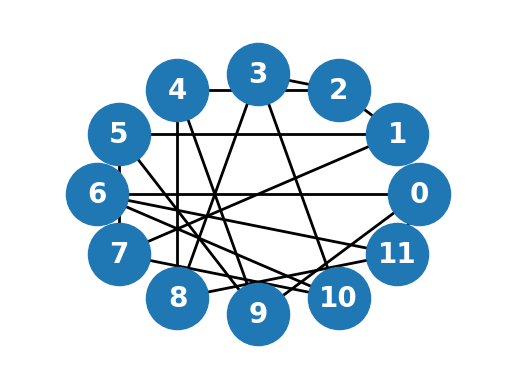

E = [(1, 2), (1, 5), (1, 7), (2, 3), (2, 4), (5, 9), (5, 7), (9, 4), (9, 0), (4, 8), (8, 11), (8, 3), (6, 11), (6, 10), (6, 0), (11, 0), (3, 10), (10, 7)]


In [3]:
g.add_edges_from(E)
# 将生成的图 G 打印出来
pos = nx.circular_layout(g)
options = {
    "with_labels": True,
    "font_size": 20,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 1000,
    "width": 2
}
nx.draw_networkx(g, pos, **options)
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

my_logger.info('E = {}'.format(E))

In [4]:
def build_hc(g, para):
    hc = Circuit()                  # 创建量子线路
    for i in g.edges:
        hc += ZZ(para).on(i)        # 对图中的每条边作用ZZ门
    hc.barrier()                    # 添加Barrier以方便展示线路
    return hc

def build_hb(g, para):
    hb = Circuit()                  # 创建量子线路
    for i in g.nodes:
        hb += RX(para).on(i)        # 对每个节点作用RX门
    hb.barrier()                    # 添加Barrier以方便展示线路
    return hb


def build_ansatz(g, p):                    # g是max-cut问题的图，p是ansatz线路的层数
    circ = Circuit()                       # 创建量子线路
    for i in range(p):
        circ += build_hc(g, f'gamma{i}')       # 添加Uc对应的线路，参数记为g0、g1、g2...
        circ += build_hb(g, f'beta{i}')       # 添加Ub对应的线路，参数记为b0、b1、b2...
    circ.as_ansatz()
    return circ

def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

ham = Hamiltonian(build_ham(g))              # 生成哈密顿量
print('ham = {}'.format(ham))

ham = 1 [Z0 Z9] +
1 [Z0 Z6] +
1 [Z0 Z11] +
1 [Z1 Z2] +
1 [Z1 Z5] +
1 [Z1 Z7] +
1 [Z2 Z3] +
1 [Z2 Z4] +
1 [Z3 Z8] +
1 [Z3 Z10] +
1 [Z4 Z9] +
1 [Z4 Z8] +
1 [Z5 Z9] +
1 [Z5 Z7] +
1 [Z6 Z11] +
1 [Z6 Z10] +
1 [Z7 Z10] +
1 [Z8 Z11] 


In [5]:
# 只有ansatz，无encoder
class MQAnsatzOnlyLayer(nn.Cell):
    def __init__(self, expectation_with_grad,params, weight='normal'):
        """Initialize a MQAnsatzOnlyLayer object."""
        super().__init__()
        self.evolution = MQAnsatzOnlyOps(expectation_with_grad)
        weight_size = len(self.evolution.expectation_with_grad.ansatz_params_name)
        if isinstance(weight, ms.Tensor):
            if weight.ndim != 1 or weight.shape[0] != weight_size:
                raise ValueError(f"Weight init shape error, required ({weight_size}, ), but get f{weight.shape}.")
        # Parameter是变量张量，代表在训练网络时，需要被更新的参数
        # initializer()是一个初始化器，调用这个接口可生成initializer对象（我输出这个对象和参数，发现两者是不同的）
#         self.weight = Parameter(initializer(weight, weight_size, dtype=ms.float32), name='ansatz_weight')
#         print(initializer(weight,weight_size,dtype=ms.float32))
        
        
        # 基于Tensor实现参数的初始化,基于np.random.rand(m)可以返回一个长度为m的数组
        # 初始参数params = [gamma0,beta0,gamma1,beta1...],params是一个数组
        self.weight =  Parameter(params.astype(np.float32), name='ansatz_weight')
#         my_logger.info(self.weight.asnumpy())
        

    def construct(self):
        """Construct a MQAnsatzOnlyLayer node."""
        return self.evolution(self.weight)

In [6]:
# 优化参数
def execute_function(layer,beta,gamma):
#     my_logger.info('layer = {},initial_beta = {},initial_gamma = {}'.format(layer,beta,gamma))
    lr = 0.05
    ITR = 2000 # 最大迭代步数
#     if layer >= 10:
#         ITR = 450# 训练迭代的次数
        
#     else:
#         if layer>=8:
#             ITR = 350
            
#         else:
#             if layer>=5:
#                 ITR = 300
#             else:
#                 ITR = 200
    
    # 存储参数,先存储gamma,再存储beta
    params = []
    for i in range(0,len(beta)):
        params.append(gamma[i])
        params.append(beta[i])
    # 将列表转换为数组
    params = np.array(params)
    
    ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
    
    # 搭建QAOA 线路
    init_state_circ = UN(H, g.nodes)             # 生成均匀叠加态，即对所有量子比特作用H门
    ansatz = build_ansatz(g, layer)              # 生成ansatz线路
    circ = init_state_circ + ansatz              # 将初始化线路与ansatz线路组合成一个线路
    # circ.svg() # 线路可视化

    sim = Simulator('mqvector', circ.n_qubits)                     # 创建模拟器，backend使用‘mqvector’，能模拟5个比特（'circ'线路中包含的比特数）
    grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
    QuantumNet = MQAnsatzOnlyLayer((grad_ops),params)
    
    
    
    opti = Adam(QuantumNet.trainable_params(), learning_rate=lr)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
    train_net = nn.TrainOneStepCell(QuantumNet, opti)                     # 对神经网络进行一步训练
    
#     my_logger.info('p= {},lr = {},ITR = {}'.format(layer,lr,ITR))
#     for i in range(0,ITR+1):
#         cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
#         if i%10 == 0:
#             # 关于哈密顿量的期望值train_net.asnumpy(),train_net()是一个Tensor
#             my_logger.info("train_step = {},loss = {}".format(i,train_net().asnumpy()))  # 每训练10步，打印当前训练步数和当前得到的切割边数  
        
#     # train_net().asnumpy()是一个数组,返回优化后的期望值，注意存放的位置在测量之前
#     loss = train_net().asnumpy()[0]


    F = [] # 存储优化过程中期望函数值的变化
    for i in range(0,ITR+1):
        cut = (len(g.edges) - train_net()) / 2      # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
        if i%1 == 0:
            # 关于哈密顿量的期望值train_net.asnumpy(),train_net()是一个Tensor
            loss = train_net().asnumpy()[0]
            loss = round(loss,5)
            F.append(loss)
           
            # 判断是否达到迭代停止条件
            if len(F)>= 3:
                l = len(F) # 最新的期望函数值对应的下标是l-1
                delta1 = abs(F[l-1]-F[l-2])
                delta2 = abs(F[l-2]-F[l-3])
                if delta1 <= 0.001 and delta2 <= 0.001:
                    my_logger.info('train_step = {},F = {}'.format(i,F))
                    break;


    
    # 获取优化后的参数
    beta_opt = []
    gamma_opt = []
    params = []
    
    # 获取线路参数
    pr = dict(zip(ansatz.params_name, QuantumNet.weight.asnumpy())) # 获取线路参数
    for key,value in pr.items():
        params.append(value)
    my_logger.info('优化后线路参数params = {}'.format(params))
    my_logger.info('\n\n')
    
    for i in range(0,len(params)):
        if i%2==0:
            gamma_opt.append(params[i])
        else:
            beta_opt.append(params[i])
        
    circ.measure_all()                               # 为线路中所有比特添加测量门
    result = sim.sampling(circ, pr=pr, shots=1000)
    
    
    # 最大化loss
    return result,gamma_opt,beta_opt,-loss,F

In [7]:
# 单次插值
# beta0以及gamma0中存储的为q0层下已经优化好的参数
def interp_initial(beta0,gamma0):
    beta = [0]
    gamma = [0]
    
    for i in range(0,len(beta0)):
        beta.append(beta0[i])
        gamma.append(gamma0[i])
    
    # layer表示已经搭建好的ansatz电路层数,为len(beta0)+1层确定初始点
    for layer in range(len(beta0),len(beta0)+1):
    
        # beta_i以及gamma_i分别存储电路层数为layer+1层时，线路内的全部参数，包括新增层（第layer+1）层的参数
        beta_i = []
        gamma_i = []
        
        # beta[layer+1]=0,gamma[layer+1]=0，线性插值策略定义
        beta.append(0)
        gamma.append(0)
#         my_logger.info('beta = {}'.format(beta))

        # 利用线性插值策略确定layer+1层电路，电路内的参数
        for i in range(1,layer+2):
            
            beta_value = (i-1)*(1/layer)*(beta[i-1])+ (layer-i+1)*(1/layer)*(beta[i])
            beta_i.append(beta_value)
            gamma_i.append((i-1)*(1/layer)*(gamma[i-1])+ (layer-i+1)*(1/layer)*(gamma[i]))

        # 更新当前电路内的所有参数,这里beta_i和gamma_i中存储的只是初始参数信息,共2(layer+1)个参数
        for j in range(1,layer+2):
            beta[j] = beta_i[j-1]
            gamma[j] = gamma_i[j-1]

#         my_logger.info("curent_depth = {},初始点beta = {},gamma = {}：".format(layer+1,beta,gamma))
        my_logger.info('\n')
    # 返回利用q次线性插值确定的插值点
    return beta[1:],gamma[1:]

In [8]:
# 多插
def multi_interpolation(q,beta_opti,gamma_opti,function_value,iterations):
    
     
    # q是一个列表，存储了要进行优化的层数
    # beta0,gamma0是满足p=2或者p=3时的满足期望模式，已经优化好的参数,function_value中存储优化层数下对应的目标函数值
    for j in range(0,len(q)):
        # 存储当前层下优化得到的目标函数以及参数信息
        value_info = []
        params_info = []
        iter = [] # 存储当前层深下c次优化运行消耗的迭代次数
        
        # p层优化好的参数,beta0,gamm0
        for t in range(0,len(beta_opti)):
            beta0 = []
            gamma0 = []
            for t0 in range(0,len(beta_opti[0])):
                beta0.append(beta_opti[t][t0])
                gamma0.append(gamma_opti[t][t0])
            my_logger.info('p = {},beta0 = {},gamma0 = {}'.format(len(beta0),beta0,gamma0))
        
            # 下一步要进行优化的线路层数
            layer = q[j]
            l = len(beta0)
            # 利用multi-interpolation获取layer层参数的初始点
            for i in range(l,layer): 
                # interp_beta，interp_gamma为len(beta0)+1层参数的初始点
                interp_beta,interp_gamma = interp_initial(beta0,gamma0)
                my_logger.info('线路层数为{}，利用单次线性插值获得的初始点interp_beta = {},interp_gamma = {}'.format(i+1,interp_beta,interp_gamma))

                # 更新beta0,gamma0,用于下一层的插值
                for t in range(0,len(beta0)):
                    beta0[t] = interp_beta[t]
                    gamma0[t] = interp_gamma[t]

                # 添加第i+1层的参数,对应下标为i
                beta0.append(interp_beta[i])
                gamma0.append(interp_gamma[i])

  
            result,gamma_opt,beta_opt,loss,F = execute_function(len(beta0),beta0,gamma0)  #beta0,gamma0是一个列表
            value_info.append(round(loss,5)) # 保留5位小数
            params_info.append([beta_opt,gamma_opt])
            iter.append(len(F)-1) #当前优化运行消耗的迭代次数
            
        
        # 获取当前层下最大的目标函数值以及对应的优化后的参数,beta_opti,gamma_opti是列表
        max_loss,beta_opti,gamma_opti = selection(layer,value_info,params_info)
        function_value.append(value_info) # 记录目标函数值的变化   
        iterations.append(iter)
            
       
        
    # 返回目标层数下的优化好的参数信息，以及在整个优化过程中的目标函数变化
    return beta_opti,gamma_opti,function_value,iterations

In [9]:
# 输入：目标函数值以及优化后的参数
#输出：当前层下最大目标函数值所对应的参数
def selection(p,value_info,params_info):
    
    # 当前层下最大的目标函数值
    max_loss = max(value_info)
    
    # 允许与max_loss存在0.01的误差
    max_loss = max_loss - 0.01
    
    
    # 保留max_loss对应的优化后的参数
    beta = []
    gamma = []
    
    for i in range(0,len(value_info)):
        if value_info[i] >= max_loss:
            beta.append(params_info[i][0])
            gamma.append(params_info[i][1])
#     my_logger.info('p = {},max_loss = {},c = {},beta_opti = {},gamma_opti = {}'.format(p,max_loss,len(beta),beta,gamma))
    my_logger.info('p = {},max_loss = {},c = {}'.format(p,max_loss,len(beta)))
    my_logger.info('\n\n')
    return max_loss,beta,gamma

In [10]:
# 训练p=1,2时线路内的参数，并返回p=2时优化好的参数以及p=1,2对应的优化好的目标函数值，其存储在列表function_value中
def layerwise_training(SEED):
    function_value = [] #获取p=1,2时优化后得到的目标函数值
    iterations = [] #存储p=1,2下获得的列表iter，iter内存储了p下c次参数优化消耗的迭代次数
    
    # c的初始值为len(SEED)
    # 存储当前层下优化好的参数
    params_info = []
    # 存储当前层下优化好的参数所对应的目标函数值
    value_info = []
    # 存储此线路深度下优化运行所消耗的迭代次数
    iter = []
    for i in range(0,len(SEED)):

        # 初始化beta以及gamma为下述形式，和线性插值式子定义有关
        beta = [0]
        gamma = [0]

        # 随机初始化第1层的参数
        # 返回数值服从范围 [min, max) 内均匀分布的 随机tensor，形状为 shape, 数据类型dtype
        # 生成服从均匀分布的随机数,返回一个Tensor
        # minval,maxval是Tensor类型
        minval = Tensor(0, ms.float32)
        maxval = Tensor(np.pi, ms.float32)
        shape = tuple([1])
        param = ops.uniform(shape,minval,maxval,seed= SEED[i],dtype=ms.float32)
        beta.append(param.asnumpy()[0])

        param = ops.uniform(shape,minval,maxval, seed= SEED[i],dtype=ms.float32)
        gamma.append(param.asnumpy()[0])
        my_logger.info("circuit_depth = 1,beta = {},gamma = {}:".format(beta ,gamma))


        # 获取优化后的beta_opt,gamma_opt,loss是float类型
        result,gamma_opt,beta_opt,loss,F = execute_function(1,beta[1:],gamma[1:])
        
        # 用优化后的beta_opt[0],gamma_opt[0]更新第1层的初始化参数
#         beta[1] = beta_opt[0]
#         gamma[1] = gamma_opt[0]
#         my_logger.info("curent_depth=1,更新后的beta[1:] = {},gamma[1:] = {}：".format(beta[1:],gamma[1:]))
#         my_logger.info('\n\n\n')
        
        value_info.append(round(loss,5)) # 保留5位小数
        params_info.append([beta_opt,gamma_opt])
        iter.append(len(F)-1)
        
    # 获取当前层下最大的目标函数值以及对应的优化后的参数,beta_opti,gamma_opti是列表
    max_loss,beta_opti,gamma_opti = selection(1,value_info,params_info)
    function_value.append(value_info)
    iterations.append(iter)
        
    # p=2时,c=len(beta)组初始点,value_info,params_info分别用于存储当前层下优化好的目标函数值以及对应参数
    value_info = []
    params_info = []
    iter = [] # 存储层深p=2下greegy内c轮优化运行消耗的迭代次数
    for m in range(0,len(beta_opti)):
        # 存储线路层数为p时已经优化好的参数
        beta = [0]
        gamma = [0]

        for j0 in range(0,len(gamma_opti[m])):
            beta.append(beta_opti[m][j0])
            gamma.append(gamma_opti[m][j0])
        my_logger.info('layer = {},用于插值的初始点beta = {},gamma = {}'.format(len(beta_opti[m]),beta,gamma))


        # layer表示已经搭建好的ansatz电路层数，初始值为1，限制上界为2是因为仅确定p=2时线路内的初始参数
        for layer in range(1,2):

            # beta_i以及gamma_i分别存储电路层数为layer+1层时，线路内的全部参数，包括新增层（第layer+1）层的参数
            beta_i = []
            gamma_i = []

            # beta[layer+1]=0,gamma[layer+1]=0，线性插值策略定义
            beta.append(0)
            gamma.append(0)

            # 利用线性插值策略确定layer+1层电路，电路内的参数，注意这里不是复用前layer层参数，只初始第layer+1层参数
            for i in range(1,layer+2):

                beta_value = (i-1)*(1/layer)*(beta[i-1])+ (layer-i+1)*(1/layer)*(beta[i])
                beta_i.append(beta_value)
                gamma_i.append((i-1)*(1/layer)*(gamma[i-1])+ (layer-i+1)*(1/layer)*(gamma[i]))

            
            my_logger.info('{}层ansatz电路,利用线性插值策略得到的beta_i = {},gamma_i = {}：'.format(layer+1,beta_i,gamma_i))

            # 对当前电路内的所有参数进行优化，注意每次循环后都会得到一个新的参数列表beta_i,gamma_i
            result,gamma_opt,beta_opt,loss,F = execute_function(2,beta_i,gamma_i)
            

            value_info.append(round(loss,5)) # 保留5位小数
            params_info.append([beta_opt,gamma_opt])
            iter.append(len(F)-1)

    max_loss,beta_opti,gamma_opti = selection(2,value_info,params_info)          
    function_value.append(value_info)
    iterations.append(iter)

        

    # 返回优化后的全部参数信息,其中beta_opti,gamma_opti分别存储了p=2时优化后最大目标函数值所对应的参数，均是二维的
    return beta_opti,gamma_opti,function_value,iterations

In [11]:
# In[8]:


# 进行m次分层训练，观察数值效果
m = int(input('Please input the value of m:'))

# 搭建p层的线路
p  = int(input('Please input the value of p:'))

#定义除去1和2层外，需要进行优化的层数
q = [5,12]
my_logger.info('q = {}'.format(q))




SEED = []
for i in range(0,m):
    SEED.append(random.randint(200,3500))

# SEED = [1518, 824, 2953, 704, 416, 2895, 2483, 558, 3188, 2550, 1129, 3371, 1035, 1521, 1169, 3065, 3426, 1021, 1758, 934, 2267, 2351, 1964, 3188, 1901, 691, 1551, 2356, 1777, 394, 3235, 3374, 451, 450, 846, 420, 2887, 1148, 2347, 2255, 2142, 1127, 3220, 3368, 614, 3131, 2669, 3321, 2104, 1699, 726, 566, 3342, 2466, 1465, 1712, 274, 1267, 1178, 1435, 2546, 3291, 1316, 2536, 728, 2472, 2686, 973, 3259, 3106, 527, 1718, 3440, 526, 1172, 1021, 3472, 2455, 3184, 2466, 2165, 1168, 3161, 2818, 1947, 2371, 3271, 385, 1695, 975, 2149, 3036, 1963, 2498, 956, 1401, 854, 1655, 1396, 3318, 2757, 1187, 2017, 3197, 3062, 2838, 1314, 1749, 844, 1301, 1723, 1817, 2221, 204, 1575, 1431, 2431, 1511, 328, 904, 641, 3246, 234, 1270, 3002, 1949, 2834, 1498, 3212, 1553, 3061, 968, 2865, 1629, 1646, 3115, 535, 3035, 964, 2894, 1805, 1836, 1940, 452, 2651, 1080, 947, 1896, 820, 2635, 2474, 2595, 2908, 2924, 1256, 814, 275, 1655, 1013, 1581, 2669, 1754, 3458, 3050, 488, 3491, 2972, 2081, 3303, 2390, 1048, 3476, 811, 2787, 2117, 2139, 3131, 1134, 1677, 2418, 609, 2811, 828, 3034, 2652, 2716, 3385, 3118, 2488, 1850, 899, 1523, 1531, 2334, 688, 2586, 3329, 2969, 616, 2078, 1115, 1357, 1604, 3435, 1211, 1146, 1320, 318, 279, 2085, 2135, 2005, 2453, 2552, 736, 1893, 517, 1467, 2458, 1115, 2849, 904, 454, 915, 2452, 2789, 1849, 2676, 2929, 1834, 1843, 611, 1564, 2958, 1522, 250, 3110, 1028, 2690, 1026, 621, 2465, 1121, 2412, 2586, 1637, 2886, 2350, 1853, 3024, 1397, 2320, 470, 1945, 1667, 361, 275, 3265, 2035, 1115, 1153, 2471, 2326, 798, 573, 338, 1126, 1774, 1030, 1238, 1341, 2577, 1019, 2224, 751, 3297, 1585, 2993, 2968, 1777, 3049, 1431, 2548, 1322, 2546, 2964, 1997, 2754, 3383, 1667, 354, 3017, 1367, 2387, 748, 879, 2229, 1737, 3372, 1556, 2709, 1793, 740, 478, 3293, 358, 972, 3142, 1077, 2874, 3290, 1886, 2217, 883, 905, 3443, 1328, 3424, 1424, 1392, 3132, 1319, 1898, 622, 2649, 2007, 1712, 2418, 2354, 1786, 1631, 3314, 1799, 1231, 722, 2230, 2531, 2082, 3305, 2822, 1721, 2419, 600, 2293, 1466, 625, 527, 708, 1713, 1373, 822, 917, 2061, 877, 2251, 672, 1914, 364, 1872, 1994, 2068, 559, 3047, 2800, 1557, 1010, 432, 273, 2366, 787, 610, 1560, 2191, 1020, 3138, 556, 1095, 1827, 1163, 3182, 2256, 2315, 1600, 2366, 2274, 1359, 648, 1317, 200, 2224, 2224, 3435, 712, 454, 3435, 2723, 1722, 692, 2221, 1222, 1516, 810, 2242, 1193, 369, 1922, 220, 2309, 2747, 2430, 390, 1656, 583, 1583, 543, 2814, 2863, 1717, 1342, 2752, 2923, 296, 3250, 1648, 2276, 554, 3344, 2813, 3152, 346, 923, 3178, 2114, 2045, 1934, 3355, 428, 1579, 519, 1541, 3099, 2428, 2882, 3008, 1405, 433, 775, 351, 781, 1913, 1208, 1654, 1056, 1755, 1224, 1191, 3025, 2457, 2910, 1434, 2415, 514, 2747, 2166, 463, 2236, 1970, 2257, 3106, 887, 672, 2199, 1642, 519, 1049, 2107, 3237, 1978, 1406, 2030, 535, 660, 3427, 2476, 2762, 2241, 2246, 2973, 443, 3270, 1893, 1261, 2720, 2437, 1172, 2225, 2298, 2632, 2397, 3032]
my_logger.info('随机种子SEED = {}'.format(SEED))

# start_time = datetime.datetime.now()
# time.sleep(5)
start_time = time.time()
 
# 训练全部参数，返回电路层数为2时优化后的参数信息以及p=1和2时优化后的目标函数值function_value
beta_opti,gamma_opti,function_value,iterations= layerwise_training(SEED)   

# 利用多次插值
beta_opt,gamma_opt,loss,iterations = multi_interpolation(q,beta_opti,gamma_opti,function_value,iterations)

        
# end_time = datetime.datetime.now()
end_time = time.time()
delta = end_time - start_time


my_logger.info('start_time = {}'.format(start_time))
my_logger.info('end_time = {}'.format(end_time))
my_logger.info('delta = {}'.format(delta))

Please input the value of m:500
Please input the value of p:12
q = [5, 12]
随机种子SEED = [1518, 824, 2953, 704, 416, 2895, 2483, 558, 3188, 2550, 1129, 3371, 1035, 1521, 1169, 3065, 3426, 1021, 1758, 934, 2267, 2351, 1964, 3188, 1901, 691, 1551, 2356, 1777, 394, 3235, 3374, 451, 450, 846, 420, 2887, 1148, 2347, 2255, 2142, 1127, 3220, 3368, 614, 3131, 2669, 3321, 2104, 1699, 726, 566, 3342, 2466, 1465, 1712, 274, 1267, 1178, 1435, 2546, 3291, 1316, 2536, 728, 2472, 2686, 973, 3259, 3106, 527, 1718, 3440, 526, 1172, 1021, 3472, 2455, 3184, 2466, 2165, 1168, 3161, 2818, 1947, 2371, 3271, 385, 1695, 975, 2149, 3036, 1963, 2498, 956, 1401, 854, 1655, 1396, 3318, 2757, 1187, 2017, 3197, 3062, 2838, 1314, 1749, 844, 1301, 1723, 1817, 2221, 204, 1575, 1431, 2431, 1511, 328, 904, 641, 3246, 234, 1270, 3002, 1949, 2834, 1498, 3212, 1553, 3061, 968, 2865, 1629, 1646, 3115, 535, 3035, 964, 2894, 1805, 1836, 1940, 452, 2651, 1080, 947, 1896, 820, 2635, 2474, 2595, 2908, 2924, 1256, 814, 275, 1655, 10

优化后线路参数params = [1.8719769, 0.72426414]



circuit_depth = 1,beta = [0, 1.1388891],gamma = [0, 2.8860412]:
train_step = 31,F = [-4.64994, -5.45136, -5.96801, -6.23383, -6.29951, -6.22001, -6.13165, -6.0755, -6.09544, -6.1512, -6.22604, -6.27703, -6.30236, -6.29568, -6.27948, -6.2638, -6.2622, -6.2714, -6.2861, -6.29819, -6.30276, -6.30154, -6.297, -6.29443, -6.29485, -6.29779, -6.30122, -6.30297, -6.30303, -6.30202, -6.30116, -6.30124]
优化后线路参数params = [2.844788, 0.7500926]



circuit_depth = 1,beta = [0, 0.16045435],gamma = [0, 0.36612427]:
train_step = 35,F = [1.33985, 0.09175, -0.41653, -0.89533, -1.90135, -3.41312, -4.89934, -5.54391, -5.50029, -5.74039, -6.1297, -6.20494, -5.97273, -5.77905, -5.80531, -5.96852, -6.09965, -6.13436, -6.15637, -6.22785, -6.29348, -6.2924, -6.25183, -6.23307, -6.2485, -6.26688, -6.27047, -6.27396, -6.2887, -6.30185, -6.30127, -6.29452, -6.29317, -6.29613, -6.29706, -6.29666]
优化后线路参数params = [0.2897933, -0.75357676]



circuit_depth = 1,beta = [0, 1.515

优化后线路参数params = [2.8533907, 0.7523106]



circuit_depth = 1,beta = [0, 2.736377],gamma = [0, 2.1698074]:
train_step = 44,F = [0.86934, 0.06279, 0.03718, 0.1421, 0.12741, 0.00961, -0.16213, -0.4267, -0.96182, -2.05641, -3.78654, -5.55657, -6.27105, -5.7031, -5.13834, -5.21803, -5.63622, -5.98748, -6.09877, -6.06756, -6.05496, -6.10401, -6.16204, -6.18065, -6.17293, -6.18929, -6.24217, -6.28614, -6.28402, -6.25573, -6.2452, -6.26588, -6.2939, -6.30298, -6.29361, -6.28504, -6.28811, -6.29651, -6.30063, -6.29972, -6.29871, -6.29973, -6.30088, -6.30088, -6.30092]
优化后线路参数params = [2.8501053, 3.8841567]



circuit_depth = 1,beta = [0, 1.1363066],gamma = [0, 2.7439253]:
train_step = 28,F = [-4.46736, -5.40861, -5.72078, -6.17305, -6.29124, -6.12873, -6.046, -6.07246, -6.09348, -6.11551, -6.19809, -6.28164, -6.29343, -6.27093, -6.2656, -6.26416, -6.25559, -6.26395, -6.28757, -6.29865, -6.29725, -6.29756, -6.29626, -6.29175, -6.29317, -6.29884, -6.30111, -6.30174, -6.30254]
优化后线路参数params = [2.84

优化后线路参数params = [0.3028775, 2.3964097]



circuit_depth = 1,beta = [0, 2.2565382],gamma = [0, 2.287607]:
train_step = 55,F = [0.0291, 0.15978, 0.08173, 0.00091, 0.05404, 0.05084, 0.01059, 0.00028, 0.00633, 0.00636, -0.00348, -0.02332, -0.07272, -0.24104, -0.82318, -2.27633, -4.38624, -5.90433, -5.99882, -5.16152, -4.95037, -5.45978, -6.05208, -6.26212, -6.09148, -5.88318, -5.89247, -6.09059, -6.27235, -6.28917, -6.19905, -6.15506, -6.20629, -6.27915, -6.2997, -6.27497, -6.25516, -6.26472, -6.28844, -6.30117, -6.29629, -6.28747, -6.28849, -6.29737, -6.30292, -6.30084, -6.29716, -6.29792, -6.30159, -6.30326, -6.302, -6.30087, -6.30164, -6.30292, -6.30314, -6.30261]
优化后线路参数params = [2.8418918, 0.7390002]



circuit_depth = 1,beta = [0, 3.002576],gamma = [0, 0.24273401]:
train_step = 35,F = [-2.50527, -3.61326, -4.65972, -5.38246, -5.94017, -6.1955, -6.2985, -6.24409, -6.14562, -6.05997, -6.0108, -6.03104, -6.07865, -6.15666, -6.22352, -6.27462, -6.29905, -6.29999, -6.28954, -6.27422, -6.2

circuit_depth = 1,beta = [0, 2.7604742],gamma = [0, 2.275779]:
train_step = 44,F = [0.04316, 0.06878, 0.08514, 0.02144, 0.00062, -0.00044, -0.00961, -0.04683, -0.18673, -0.69224, -1.95777, -3.93997, -5.77596, -6.15014, -5.35473, -5.06691, -5.42394, -5.8919, -6.10537, -6.07125, -6.00881, -6.03707, -6.12014, -6.17874, -6.18674, -6.19118, -6.22922, -6.26836, -6.26863, -6.247, -6.24533, -6.27182, -6.29757, -6.29853, -6.28412, -6.27897, -6.28947, -6.30109, -6.30212, -6.29692, -6.29524, -6.29865, -6.30183, -6.3019, -6.301]
优化后线路参数params = [1.8627208, 3.8736515]



circuit_depth = 1,beta = [0, 3.1148293],gamma = [0, 0.6133048]:
train_step = 35,F = [-0.45367, -1.68649, -3.31632, -4.53105, -5.02584, -5.68312, -6.21587, -6.23827, -6.05321, -5.99091, -5.99761, -5.96096, -5.93999, -6.03204, -6.16791, -6.23886, -6.25726, -6.27862, -6.29113, -6.26965, -6.24471, -6.24881, -6.2649, -6.27378, -6.28418, -6.29833, -6.30294, -6.29813, -6.29558, -6.29569, -6.29455, -6.29558, -6.29961, -6.302, -6.30225, -6.

优化后线路参数params = [2.8426423, 0.73653525]



circuit_depth = 1,beta = [0, 2.0706244],gamma = [0, 2.9520915]:
train_step = 32,F = [3.92862, 0.93925, -1.01125, -1.89688, -2.64176, -3.37453, -3.99355, -4.52295, -5.05794, -5.61199, -6.06636, -6.26637, -6.18443, -5.97267, -5.82631, -5.83074, -5.94469, -6.07594, -6.1618, -6.20098, -6.22547, -6.25469, -6.28019, -6.28483, -6.26797, -6.24892, -6.24705, -6.2633, -6.2834, -6.29487, -6.29712, -6.29664, -6.29748]
优化后线路参数params = [3.4443502, 2.415634]



circuit_depth = 1,beta = [0, 2.1161458],gamma = [0, 1.9745743]:
train_step = 51,F = [5.5901, 3.10995, 1.00772, 0.06437, 0.09318, 0.36034, 0.45005, 0.33081, 0.09811, -0.17419, -0.48864, -0.93638, -1.69249, -2.9391, -4.58438, -5.95689, -6.22772, -5.57611, -5.03098, -5.09937, -5.5996, -6.09762, -6.27393, -6.15649, -5.99513, -5.96802, -6.07821, -6.21771, -6.27984, -6.25244, -6.20949, -6.21306, -6.25446, -6.28789, -6.28982, -6.27524, -6.26985, -6.28101, -6.29609, -6.30104, -6.29578, -6.29088, -6.29334, -6.

优化后线路参数params = [0.2933811, 2.4048407]



circuit_depth = 1,beta = [0, 0.9235277],gamma = [0, 0.5826545]:
train_step = 54,F = [1.7817, 0.2337, 0.06468, 0.42886, 0.50957, 0.3223, 0.11924, 0.02054, 0.00026, -0.00019, -0.01072, -0.04293, -0.11334, -0.26624, -0.61067, -1.3648, -2.76769, -4.60099, -5.86337, -5.98779, -5.40431, -5.04585, -5.30285, -5.80966, -6.14017, -6.1847, -6.07012, -5.97447, -5.99266, -6.11146, -6.24027, -6.28711, -6.24794, -6.2, -6.20566, -6.25471, -6.29558, -6.29787, -6.27707, -6.26639, -6.27794, -6.29643, -6.30322, -6.29726, -6.29112, -6.29311, -6.2996, -6.30302, -6.30163, -6.2994, -6.29965, -6.30165, -6.30297, -6.30275, -6.30205]
优化后线路参数params = [0.29248708, 2.3983312]



circuit_depth = 1,beta = [0, 0.7430797],gamma = [0, 1.4921831]:
train_step = 39,F = [1.01669, -2.34526, -4.97914, -6.21577, -6.09706, -5.57815, -5.23204, -5.17692, -5.36728, -5.71131, -6.06722, -6.27768, -6.28135, -6.16478, -6.06851, -6.0672, -6.14417, -6.23707, -6.29321, -6.29665, -6.26761, -6.2423

优化后线路参数params = [2.8450036, 3.8959415]



circuit_depth = 1,beta = [0, 1.2584821],gamma = [0, 0.42459032]:
train_step = 39,F = [3.73996, 1.69538, 0.39641, 0.00883, 0.03944, 0.06092, -0.0589, -0.36858, -0.97405, -2.05667, -3.65646, -5.25582, -5.90656, -5.60642, -5.47122, -5.72533, -5.95289, -5.93093, -5.78833, -5.75555, -5.90804, -6.13933, -6.28345, -6.27513, -6.20307, -6.17903, -6.21165, -6.2437, -6.24795, -6.24705, -6.26452, -6.29102, -6.30208, -6.29257, -6.2808, -6.28196, -6.29162, -6.29793, -6.29831, -6.2982]
优化后线路参数params = [1.2670506, 2.4010775]



circuit_depth = 1,beta = [0, 0.6934391],gamma = [0, 2.8828342]:
train_step = 21,F = [-6.2912, -6.23537, -6.29374, -6.25505, -6.30135, -6.27943, -6.28798, -6.30109, -6.28702, -6.30029, -6.2983, -6.29531, -6.30313, -6.29799, -6.30112, -6.30219, -6.30004, -6.30324, -6.30131, -6.30256, -6.30271, -6.3022]
优化后线路参数params = [2.8433485, 0.7393604]



circuit_depth = 1,beta = [0, 1.0139358],gamma = [0, 2.6460118]:
train_step = 31,F = [-4.21412, -

优化后线路参数params = [0.3049974, -0.75918067]



circuit_depth = 1,beta = [0, 2.4090924],gamma = [0, 0.6394897]:
train_step = 37,F = [-2.0774, -4.05335, -5.70225, -6.30217, -5.87715, -5.43944, -5.5413, -5.93871, -6.24603, -6.28987, -6.16578, -6.06233, -6.07701, -6.17928, -6.27658, -6.30171, -6.26457, -6.22874, -6.23723, -6.27488, -6.30112, -6.29859, -6.28324, -6.27796, -6.28769, -6.30001, -6.30296, -6.29786, -6.29432, -6.29701, -6.30178, -6.3032, -6.30134, -6.3, -6.30107, -6.30283, -6.3032, -6.30242]
优化后线路参数params = [0.29246497, 2.4019806]



circuit_depth = 1,beta = [0, 2.0338652],gamma = [0, 2.4703255]:
train_step = 52,F = [0.29577, 0.03762, 0.24689, 0.17716, 0.04214, 6e-05, 0.01176, 0.01988, 0.0059, -0.03125, -0.10404, -0.27669, -0.74726, -1.89355, -3.83603, -5.68062, -6.08279, -5.35112, -4.907, -5.27917, -5.91882, -6.20861, -6.10992, -5.9439, -5.92405, -6.04332, -6.18443, -6.25185, -6.23508, -6.19822, -6.20112, -6.23912, -6.2736, -6.28352, -6.27614, -6.26962, -6.27458, -6.28746, -6.2968




circuit_depth = 1,beta = [0, 3.1124253],gamma = [0, 1.7674159]:
train_step = 38,F = [-0.19841, -1.30128, -2.80201, -3.93494, -4.6966, -5.53413, -6.05166, -6.15723, -6.23252, -6.21436, -6.05686, -5.96022, -5.96851, -5.98882, -6.02876, -6.12551, -6.21233, -6.25429, -6.28663, -6.30273, -6.28734, -6.2718, -6.26731, -6.26197, -6.2655, -6.27897, -6.28871, -6.29616, -6.30247, -6.30228, -6.30019, -6.29905, -6.29719, -6.29731, -6.2991, -6.30044, -6.3021, -6.30309, -6.303]
优化后线路参数params = [1.8657374, 3.877332]



circuit_depth = 1,beta = [0, 0.5549466],gamma = [0, 1.6418904]:
train_step = 36,F = [-3.70129, -5.81475, -6.25487, -5.82227, -5.56216, -5.66332, -5.93977, -6.17309, -6.25505, -6.20538, -6.13277, -6.1286, -6.19009, -6.25886, -6.28803, -6.27446, -6.25002, -6.24719, -6.27028, -6.29564, -6.30075, -6.28916, -6.28162, -6.28832, -6.29973, -6.30306, -6.29847, -6.29526, -6.29791, -6.30213, -6.30297, -6.30121, -6.30044, -6.30165, -6.30293, -6.30295, -6.30239]
优化后线路参数params = [1.8705535, 0.7353

优化后线路参数params = [0.29456982, 2.420394]



circuit_depth = 1,beta = [0, 1.980995],gamma = [0, 1.687986]:
train_step = 38,F = [1.65493, -0.57191, -1.67053, -2.62192, -3.51815, -4.21485, -4.75054, -5.26033, -5.77079, -6.15442, -6.26727, -6.12632, -5.91954, -5.82519, -5.87902, -6.0048, -6.11352, -6.17378, -6.20909, -6.2458, -6.27976, -6.29024, -6.27262, -6.24846, -6.24252, -6.25772, -6.27808, -6.29012, -6.29406, -6.29639, -6.29914, -6.29954, -6.29672, -6.29417, -6.29514, -6.29867, -6.30153, -6.30234, -6.30223]
优化后线路参数params = [1.2709702, 2.399882]



circuit_depth = 1,beta = [0, 0.8200528],gamma = [0, 0.9804262]:
train_step = 54,F = [1.62863, 0.1763, 0.09116, 0.44656, 0.48223, 0.27804, 0.089, 0.01075, 8e-05, -0.0003, -0.01537, -0.0569, -0.1476, -0.34676, -0.79175, -1.72273, -3.30098, -5.1005, -6.10162, -5.92711, -5.22232, -4.98404, -5.39614, -5.97927, -6.27396, -6.19841, -5.99331, -5.90892, -6.00785, -6.18636, -6.29556, -6.2789, -6.20986, -6.18654, -6.22693, -6.28001, -6.3004, -6.28778, -6

优化后线路参数params = [0.2952447, 2.3956032]



circuit_depth = 1,beta = [0, 2.227793],gamma = [0, 1.4921393]:
train_step = 36,F = [-4.02141, -5.91835, -6.25238, -5.86666, -5.61551, -5.69049, -5.96028, -6.2201, -6.30113, -6.20855, -6.11076, -6.12552, -6.21606, -6.28724, -6.29574, -6.26443, -6.24079, -6.25219, -6.28414, -6.3026, -6.29652, -6.28424, -6.28355, -6.29342, -6.30202, -6.30189, -6.29698, -6.29577, -6.29956, -6.30287, -6.3026, -6.30087, -6.30063, -6.30211, -6.30324, -6.30285, -6.30219]
优化后线路参数params = [1.270706, 2.4045992]



circuit_depth = 1,beta = [0, 2.5250463],gamma = [0, 2.8589945]:
train_step = 39,F = [6.11959, 3.72637, 0.97822, -1.11101, -2.3377, -3.2677, -3.92802, -4.22048, -4.36193, -4.62996, -5.10866, -5.67963, -6.11701, -6.24466, -6.08778, -5.86102, -5.77275, -5.8678, -6.0487, -6.19198, -6.24367, -6.23322, -6.21833, -6.22863, -6.25412, -6.27001, -6.26628, -6.25581, -6.25727, -6.27441, -6.29432, -6.30315, -6.29946, -6.29236, -6.29024, -6.29378, -6.29828, -6.30015, -6.29999

优化后线路参数params = [0.29671428, 2.3929644]



circuit_depth = 1,beta = [0, 0.7999121],gamma = [0, 2.7262716]:
train_step = 31,F = [-5.9573, -6.2299, -5.99658, -6.13875, -6.27384, -6.24209, -6.19583, -6.22639, -6.27887, -6.28676, -6.26386, -6.265, -6.28872, -6.2977, -6.28742, -6.28472, -6.29627, -6.30154, -6.29556, -6.29474, -6.30114, -6.30225, -6.2988, -6.29998, -6.30306, -6.30206, -6.30091, -6.30256, -6.30315, -6.30214, -6.3025, -6.30326]
优化后线路参数params = [2.8460445, 0.74128664]



circuit_depth = 1,beta = [0, 1.5318073],gamma = [0, 2.5579045]:
train_step = 45,F = [0.21247, -0.01001, -0.00153, -0.01145, -0.11743, -0.55561, -1.63035, -3.41021, -5.30886, -6.09383, -5.53591, -5.23196, -5.52168, -5.90346, -6.04016, -5.95971, -5.90167, -5.99587, -6.16937, -6.27188, -6.23915, -6.15695, -6.14638, -6.21818, -6.2886, -6.29829, -6.26881, -6.25236, -6.26648, -6.28889, -6.29605, -6.29057, -6.28874, -6.29468, -6.29932, -6.29791, -6.29576, -6.29791, -6.30189, -6.30285, -6.3009, -6.29992, -6.30136, -6.3

优化后线路参数params = [2.8460793, 0.7386372]



circuit_depth = 1,beta = [0, 0.30361316],gamma = [0, 0.59023976]:
train_step = 44,F = [0.7149, 0.05869, 0.00962, 0.03457, -0.03647, -0.26407, -0.78161, -1.8382, -3.48948, -5.16776, -5.87742, -5.63492, -5.59611, -5.82181, -5.89662, -5.77972, -5.70858, -5.83367, -6.0854, -6.27306, -6.2835, -6.19785, -6.15748, -6.18784, -6.22638, -6.23841, -6.24619, -6.27082, -6.29596, -6.29705, -6.28024, -6.27219, -6.28179, -6.29435, -6.29825, -6.29748, -6.2986, -6.30021, -6.2991, -6.2975, -6.29891, -6.30195, -6.30313, -6.30231, -6.30175]
优化后线路参数params = [1.2718767, -0.7467469]



circuit_depth = 1,beta = [0, 0.1997423],gamma = [0, 0.07848767]:
train_step = 39,F = [0.30185, -0.38666, -1.04928, -2.2058, -3.31133, -4.02296, -4.66062, -5.43329, -6.07332, -6.26117, -6.1184, -6.02292, -6.02176, -5.98664, -5.92344, -5.93462, -6.04298, -6.16596, -6.23072, -6.25517, -6.28092, -6.29561, -6.27928, -6.25483, -6.25106, -6.26276, -6.27211, -6.27955, -6.29165, -6.30159, -6.302

优化后线路参数params = [1.2710084, 2.4007266]



circuit_depth = 1,beta = [0, 0.34168217],gamma = [0, 1.2810255]:
train_step = 41,F = [3.6839, 1.7993, 0.33, -0.03623, 0.32572, 0.5062, 0.22399, -0.43076, -1.34263, -2.39983, -3.44878, -4.35392, -5.1117, -5.73224, -6.11579, -6.25025, -6.27085, -6.21892, -6.10381, -6.01074, -5.97815, -5.97893, -6.01223, -6.08283, -6.15704, -6.21634, -6.26555, -6.29458, -6.30065, -6.29788, -6.28968, -6.27891, -6.2741, -6.27448, -6.27787, -6.28509, -6.29243, -6.29782, -6.30177, -6.30313, -6.30267, -6.30181]
优化后线路参数params = [1.8672924, 0.7511036]



circuit_depth = 1,beta = [0, 2.183568],gamma = [0, 2.5051024]:
train_step = 52,F = [0.77457, 0.00161, 0.25684, 0.38658, 0.21833, 0.04982, 0.00015, 0.01325, 0.02463, 0.01034, -0.03332, -0.11591, -0.28575, -0.68426, -1.59654, -3.23476, -5.07097, -6.01034, -5.80566, -5.16249, -5.07066, -5.52734, -6.00574, -6.19379, -6.12136, -5.98818, -5.95336, -6.04746, -6.19446, -6.28055, -6.26199, -6.20414, -6.19143, -6.23578, -6.28652, 

优化后线路参数params = [2.8485606, 3.8811946]



circuit_depth = 1,beta = [0, 0.99315745],gamma = [0, 1.8830458]:
train_step = 28,F = [-5.68153, -6.14578, -6.26942, -6.26382, -6.16374, -6.15603, -6.18582, -6.25382, -6.29251, -6.29733, -6.28208, -6.2636, -6.26812, -6.27978, -6.29751, -6.30148, -6.29951, -6.29288, -6.29244, -6.29584, -6.30111, -6.30286, -6.30192, -6.29996, -6.30001, -6.30133, -6.30294, -6.30305, -6.30258]
优化后线路参数params = [1.866625, 0.7305891]



circuit_depth = 1,beta = [0, 2.2263036],gamma = [0, 1.4954505]:
train_step = 36,F = [-3.93633, -5.88182, -6.25874, -5.88013, -5.61057, -5.66661, -5.9316, -6.2032, -6.30293, -6.21967, -6.11528, -6.11776, -6.20369, -6.28094, -6.29825, -6.26959, -6.24183, -6.24836, -6.27961, -6.30135, -6.2985, -6.28606, -6.28279, -6.29129, -6.30107, -6.30262, -6.29787, -6.29561, -6.2987, -6.30241, -6.30292, -6.30127, -6.3005, -6.30173, -6.30312, -6.30304, -6.30232]
优化后线路参数params = [1.270709, 2.4044669]



circuit_depth = 1,beta = [0, 0.14980738],gamma = [0

优化后线路参数params = [2.8493946, 0.7374337]



circuit_depth = 1,beta = [0, 1.1890022],gamma = [0, 1.3119642]:
train_step = 42,F = [4.49453, 1.92511, 0.09692, -0.20995, 0.11183, 0.0298, -0.548, -1.43441, -2.46168, -3.50025, -4.4483, -5.23086, -5.80235, -6.14895, -6.29161, -6.28318, -6.19234, -6.08224, -5.99712, -5.95943, -5.97257, -6.02566, -6.09987, -6.17567, -6.23841, -6.28036, -6.30033, -6.30235, -6.29379, -6.28236, -6.27373, -6.27063, -6.27329, -6.28004, -6.28828, -6.29563, -6.30066, -6.30299, -6.30309, -6.30193, -6.30054, -6.29965, -6.29954]
优化后线路参数params = [1.8673726, 0.72307485]



circuit_depth = 1,beta = [0, 2.6391606],gamma = [0, 0.9090239]:
train_step = 37,F = [-1.58208, -3.57565, -5.39701, -6.23851, -5.98432, -5.44876, -5.43264, -5.82328, -6.19755, -6.29694, -6.18453, -6.0649, -6.05389, -6.14362, -6.25508, -6.30318, -6.27355, -6.2296, -6.22817, -6.26367, -6.2962, -6.30106, -6.28623, -6.2763, -6.28343, -6.29722, -6.30301, -6.29922, -6.29441, -6.29543, -6.3005, -6.30324, -6.30186,

优化后线路参数params = [1.2766246, 2.3933833]



circuit_depth = 1,beta = [0, 0.53858244],gamma = [0, 2.166595]:
train_step = 36,F = [-2.82626, -4.84755, -6.09564, -6.16045, -5.65241, -5.50671, -5.80395, -6.16505, -6.30263, -6.21158, -6.08669, -6.07345, -6.16316, -6.26389, -6.30078, -6.2709, -6.23217, -6.23551, -6.27302, -6.30095, -6.29801, -6.28232, -6.27808, -6.28852, -6.3005, -6.30251, -6.29672, -6.29392, -6.29786, -6.30245, -6.30277, -6.3006, -6.2999, -6.30156, -6.30315, -6.3029, -6.30202]
优化后线路参数params = [1.8630062, 0.7409221]



circuit_depth = 1,beta = [0, 0.79722285],gamma = [0, 1.3660895]:
train_step = 41,F = [5.19144, 1.90578, -1.4526, -4.11483, -5.81099, -6.18701, -5.66985, -5.0604, -4.79812, -4.92879, -5.32952, -5.80656, -6.15642, -6.27061, -6.1974, -6.07496, -6.01844, -6.05858, -6.15177, -6.23601, -6.27801, -6.27948, -6.26028, -6.24271, -6.24175, -6.2593, -6.28402, -6.30006, -6.3002, -6.2909, -6.28452, -6.28739, -6.29585, -6.3022, -6.30276, -6.29991, -6.298, -6.29882, -6.30104, -

优化后线路参数params = [1.870509, 0.73987013]



circuit_depth = 1,beta = [0, 1.4061542],gamma = [0, 0.27781248]:
train_step = 43,F = [2.37614, 0.48879, -0.17202, 0.06099, -0.26513, -1.25351, -2.57857, -3.85961, -4.71608, -5.09708, -5.34661, -5.7045, -6.07608, -6.2302, -6.09592, -5.87106, -5.78943, -5.88514, -6.03625, -6.13209, -6.16809, -6.2006, -6.25222, -6.29164, -6.28767, -6.25549, -6.23672, -6.24744, -6.26864, -6.28063, -6.28493, -6.29131, -6.29953, -6.30207, -6.29765, -6.29333, -6.29412, -6.29755, -6.29962, -6.30033, -6.3015, -6.30285, -6.30295, -6.302]
优化后线路参数params = [0.29312325, 2.3943777]



circuit_depth = 1,beta = [0, 1.126499],gamma = [0, 2.1306648]:
train_step = 37,F = [-2.58632, -4.66382, -6.01874, -5.97234, -5.60227, -5.70079, -5.97659, -6.1163, -6.07982, -6.0296, -6.08355, -6.20385, -6.28118, -6.26204, -6.20291, -6.1926, -6.24251, -6.29262, -6.29907, -6.27788, -6.26751, -6.27893, -6.2939, -6.29677, -6.29276, -6.29354, -6.29862, -6.3003, -6.29799, -6.29748, -6.30057, -6.30306,

优化后线路参数params = [1.8631651, 0.7392318]



circuit_depth = 1,beta = [0, 0.8741498],gamma = [0, 0.1420224]:
train_step = 35,F = [3.18572, -0.26089, -2.92628, -4.82591, -5.76627, -5.83076, -5.50548, -5.22568, -5.16609, -5.33162, -5.64425, -5.97413, -6.18876, -6.23273, -6.16309, -6.08845, -6.07786, -6.13035, -6.20426, -6.25848, -6.27676, -6.26887, -6.25564, -6.25275, -6.26307, -6.27909, -6.29118, -6.2951, -6.29343, -6.29128, -6.29174, -6.29465, -6.29806, -6.30026, -6.30083, -6.30046]
优化后线路参数params = [-0.30154207, 0.72984535]



circuit_depth = 1,beta = [0, 0.8477872],gamma = [0, 1.6931188]:
train_step = 32,F = [-5.07478, -6.22884, -6.12834, -5.80706, -5.80417, -6.04872, -6.26383, -6.28465, -6.18688, -6.13517, -6.18846, -6.27485, -6.30231, -6.27061, -6.24498, -6.25695, -6.28755, -6.30312, -6.29306, -6.28148, -6.28687, -6.29895, -6.30286, -6.29791, -6.29466, -6.29843, -6.30271, -6.30247, -6.30023, -6.30029, -6.30246, -6.3032, -6.30228]
优化后线路参数params = [1.8713837, 0.7385713]



circuit_depth 

优化后线路参数params = [-0.2975232, 0.72202253]



circuit_depth = 1,beta = [0, 2.5742075],gamma = [0, 0.8755736]:
train_step = 38,F = [-1.10804, -2.92571, -4.83992, -6.12038, -6.17222, -5.58194, -5.33834, -5.61749, -6.05412, -6.28648, -6.25102, -6.1104, -6.0335, -6.08518, -6.20376, -6.28877, -6.29538, -6.25031, -6.22127, -6.24099, -6.28072, -6.3024, -6.29568, -6.27993, -6.27764, -6.28903, -6.30086, -6.30257, -6.29695, -6.29408, -6.29721, -6.30198, -6.30312, -6.30118, -6.29996, -6.30105, -6.30283, -6.30318, -6.30243]
优化后线路参数params = [1.2783172, 2.4024003]



circuit_depth = 1,beta = [0, 0.8447187],gamma = [0, 3.0755546]:
train_step = 37,F = [-3.76718, -5.76121, -6.30072, -5.95382, -5.61894, -5.60482, -5.84896, -6.13973, -6.29331, -6.26408, -6.1517, -6.10557, -6.16091, -6.25244, -6.30156, -6.28816, -6.25449, -6.24256, -6.26294, -6.29139, -6.30314, -6.29516, -6.2844, -6.28548, -6.29543, -6.30276, -6.30171, -6.29747, -6.29654, -6.29981, -6.30285, -6.30288, -6.30124, -6.30084, -6.30206, -6.30318,

优化后线路参数params = [1.2760671, 2.4055166]



circuit_depth = 1,beta = [0, 1.5885302],gamma = [0, 2.179271]:
train_step = 39,F = [0.2833, 0.00793, -0.00337, -0.0802, -0.39662, -1.3074, -2.97492, -4.89204, -5.88993, -5.55963, -5.39773, -5.70971, -5.97712, -5.9617, -5.81897, -5.80366, -5.97745, -6.20235, -6.30295, -6.24489, -6.15735, -6.15456, -6.21661, -6.26422, -6.26922, -6.2629, -6.27254, -6.28846, -6.29019, -6.28015, -6.27785, -6.28953, -6.3014, -6.30208, -6.29654, -6.29484, -6.29813, -6.30087, -6.30086, -6.30074]
优化后线路参数params = [2.8503451, 0.73827595]



circuit_depth = 1,beta = [0, 2.109544],gamma = [0, 0.5964919]:
train_step = 39,F = [-2.42987, -4.56116, -6.08396, -6.15886, -5.53008, -5.40748, -5.78257, -6.18553, -6.29727, -6.1627, -6.03286, -6.05331, -6.18127, -6.28766, -6.2929, -6.23653, -6.20995, -6.24303, -6.2899, -6.30229, -6.28374, -6.27001, -6.27928, -6.29724, -6.30305, -6.29595, -6.29084, -6.29525, -6.30195, -6.30279, -6.29956, -6.29864, -6.30118, -6.3032, -6.30257, -6.3014, 

优化后线路参数params = [1.8653648, 0.74029624]



circuit_depth = 1,beta = [0, 0.67635506],gamma = [0, 1.2844574]:
train_step = 45,F = [6.5092, 4.15366, 1.23566, -1.1864, -2.73412, -3.85012, -4.50755, -4.67136, -4.65816, -4.78337, -5.13067, -5.59617, -5.99218, -6.163, -6.0901, -5.91229, -5.81529, -5.8841, -6.0623, -6.22769, -6.2967, -6.2741, -6.22213, -6.197, -6.21331, -6.25008, -6.27822, -6.28523, -6.28018, -6.27858, -6.28562, -6.29456, -6.29762, -6.2947, -6.2917, -6.29317, -6.29817, -6.30239, -6.30302, -6.30112, -6.29962, -6.30008, -6.3017, -6.30283, -6.3029, -6.30251]
优化后线路参数params = [1.8703789, 0.7410165]



circuit_depth = 1,beta = [0, 0.4781565],gamma = [0, 2.098679]:
train_step = 27,F = [-3.92233, -5.69712, -6.29068, -5.855, -5.6078, -5.83145, -6.14889, -6.2704, -6.19993, -6.11397, -6.12394, -6.20575, -6.27237, -6.27661, -6.2511, -6.24614, -6.26594, -6.2844, -6.28812, -6.28552, -6.28682, -6.29138, -6.29426, -6.29517, -6.29697, -6.29922, -6.29951, -6.29875]
优化后线路参数params = [1.8713105, 0

优化后线路参数params = [2.8495524, 0.74141246]



circuit_depth = 1,beta = [0, 2.366714],gamma = [0, 1.2142583]:
train_step = 13,F = [-6.29323, -6.1594, -6.28237, -6.26221, -6.24912, -6.29167, -6.2827, -6.27719, -6.29506, -6.29243, -6.29046, -6.29771, -6.29709, -6.29708]
优化后线路参数params = [1.281586, 2.3961115]



circuit_depth = 1,beta = [0, 1.6973255],gamma = [0, 0.636085]:
train_step = 41,F = [-0.01997, -0.16812, -0.8082, -2.20368, -4.13334, -5.74614, -6.00983, -5.49679, -5.45312, -5.75606, -5.99175, -6.00491, -5.92685, -5.94654, -6.09194, -6.24549, -6.28686, -6.21912, -6.15548, -6.17542, -6.24619, -6.29197, -6.28812, -6.2685, -6.26688, -6.28113, -6.29071, -6.28904, -6.28763, -6.29399, -6.30094, -6.30044, -6.29593, -6.29539, -6.29961, -6.30294, -6.30242, -6.30077, -6.30094, -6.30217, -6.30261, -6.30237]
优化后线路参数params = [0.29980975, 2.4036975]



circuit_depth = 1,beta = [0, 1.3587914],gamma = [0, 0.13444713]:
train_step = 39,F = [1.09652, -0.06144, 0.0751, 0.09879, -0.39093, -1.18538, -2.1413

优化后线路参数params = [1.2706474, -0.7355547]



circuit_depth = 1,beta = [0, 0.5123163],gamma = [0, 1.3793154]:
train_step = 37,F = [3.78546, 0.98724, -1.10971, -2.43683, -3.55076, -4.30388, -4.59312, -4.70897, -4.95275, -5.38008, -5.849, -6.1547, -6.18228, -6.00599, -5.83078, -5.81273, -5.95097, -6.13312, -6.24877, -6.26878, -6.23924, -6.21831, -6.22776, -6.25213, -6.26724, -6.26636, -6.26261, -6.27001, -6.287, -6.30041, -6.30158, -6.29448, -6.28914, -6.29079, -6.2966, -6.30092, -6.30158, -6.30062]
优化后线路参数params = [1.8611684, 0.7368729]



circuit_depth = 1,beta = [0, 1.5523981],gamma = [0, 1.0790623]:
train_step = 49,F = [0.80586, 0.08686, -0.03579, -0.01375, -0.00164, -0.00028, -0.00733, -0.05005, -0.26929, -0.98035, -2.39212, -4.32956, -5.8638, -5.81989, -5.14896, -5.23543, -5.7457, -6.07608, -6.0402, -5.87619, -5.8595, -6.0262, -6.22347, -6.2895, -6.2152, -6.13765, -6.15949, -6.24385, -6.29715, -6.28794, -6.25879, -6.25471, -6.27578, -6.29398, -6.29409, -6.28741, -6.28901, -6.29698, -6

train_step = 39,F = [0.1154, -0.73014, -1.37373, -2.65271, -4.04506, -4.94445, -5.35617, -5.75715, -6.15988, -6.28683, -6.10562, -5.91978, -5.9006, -5.95464, -5.98579, -6.02316, -6.11659, -6.22815, -6.28454, -6.28225, -6.27398, -6.27502, -6.26522, -6.24996, -6.25242, -6.27088, -6.28549, -6.29178, -6.29799, -6.30264, -6.30033, -6.29576, -6.29518, -6.29675, -6.29764, -6.29935, -6.302, -6.30309, -6.30263, -6.30236]
优化后线路参数params = [0.29748207, 2.3950336]



circuit_depth = 1,beta = [0, 1.8575822],gamma = [0, 0.14148988]:
train_step = 28,F = [-2.96774, -4.26301, -4.96815, -5.65317, -6.15475, -6.23853, -6.18865, -6.15131, -6.05583, -5.98025, -6.01671, -6.10622, -6.17338, -6.23399, -6.28989, -6.30032, -6.28088, -6.26959, -6.26199, -6.25592, -6.26643, -6.28365, -6.29317, -6.29987, -6.30294, -6.2989, -6.29552, -6.29536, -6.29566]
优化后线路参数params = [0.30046207, 2.4229145]



circuit_depth = 1,beta = [0, 0.15487234],gamma = [0, 1.5303568]:
train_step = 32,F = [-0.07161, -0.6906, -1.90959, -3.25599

优化后线路参数params = [2.8443854, 0.73446923]



circuit_depth = 1,beta = [0, 2.8393087],gamma = [0, 2.1176894]:
train_step = 44,F = [1.14031, 0.1865, 0.00072, 0.0092, -0.0457, -0.24562, -0.72088, -1.6951, -3.24526, -4.8897, -5.69688, -5.59365, -5.64387, -5.92352, -5.98873, -5.80341, -5.66438, -5.75624, -6.00984, -6.22398, -6.27031, -6.21641, -6.19233, -6.21513, -6.22891, -6.21929, -6.22235, -6.25623, -6.29348, -6.30218, -6.28792, -6.27852, -6.28319, -6.28991, -6.29168, -6.29379, -6.29925, -6.30286, -6.30108, -6.29803, -6.2983, -6.30062, -6.30185, -6.30198, -6.30242]
优化后线路参数params = [2.842854, 3.8831046]



circuit_depth = 1,beta = [0, 2.120819],gamma = [0, 2.3538957]:
train_step = 53,F = [0.17838, 0.03657, 0.0718, 7e-05, 0.03159, 0.02748, 0.00325, 0.00104, 0.00409, 0.00026, -0.01238, -0.04794, -0.19004, -0.76095, -2.25384, -4.48395, -6.06965, -5.83826, -4.99643, -5.02098, -5.68094, -6.16068, -6.16748, -5.9788, -5.89589, -5.98399, -6.14491, -6.25347, -6.25084, -6.19451, -6.17927, -6.22382, -

优化后线路参数params = [1.8702258, 0.741511]



circuit_depth = 1,beta = [0, 0.058274794],gamma = [0, 0.25955677]:
train_step = 39,F = [0.1012, -0.9984, -2.41319, -3.64606, -4.46871, -5.34273, -5.91643, -6.11353, -6.26795, -6.25433, -6.1065, -6.0291, -5.9942, -5.96176, -6.00251, -6.08891, -6.15451, -6.21946, -6.27741, -6.29476, -6.29554, -6.29218, -6.27609, -6.26677, -6.26794, -6.27036, -6.27974, -6.29069, -6.29682, -6.30189, -6.303, -6.30111, -6.29997, -6.29835, -6.29813, -6.2993, -6.30041, -6.30198, -6.30286, -6.30312]
优化后线路参数params = [0.29718706, -0.7376442]



circuit_depth = 1,beta = [0, 2.269722],gamma = [0, 1.0846959]:
train_step = 23,F = [-4.90546, -6.17646, -6.09946, -5.7483, -5.89044, -6.18921, -6.27699, -6.18532, -6.12476, -6.17184, -6.25275, -6.28361, -6.26258, -6.24499, -6.26058, -6.28495, -6.29147, -6.28558, -6.28398, -6.28988, -6.29583, -6.29736, -6.29662, -6.29698]
优化后线路参数params = [1.2816542, 2.391053]



circuit_depth = 1,beta = [0, 0.64522994],gamma = [0, 2.217359]:
train_st

train_step = 32,F = [-4.15967, -5.23392, -5.57707, -6.08668, -6.29899, -6.16408, -6.05609, -6.06206, -6.07263, -6.07656, -6.14718, -6.24903, -6.29003, -6.27853, -6.27238, -6.27119, -6.25731, -6.25342, -6.27341, -6.29169, -6.29587, -6.29842, -6.29997, -6.29485, -6.29154, -6.29522, -6.2988, -6.30037, -6.30251, -6.30285, -6.3011, -6.30076, -6.30146]
优化后线路参数params = [0.2974524, 2.3922842]



circuit_depth = 1,beta = [0, 0.12927552],gamma = [0, 0.26921213]:
train_step = 34,F = [0.9946, -0.16248, -0.78011, -1.99469, -3.57587, -4.70611, -5.10552, -5.50388, -6.02702, -6.29941, -6.16554, -5.9549, -5.92493, -5.96851, -5.9661, -5.96589, -6.04571, -6.17149, -6.25189, -6.26761, -6.27338, -6.28741, -6.28211, -6.25927, -6.25044, -6.26251, -6.27554, -6.2818, -6.29042, -6.30057, -6.30285, -6.29909, -6.29738, -6.29775, -6.29702]
优化后线路参数params = [0.29178646, -0.7584375]



circuit_depth = 1,beta = [0, 2.0344124],gamma = [0, 0.12091875]:
train_step = 29,F = [-4.12996, -5.62306, -5.94434, -5.89507, -5.9766

train_step = 23,F = [0.19382, 0.07919, 0.15741, -0.20408, -0.71322, -1.48142, -2.67334, -3.99471, -4.93118, -5.43972, -5.88823, -6.23867, -6.24712, -6.01142, -5.86293, -5.86519, -5.89903, -5.93542, -6.02983, -6.16706, -6.25998, -6.28002, -6.27909, -6.27901]
优化后线路参数params = [3.434668, 2.3558471]



circuit_depth = 1,beta = [0, 0.25795898],gamma = [0, 1.0453237]:
train_step = 43,F = [1.13887, 0.19929, 0.00385, -0.00547, -0.08593, -0.33283, -0.92169, -2.08892, -3.75204, -5.18156, -5.54471, -5.46281, -5.76262, -6.06844, -6.00357, -5.74786, -5.65202, -5.81109, -6.07439, -6.23487, -6.23635, -6.19914, -6.21261, -6.24028, -6.23279, -6.2116, -6.2223, -6.26436, -6.29737, -6.29813, -6.28493, -6.28211, -6.28804, -6.29044, -6.28979, -6.29354, -6.3005, -6.30322, -6.30054, -6.29823, -6.29924, -6.30096, -6.30141, -6.30173]
优化后线路参数params = [0.3000842, -0.73641235]



circuit_depth = 1,beta = [0, 1.3082325],gamma = [0, 2.8875375]:
train_step = 34,F = [-2.80114, -4.01513, -4.85888, -5.61546, -6.02592, -6

优化后线路参数params = [2.841919, 3.8792417]



circuit_depth = 1,beta = [0, 0.6104165],gamma = [0, 1.107071]:
train_step = 49,F = [4.04043, 1.64845, 0.27576, 0.00666, 0.19742, 0.33873, 0.29415, 0.11147, -0.13733, -0.43781, -0.86177, -1.56721, -2.73227, -4.31599, -5.77336, -6.30072, -5.81799, -5.22264, -5.14563, -5.50018, -5.93146, -6.1662, -6.17122, -6.09176, -6.06063, -6.10365, -6.17257, -6.21502, -6.22352, -6.22911, -6.25138, -6.27488, -6.27886, -6.26794, -6.26311, -6.27468, -6.2929, -6.30192, -6.29766, -6.28994, -6.2892, -6.29563, -6.30183, -6.30282, -6.30038, -6.29891, -6.3, -6.30185, -6.3026, -6.30236]
优化后线路参数params = [0.29280654, -0.73704]



circuit_depth = 1,beta = [0, 1.660238],gamma = [0, 1.1373782]:
train_step = 30,F = [-0.31387, -1.9924, -3.08837, -4.03187, -5.07505, -5.66462, -5.95591, -6.22472, -6.29054, -6.15106, -6.05509, -6.02361, -5.98202, -5.98304, -6.06169, -6.14814, -6.20361, -6.25752, -6.29708, -6.29735, -6.28614, -6.28027, -6.26915, -6.26293, -6.27066, -6.27959, -6.287

优化后线路参数params = [3.3886304, 2.1359937, 3.6004143, 2.6218011]



layer = 1,用于插值的初始点beta = [0, 0.7377339],gamma = [0, 1.8622296]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7377339005470276, 0.7377339005470276],gamma_i = [1.862229585647583, 1.862229585647583]：
train_step = 45,F = [-1.44158, -3.06764, -3.38385, -3.49319, -4.0334, -4.93453, -5.79264, -6.37919, -6.56535, -6.53499, -6.61578, -6.81439, -7.00805, -7.16531, -7.29172, -7.44076, -7.54036, -7.56202, -7.63761, -7.69295, -7.75293, -7.80831, -7.81035, -7.80649, -7.79346, -7.79639, -7.8214, -7.84301, -7.86057, -7.86752, -7.862, -7.85654, -7.85332, -7.85427, -7.85972, -7.86501, -7.86978, -7.87187, -7.87137, -7.87006, -7.86859, -7.8687, -7.86971, -7.87106, -7.87206, -7.87226]
优化后线路参数params = [1.9093405, 0.48465413, 0.8517054, 0.49223855]



layer = 1,用于插值的初始点beta = [0, 2.384056],gamma = [0, 1.2731867]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.3840560913085938, 2.3840560913085938],gamma_i = [1.2731866836547852, 1.2731866836547852]：
train_step = 46,F = [-1




layer = 1,用于插值的初始点beta = [0, 0.7381594],gamma = [0, 2.8491256]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7381594181060791, 0.7381594181060791],gamma_i = [2.849125623703003, 2.849125623703003]：
train_step = 26,F = [-6.90081, -7.73337, -7.78089, -8.14892, -8.0777, -7.97084, -8.14463, -8.31224, -8.26232, -8.18315, -8.24427, -8.32721, -8.32084, -8.309, -8.33289, -8.33294, -8.32556, -8.34881, -8.36088, -8.34567, -8.3452, -8.35955, -8.36071, -8.35769, -8.3606, -8.3602, -8.36035]
优化后线路参数params = [2.8897154, 1.0011072, 2.6839023, 0.51641935]



layer = 1,用于插值的初始点beta = [0, 2.4056547],gamma = [0, 1.2711575]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.4056546688079834, 2.4056546688079834],gamma_i = [1.2711575031280518, 1.2711575031280518]：
train_step = 41,F = [-1.6083, -3.09777, -3.36492, -3.52457, -4.1621, -5.08797, -5.9331, -6.47641, -6.61068, -6.5802, -6.66971, -6.86243, -7.07098, -7.21313, -7.3243, -7.46858, -7.5225, -7.57288, -7.64842, -7.69255, -7.77642, -7.80816, -7.81506, -7.80149, -7.78734, -7.80452, 

优化后线路参数params = [2.8892505, 1.0012238, 2.6842542, 0.5148779]



layer = 1,用于插值的初始点beta = [0, 2.3946779],gamma = [0, 0.2958933]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.3946778774261475, 2.3946778774261475],gamma_i = [0.2958933115005493, 0.2958933115005493]：
train_step = 26,F = [-6.87619, -7.75395, -7.78764, -8.14177, -8.0719, -7.96274, -8.13903, -8.31764, -8.26998, -8.18082, -8.23633, -8.325, -8.32401, -8.30923, -8.33225, -8.33474, -8.32451, -8.3457, -8.36184, -8.34787, -8.34413, -8.35832, -8.36131, -8.35778, -8.3605, -8.36066, -8.35991]
优化后线路参数params = [0.25229776, 2.140257, 0.45738596, 2.6266289]



layer = 1,用于插值的初始点beta = [0, 0.73915833],gamma = [0, 1.8650126]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7391583323478699, 0.7391583323478699],gamma_i = [1.8650126457214355, 1.8650126457214355]：
train_step = 45,F = [-1.4888, -3.08052, -3.37746, -3.49321, -4.06645, -4.97495, -5.83532, -6.42384, -6.60143, -6.56933, -6.6431, -6.82707, -7.02725, -7.18651, -7.29861, -7.44282, -7.52538, -7.55117, -7.63576, -

优化后线路参数params = [0.25192484, 2.1405914, 0.4576118, 2.625255]



layer = 1,用于插值的初始点beta = [0, 2.3964097],gamma = [0, 0.3028775]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.396409749984741, 2.396409749984741],gamma_i = [0.3028774857521057, 0.3028774857521057]：
train_step = 33,F = [-6.89143, -7.78763, -7.80975, -8.14311, -8.05771, -7.95299, -8.14539, -8.32827, -8.27408, -8.18416, -8.2392, -8.32014, -8.31877, -8.31371, -8.3375, -8.33258, -8.32179, -8.34661, -8.36272, -8.3483, -8.34519, -8.35776, -8.35977, -8.3584, -8.36172, -8.36025, -8.35948, -8.36408, -8.36448, -8.36214, -8.36349, -8.36461, -8.36429, -8.36479]
优化后线路参数params = [0.24663259, 2.1371353, 0.45954287, 2.6221645]



layer = 1,用于插值的初始点beta = [0, 0.7390002],gamma = [0, 2.8418918]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7390002012252808, 0.7390002012252808],gamma_i = [2.8418917655944824, 2.8418917655944824]：
train_step = 32,F = [-6.90702, -7.77062, -7.80412, -8.1483, -8.06268, -7.95952, -8.14909, -8.32365, -8.26846, -8.1858, -8.24446, -8.32179, -8

优化后线路参数params = [1.2252579, 2.656989, 2.3021188, 2.637394]



layer = 1,用于插值的初始点beta = [0, 2.402022],gamma = [0, 1.271358]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.402021884918213, 2.402021884918213],gamma_i = [1.2713580131530762, 1.2713580131530762]：
train_step = 41,F = [-1.58497, -3.10422, -3.36243, -3.50476, -4.13792, -5.05848, -5.92415, -6.4934, -6.64199, -6.60377, -6.66946, -6.84987, -7.06704, -7.20343, -7.30128, -7.44309, -7.4945, -7.55411, -7.62599, -7.673, -7.76605, -7.80674, -7.82411, -7.80837, -7.79036, -7.80132, -7.82062, -7.84687, -7.86411, -7.86423, -7.8598, -7.85389, -7.85206, -7.85565, -7.86074, -7.86714, -7.87074, -7.87174, -7.87069, -7.86874, -7.86821, -7.86873]
优化后线路参数params = [1.2238966, 2.656111, 2.3040566, 2.639593]



layer = 1,用于插值的初始点beta = [0, 2.4007928],gamma = [0, 1.2785587]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.4007928371429443, 2.4007928371429443],gamma_i = [1.2785587310791016, 1.2785587310791016]：
train_step = 42,F = [-1.44143, -3.07578, -3.38316, -3.48152, -4.03187,




layer = 1,用于插值的初始点beta = [0, -0.73945296],gamma = [0, 1.2785972]
2层ansatz电路,利用线性插值策略得到的beta_i = [-0.7394529581069946, -0.7394529581069946],gamma_i = [1.2785972356796265, 1.2785972356796265]：
train_step = 42,F = [-1.44777, -3.07324, -3.38274, -3.48722, -4.03676, -4.93856, -5.80118, -6.39843, -6.58867, -6.55766, -6.62977, -6.81633, -7.01228, -7.17338, -7.29083, -7.4349, -7.52896, -7.55028, -7.63104, -7.68333, -7.75007, -7.80792, -7.81307, -7.81098, -7.79487, -7.79685, -7.82021, -7.84128, -7.86017, -7.86709, -7.86176, -7.85673, -7.85334, -7.85449, -7.85975, -7.86489, -7.8698, -7.87175, -7.87135, -7.86998, -7.86853, -7.86872, -7.8697]
优化后线路参数params = [1.225351, -0.4851815, 2.3021946, -0.5006813]



layer = 1,用于插值的初始点beta = [0, 0.7583437],gamma = [0, 2.8415265]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7583436965942383, 0.7583436965942383],gamma_i = [2.841526508331299, 2.841526508331299]：
train_step = 33,F = [-6.84378, -7.77579, -7.79306, -8.13103, -8.06532, -7.95518, -8.13295, -8.32231, -8.2779

优化后线路参数params = [1.224456, 2.6563082, 2.3031914, 2.6378937]



layer = 1,用于插值的初始点beta = [0, 0.7411627],gamma = [0, 1.8631352]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7411627173423767, 0.7411627173423767],gamma_i = [1.8631352186203003, 1.8631352186203003]：
train_step = 42,F = [-1.44151, -3.07684, -3.383, -3.4802, -4.03185, -4.93186, -5.80049, -6.40979, -6.60687, -6.57507, -6.63766, -6.8139, -7.01191, -7.17539, -7.28442, -7.42485, -7.51661, -7.53835, -7.62228, -7.67283, -7.74496, -7.8066, -7.81595, -7.81563, -7.79695, -7.79683, -7.81794, -7.83872, -7.85908, -7.86671, -7.86202, -7.85725, -7.85358, -7.8546, -7.8595, -7.86453, -7.86958, -7.8716, -7.8714, -7.87003, -7.86857, -7.86871, -7.86963]
优化后线路参数params = [1.9164546, 0.48542163, 0.83913493, 0.5002677]



layer = 1,用于插值的初始点beta = [0, -0.7370794],gamma = [0, 1.2792501]
2层ansatz电路,利用线性插值策略得到的beta_i = [-0.737079381942749, -0.737079381942749],gamma_i = [1.279250144958496, 1.279250144958496]：
train_step = 45,F = [-1.44725, -3.06702, -3.38325, -3.49

优化后线路参数params = [-0.24145527, 1.0026008, -0.46213645, 0.5129975]



layer = 1,用于插值的初始点beta = [0, 0.7243429],gamma = [0, 1.8684652]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7243428826332092, 0.7243428826332092],gamma_i = [1.8684651851654053, 1.8684651851654053]：
train_step = 41,F = [-1.63285, -3.07102, -3.37233, -3.58432, -4.20276, -5.13668, -5.93411, -6.39076, -6.48069, -6.4663, -6.62583, -6.87054, -7.05268, -7.18922, -7.346, -7.5123, -7.58935, -7.62991, -7.70067, -7.73894, -7.79065, -7.80689, -7.79116, -7.78286, -7.78167, -7.80715, -7.83901, -7.85784, -7.86825, -7.86574, -7.85762, -7.8531, -7.85159, -7.8558, -7.86266, -7.86815, -7.87175, -7.87181, -7.8705, -7.86906, -7.86838, -7.86925]
优化后线路参数params = [1.916356, 0.48493254, 0.8397461, 0.50479347]



layer = 1,用于插值的初始点beta = [0, 2.3953414],gamma = [0, 1.2779933]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.395341396331787, 2.395341396331787],gamma_i = [1.2779933214187622, 1.2779933214187622]：
train_step = 42,F = [-1.42351, -3.08859, -3.38268, -3.46135, 

优化后线路参数params = [2.8952556, 1.004642, 2.6819718, 0.51899695]



layer = 1,用于插值的初始点beta = [0, 0.7361555],gamma = [0, 2.8500082]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7361555099487305, 0.7361555099487305],gamma_i = [2.850008249282837, 2.850008249282837]：
train_step = 26,F = [-6.90634, -7.72781, -7.77878, -8.15041, -8.07927, -7.9731, -8.14594, -8.31063, -8.26034, -8.18376, -8.24619, -8.3277, -8.32009, -8.30895, -8.33296, -8.33252, -8.32593, -8.34952, -8.36054, -8.34516, -8.3455, -8.35983, -8.36057, -8.35768, -8.3606, -8.36009, -8.36048]
优化后线路参数params = [2.8898163, 1.0010002, 2.6838028, 0.516776]



layer = 1,用于插值的初始点beta = [0, 2.390425],gamma = [0, 1.2740455]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.390424966812134, 2.390424966812134],gamma_i = [1.274045467376709, 1.274045467376709]：
train_step = 46,F = [-1.47193, -3.11201, -3.36104, -3.44984, -4.04424, -4.94736, -5.86833, -6.50965, -6.71009, -6.656, -6.66065, -6.80298, -7.03041, -7.15357, -7.2249, -7.35181, -7.40932, -7.49734, -7.55162, -7.60419, -

train_step = 26,F = [-6.89586, -7.73384, -7.78007, -8.14781, -8.07802, -7.97025, -8.14314, -8.31225, -8.26319, -8.18247, -8.24281, -8.32732, -8.32174, -8.3086, -8.3324, -8.33343, -8.32557, -8.34824, -8.36099, -8.34597, -8.34494, -8.35943, -8.36092, -8.35762, -8.36051, -8.36032, -8.3603]
优化后线路参数params = [0.2519546, 2.140598, 0.4575784, 2.6253414]



layer = 1,用于插值的初始点beta = [0, 0.743054],gamma = [0, 2.845752]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7430539727210999, 0.7430539727210999],gamma_i = [2.845752000808716, 2.845752000808716]：
train_step = 26,F = [-6.88921, -7.7528, -7.78979, -8.14504, -8.07125, -7.96388, -8.14258, -8.31784, -8.2679, -8.18233, -8.23998, -8.325, -8.32179, -8.31002, -8.33356, -8.33358, -8.32432, -8.34716, -8.36173, -8.34707, -8.3447, -8.35871, -8.3608, -8.35787, -8.36079, -8.36038, -8.35998]
优化后线路参数params = [2.8894885, 1.0016525, 2.6840045, 0.5154079]



layer = 1,用于插值的初始点beta = [0, -0.73694515],gamma = [0, 0.30034292]
2层ansatz电路,利用线性插值策略得到的beta_i = [-0.7369451522827148

优化后线路参数params = [2.8950138, 1.004359, 2.6819842, 0.51937246]



layer = 1,用于插值的初始点beta = [0, 2.410697],gamma = [0, 1.277889]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.4106969833374023, 2.4106969833374023],gamma_i = [1.2778890132904053, 1.2778890132904053]：
train_step = 45,F = [-1.50643, -3.06327, -3.37779, -3.5302, -4.08832, -5.00122, -5.83706, -6.36487, -6.508, -6.47915, -6.59654, -6.82883, -7.01981, -7.16209, -7.30577, -7.47154, -7.56941, -7.59822, -7.66967, -7.71957, -7.77176, -7.81027, -7.80127, -7.79303, -7.78579, -7.79832, -7.82854, -7.85029, -7.86443, -7.86786, -7.86087, -7.8552, -7.85248, -7.85432, -7.86055, -7.8662, -7.87059, -7.87209, -7.87115, -7.86979, -7.86852, -7.86883, -7.86996, -7.87124, -7.87211, -7.8722]
优化后线路参数params = [1.2325722, 2.6582193, 2.2889042, 2.648916]



layer = 1,用于插值的初始点beta = [0, 2.4012036],gamma = [0, 0.30005938]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.4012036323547363, 2.4012036323547363],gamma_i = [0.30005937814712524, 0.30005937814712524]：
train_step = 32,F = [-6

2层ansatz电路,利用线性插值策略得到的beta_i = [2.4012298583984375, 2.4012298583984375],gamma_i = [0.29946061968803406, 0.29946061968803406]：
train_step = 33,F = [-6.90255, -7.77, -7.80269, -8.14722, -8.06336, -7.95936, -8.14766, -8.3234, -8.26909, -8.18503, -8.24312, -8.32214, -8.31809, -8.31303, -8.33681, -8.33179, -8.32296, -8.34829, -8.36202, -8.34702, -8.34557, -8.35846, -8.35978, -8.35836, -8.36151, -8.35999, -8.35984, -8.36438, -8.36419, -8.36199, -8.36364, -8.36465, -8.36429, -8.36476]
优化后线路参数params = [0.24638419, 2.1370206, 0.45962703, 2.6225286]



layer = 1,用于插值的初始点beta = [0, 0.73062134],gamma = [0, 1.8644705]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.730621337890625, 0.730621337890625],gamma_i = [1.8644704818725586, 1.8644704818725586]：
train_step = 45,F = [-1.52299, -3.06537, -3.37658, -3.53398, -4.10129, -5.01735, -5.84976, -6.3728, -6.51119, -6.48354, -6.60385, -6.83498, -7.02539, -7.16843, -7.3124, -7.47706, -7.57074, -7.59997, -7.67258, -7.72067, -7.77406, -7.81017, -7.80042, -7.79241, -7.785

优化后线路参数params = [2.894501, 4.1441383, 2.6838152, 3.6609907]



layer = 1,用于插值的初始点beta = [0, 0.7465098],gamma = [0, 1.8627255]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7465097904205322, 0.7465097904205322],gamma_i = [1.8627254962921143, 1.8627254962921143]：
train_step = 42,F = [-1.40504, -3.08557, -3.38593, -3.45902, -4.00803, -4.89913, -5.78832, -6.43422, -6.65502, -6.62109, -6.65377, -6.80017, -7.00366, -7.16922, -7.25191, -7.38448, -7.47166, -7.49986, -7.58938, -7.63413, -7.72193, -7.7964, -7.82362, -7.83034, -7.80565, -7.79784, -7.8089, -7.82845, -7.85366, -7.86483, -7.86365, -7.85956, -7.85471, -7.85488, -7.85815, -7.86292, -7.86833, -7.87092, -7.87165, -7.87036, -7.86892, -7.86865, -7.86931]
优化后线路参数params = [1.917263, 0.4864983, 0.83824533, 0.4994067]



layer = 1,用于插值的初始点beta = [0, 2.3985648],gamma = [0, 1.271339]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.3985648155212402, 2.3985648155212402],gamma_i = [1.2713390588760376, 1.2713390588760376]：
train_step = 41,F = [-1.56646, -3.11081, -3.35842, 

2层ansatz电路,利用线性插值策略得到的beta_i = [2.398854970932007, 2.398854970932007],gamma_i = [0.2917720675468445, 0.2917720675468445]：
train_step = 26,F = [-6.88389, -7.73086, -7.7757, -8.14535, -8.08032, -7.97017, -8.13933, -8.31091, -8.26442, -8.18086, -8.23956, -8.32792, -8.32411, -8.30737, -8.33078, -8.33466, -8.32595, -8.34693, -8.36103, -8.34658, -8.34435, -8.35921, -8.36149, -8.35744, -8.36016, -8.36061, -8.36027]
优化后线路参数params = [0.25211734, 2.1410422, 0.4573183, 2.625607]



layer = 1,用于插值的初始点beta = [0, 2.4053273],gamma = [0, 1.2757057]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.405327320098877, 2.405327320098877],gamma_i = [1.2757056951522827, 1.2757056951522827]：
train_step = 38,F = [-1.52102, -3.07877, -3.37513, -3.50927, -4.09276, -5.00762, -5.85571, -6.41939, -6.57933, -6.54941, -6.64021, -6.83776, -7.03542, -7.19067, -7.31312, -7.46189, -7.542, -7.56943, -7.65127, -7.697, -7.76646, -7.80976, -7.80914, -7.80352, -7.78914, -7.80029, -7.8265, -7.84742, -7.86412, -7.86643, -7.85973, -7.85495, -7.

优化后线路参数params = [2.889578, 1.0017216, 2.68391, 0.5156469]



layer = 1,用于插值的初始点beta = [0, 0.7434806],gamma = [0, 1.8703905]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7434806227684021, 0.7434806227684021],gamma_i = [1.87039053440094, 1.87039053440094]：
train_step = 41,F = [-1.56647, -3.11216, -3.35716, -3.48587, -4.11647, -5.03331, -5.92216, -6.51287, -6.67258, -6.62496, -6.66632, -6.83762, -7.06324, -7.18726, -7.27632, -7.41257, -7.46246, -7.53909, -7.59831, -7.65246, -7.75047, -7.80308, -7.83263, -7.81343, -7.79513, -7.79725, -7.81334, -7.84313, -7.86129, -7.86463, -7.86102, -7.85416, -7.85249, -7.85463, -7.85989, -7.86635, -7.87014, -7.87191, -7.87068, -7.86897, -7.86806, -7.86857]
优化后线路参数params = [1.9182357, 0.4862679, 0.837743, 0.50178933]



layer = 1,用于插值的初始点beta = [0, 0.75118244],gamma = [0, -0.2974256]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7511824369430542, 0.7511824369430542],gamma_i = [-0.29742559790611267, -0.29742559790611267]：
train_step = 33,F = [-6.86402, -7.76244, -7.78991, -8.1379

train_step = 41,F = [-1.50542, -3.09551, -3.37158, -3.48166, -4.07663, -4.98502, -5.86286, -6.46863, -6.64918, -6.61081, -6.6608, -6.82555, -7.03881, -7.18998, -7.2792, -7.42031, -7.48632, -7.5295, -7.61359, -7.65573, -7.74993, -7.80417, -7.82486, -7.8189, -7.79517, -7.79884, -7.81518, -7.83894, -7.86078, -7.86507, -7.86163, -7.85641, -7.85283, -7.85517, -7.85943, -7.86531, -7.86992, -7.8715, -7.87129, -7.8694, -7.86845, -7.8686]
优化后线路参数params = [1.9181893, 0.48594722, 0.8364991, 0.5019417]



layer = 1,用于插值的初始点beta = [0, 3.880106],gamma = [0, 2.8423886]
2层ansatz电路,利用线性插值策略得到的beta_i = [3.880105972290039, 3.880105972290039],gamma_i = [2.84238862991333, 2.84238862991333]：
train_step = 32,F = [-6.908, -7.76803, -7.80289, -8.14869, -8.06356, -7.96044, -8.14924, -8.32289, -8.26781, -8.18584, -8.24486, -8.32209, -8.31719, -8.31343, -8.33719, -8.33123, -8.32309, -8.34895, -8.3618, -8.34666, -8.34588, -8.3586, -8.35958, -8.35844, -8.36156, -8.35985, -8.35993, -8.36449, -8.36408, -8.36198, -8.3




layer = 1,用于插值的初始点beta = [0, 2.397687],gamma = [0, 1.2750323]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.3976869583129883, 2.3976869583129883],gamma_i = [1.2750322818756104, 1.2750322818756104]：
train_step = 45,F = [-1.49304, -3.09638, -3.37228, -3.47607, -4.06725, -4.97318, -5.85622, -6.47049, -6.65716, -6.6178, -6.66115, -6.82081, -7.03521, -7.18612, -7.27109, -7.41119, -7.47749, -7.52231, -7.60627, -7.64816, -7.74467, -7.80218, -7.82671, -7.82169, -7.79699, -7.79847, -7.81287, -7.83684, -7.85962, -7.86493, -7.86218, -7.85687, -7.85307, -7.85507, -7.85904, -7.86494, -7.86962, -7.87144, -7.87138, -7.86952, -7.86851, -7.86854, -7.86976, -7.87125, -7.87211, -7.87234]
优化后线路参数params = [1.2331563, 2.656114, 2.290961, 2.6504529]



layer = 1,用于插值的初始点beta = [0, 2.3918805],gamma = [0, 1.2763345]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.391880512237549, 2.391880512237549],gamma_i = [1.276334524154663, 1.276334524154663]：
train_step = 46,F = [-1.4368, -3.1018, -3.37495, -3.45206, -4.02812, -4.92299, -5.8309

优化后线路参数params = [0.24786302, 2.1382673, 0.45728436, 2.6213903]



layer = 1,用于插值的初始点beta = [0, 2.4039686],gamma = [0, 1.2714258]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.403968572616577, 2.403968572616577],gamma_i = [1.2714258432388306, 1.2714258432388306]：
train_step = 41,F = [-1.59428, -3.09996, -3.36433, -3.5147, -4.14831, -5.07133, -5.92576, -6.48236, -6.62445, -6.59057, -6.6692, -6.85586, -7.068, -7.209, -7.31386, -7.4573, -7.51084, -7.56358, -7.63894, -7.68376, -7.77186, -7.80784, -7.81896, -7.80497, -7.78858, -7.80299, -7.82448, -7.84895, -7.86522, -7.86418, -7.85902, -7.85362, -7.85185, -7.85596, -7.86128, -7.86748, -7.87107, -7.87168, -7.87064, -7.86866, -7.86822, -7.86885]
优化后线路参数params = [1.2241575, 2.6563926, 2.3038561, 2.6393363]



layer = 1,用于插值的初始点beta = [0, -0.7350206],gamma = [0, 0.29972318]
2层ansatz电路,利用线性插值策略得到的beta_i = [-0.7350205779075623, -0.7350205779075623],gamma_i = [0.29972317814826965, 0.29972317814826965]：
train_step = 23,F = [-6.91905, -7.76892, -7.80616, -8.1513

优化后线路参数params = [0.241502, 2.1387298, 0.46183088, 2.6285734]



layer = 1,用于插值的初始点beta = [0, 0.7464189],gamma = [0, 2.844576]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7464188933372498, 0.7464188933372498],gamma_i = [2.844575881958008, 2.844575881958008]：
train_step = 26,F = [-6.87966, -7.75964, -7.79163, -8.14218, -8.06939, -7.96118, -8.14039, -8.31953, -8.27059, -8.18143, -8.23701, -8.32423, -8.32302, -8.31002, -8.33323, -8.33431, -8.32402, -8.34597, -8.36202, -8.34788, -8.34431, -8.35826, -8.36103, -8.35789, -8.36073, -8.36057, -8.35983]
优化后线路参数params = [2.8893285, 1.0016716, 2.6841137, 0.5148805]



layer = 1,用于插值的初始点beta = [0, 0.74640477],gamma = [0, 1.8618717]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.746404767036438, 0.746404767036438],gamma_i = [1.8618717193603516, 1.8618717193603516]：
train_step = 42,F = [-1.38877, -3.08198, -3.38899, -3.45807, -3.99749, -4.88602, -5.77382, -6.42221, -6.64816, -6.61609, -6.6501, -6.7976, -6.99761, -7.16587, -7.25224, -7.3831, -7.47596, -7.50025, -7.58875, -7.

2层ansatz电路,利用线性插值策略得到的beta_i = [0.7230748534202576, 0.7230748534202576],gamma_i = [1.8673726320266724, 1.8673726320266724]：
train_step = 41,F = [-1.6185, -3.06651, -3.37282, -3.58708, -4.19309, -5.12403, -5.92303, -6.37327, -6.45988, -6.44312, -6.60676, -6.86089, -7.04234, -7.17387, -7.33311, -7.50609, -7.59097, -7.63198, -7.70286, -7.74122, -7.78998, -7.80845, -7.79086, -7.78216, -7.78074, -7.80445, -7.83746, -7.85694, -7.86779, -7.86674, -7.85865, -7.85381, -7.85188, -7.85522, -7.86206, -7.86763, -7.87146, -7.87196, -7.87069, -7.86936, -7.86849, -7.86916]
优化后线路参数params = [1.9165475, 0.48536038, 0.83980435, 0.505114]



layer = 1,用于插值的初始点beta = [0, 2.403192],gamma = [0, 1.2781096]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.4031920433044434, 2.4031920433044434],gamma_i = [1.2781095504760742, 1.2781095504760742]：
train_step = 45,F = [-1.46292, -3.07325, -3.38111, -3.49299, -4.04806, -4.95279, -5.81134, -6.39919, -6.58187, -6.55101, -6.62909, -6.82064, -7.01649, -7.17578, -7.29629, -7.44258, -7.5

优化后线路参数params = [1.2247695, 2.6482844, 2.3054078, 2.651546]



layer = 1,用于插值的初始点beta = [0, 0.74531835],gamma = [0, -0.29238203]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7453183531761169, 0.7453183531761169],gamma_i = [-0.29238203167915344, -0.29238203167915344]：
train_step = 26,F = [-6.87579, -7.73478, -7.77636, -8.14321, -8.07948, -7.96845, -8.13737, -8.31174, -8.26634, -8.1801, -8.23715, -8.32744, -8.32531, -8.30727, -8.33027, -8.33526, -8.32586, -8.34598, -8.36119, -8.34721, -8.34402, -8.35885, -8.36174, -8.35746, -8.36004, -8.36075, -8.36019]
优化后线路参数params = [-0.2522387, 1.0005159, -0.45722467, 0.5156042]



layer = 1,用于插值的初始点beta = [0, 0.7406125],gamma = [0, 1.8626025]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7406125068664551, 0.7406125068664551],gamma_i = [1.8626024723052979, 1.8626024723052979]：
train_step = 42,F = [-1.43389, -3.07381, -3.38428, -3.48143, -4.02669, -4.92568, -5.79256, -6.39955, -6.59728, -6.56619, -6.63183, -6.81239, -7.00858, -7.17163, -7.28513, -7.4266, -7.52188, -7.54259,

2层ansatz电路,利用线性插值策略得到的beta_i = [0.7450592517852783, 0.7450592517852783],gamma_i = [1.8632832765579224, 1.8632832765579224]：
train_step = 42,F = [-1.42372, -3.08494, -3.38363, -3.46513, -4.01984, -4.91478, -5.79871, -6.43369, -6.64557, -6.61141, -6.65172, -6.80567, -7.0093, -7.17392, -7.26225, -7.39725, -7.48325, -7.51048, -7.59942, -7.64475, -7.73044, -7.80032, -7.82248, -7.82646, -7.80245, -7.79739, -7.81149, -7.83174, -7.8558, -7.86543, -7.86306, -7.85876, -7.85423, -7.85483, -7.85859, -7.8635, -7.86882, -7.87114, -7.87158, -7.87019, -7.86878, -7.86866, -7.86942]
优化后线路参数params = [1.9170091, 0.48620597, 0.8385889, 0.49951097]



layer = 1,用于插值的初始点beta = [0, 0.7458843],gamma = [0, 2.8418555]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7458842992782593, 0.7458842992782593],gamma_i = [2.841855525970459, 2.841855525970459]：
train_step = 26,F = [-6.88535, -7.77303, -7.8004, -8.14261, -8.06374, -7.9573, -8.14284, -8.32379, -8.27231, -8.18268, -8.23801, -8.32233, -8.32102, -8.31177, -8.33527, -8.33348

train_step = 42,F = [-1.44537, -3.07562, -3.38273, -3.48314, -4.03471, -4.93569, -5.8018, -6.40608, -6.60007, -6.56856, -6.63503, -6.81529, -7.01257, -7.17518, -7.28748, -7.42929, -7.52163, -7.54318, -7.62603, -7.67714, -7.74729, -7.80724, -7.81481, -7.81374, -7.79602, -7.79687, -7.81895, -7.83984, -7.8596, -7.86686, -7.86187, -7.85701, -7.85346, -7.85456, -7.85963, -7.8647, -7.86969, -7.87166, -7.87138, -7.87, -7.86855, -7.86872, -7.86966]
优化后线路参数params = [1.2252336, 2.656277, 2.3023348, 2.6411786]



layer = 1,用于插值的初始点beta = [0, 3.8846729],gamma = [0, 1.870468]
2层ansatz电路,利用线性插值策略得到的beta_i = [3.8846728801727295, 3.8846728801727295],gamma_i = [1.870468020439148, 1.870468020439148]：
train_step = 41,F = [-1.57007, -3.11182, -3.35737, -3.48792, -4.11981, -5.03719, -5.92389, -6.51208, -6.67012, -6.62324, -6.66686, -6.83928, -7.06438, -7.189, -7.27887, -7.41562, -7.46522, -7.54083, -7.60082, -7.65461, -7.75229, -7.80357, -7.83203, -7.81278, -7.79458, -7.79764, -7.81404, -7.84364, -7.86161,

优化后线路参数params = [0.24805206, -1.0024134, 0.45729896, -0.520888]



layer = 1,用于插值的初始点beta = [0, 2.4105403],gamma = [0, 1.2751635]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.4105403423309326, 2.4105403423309326],gamma_i = [1.2751635313034058, 1.2751635313034058]：
train_step = 41,F = [-1.5589, -3.07251, -3.37389, -3.53806, -4.1288, -5.05121, -5.87879, -6.3988, -6.53102, -6.50593, -6.62687, -6.84934, -7.04032, -7.18707, -7.32773, -7.48642, -7.56822, -7.59884, -7.67462, -7.71905, -7.77785, -7.80947, -7.80031, -7.79278, -7.78506, -7.80261, -7.83249, -7.85276, -7.86623, -7.86652, -7.85884, -7.85396, -7.85183, -7.8552, -7.8617, -7.8672, -7.87131, -7.87193, -7.8708, -7.86924, -7.86828, -7.869]
优化后线路参数params = [1.2245147, 2.6561453, 2.302848, 2.6373613]



layer = 1,用于插值的初始点beta = [0, 2.4232962],gamma = [0, 0.2934957]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.4232962131500244, 2.4232962131500244],gamma_i = [0.29349571466445923, 0.29349571466445923]：
train_step = 32,F = [-6.96354, -7.7272, -7.79346, -8.16131, -8

优化后线路参数params = [1.2254163, 2.6564593, 2.3020809, 2.640931]



layer = 1,用于插值的初始点beta = [0, 0.7390914],gamma = [0, 2.8416872]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7390913963317871, 0.7390913963317871],gamma_i = [2.8416872024536133, 2.8416872024536133]：
train_step = 32,F = [-6.90695, -7.77164, -7.80468, -8.14822, -8.0623, -7.95918, -8.14912, -8.32395, -8.26866, -8.18584, -8.2444, -8.32165, -8.31712, -8.31369, -8.33746, -8.33126, -8.32283, -8.34875, -8.36194, -8.34686, -8.34586, -8.35848, -8.35953, -8.35848, -8.36163, -8.35987, -8.35986, -8.36446, -8.36412, -8.36201, -8.36369, -8.3646, -8.36431]
优化后线路参数params = [2.8934855, 1.0022942, 2.6843023, 0.5210358]



layer = 1,用于插值的初始点beta = [0, 2.3982112],gamma = [0, 3.4316006]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.3982112407684326, 2.3982112407684326],gamma_i = [3.431600570678711, 3.431600570678711]：
train_step = 26,F = [-6.87846, -7.72094, -7.7686, -8.14491, -8.08468, -7.97262, -8.13688, -8.30762, -8.2633, -8.17994, -8.23857, -8.32912, -8.32561, -8.3

优化后线路参数params = [1.2330973, 2.6572232, 2.2892945, 2.6499536]



layer = 1,用于插值的初始点beta = [0, 0.73827595],gamma = [0, 2.8503451]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.738275945186615, 0.738275945186615],gamma_i = [2.8503451347351074, 2.8503451347351074]：
train_step = 26,F = [-6.89861, -7.72669, -7.77636, -8.14884, -8.08053, -7.97266, -8.1434, -8.31013, -8.26136, -8.18257, -8.24397, -8.32815, -8.32162, -8.30809, -8.33201, -8.33336, -8.32603, -8.34865, -8.36069, -8.34555, -8.34506, -8.35971, -8.36094, -8.35752, -8.36041, -8.3603, -8.36042]
优化后线路参数params = [2.889699, 1.0007428, 2.684008, 0.51657677]



layer = 1,用于插值的初始点beta = [0, 2.399792],gamma = [0, 0.29927275]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.399791955947876, 2.399791955947876],gamma_i = [0.299272745847702, 0.299272745847702]：
train_step = 33,F = [-6.89782, -7.7696, -7.80135, -8.14605, -8.06397, -7.95915, -8.14621, -8.32317, -8.26978, -8.18427, -8.24173, -8.32242, -8.31901, -8.31251, -8.33626, -8.33231, -8.32301, -8.34776, -8.36212, -8.34

优化后线路参数params = [1.9076698, 0.48512894, 0.8517643, 0.49085063]



layer = 1,用于插值的初始点beta = [0, 2.4084294],gamma = [0, 1.2786022]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.4084293842315674, 2.4084293842315674],gamma_i = [1.2786022424697876, 1.2786022424697876]：
train_step = 45,F = [-1.48052, -3.06374, -3.37997, -3.51669, -4.06585, -4.97422, -5.8181, -6.36646, -6.52513, -6.49528, -6.6002, -6.82273, -7.01489, -7.1618, -7.30072, -7.46173, -7.56128, -7.58741, -7.65928, -7.71188, -7.76581, -7.80988, -7.80424, -7.79696, -7.78807, -7.79739, -7.82615, -7.8481, -7.86324, -7.86787, -7.86133, -7.85561, -7.85273, -7.85423, -7.86023, -7.86582, -7.87032, -7.87205, -7.87124, -7.86989, -7.86854, -7.86877, -7.86987, -7.87118, -7.8721, -7.87222]
优化后线路参数params = [1.2324454, 2.657841, 2.289207, 2.6490202]



layer = 1,用于插值的初始点beta = [0, 0.74052846],gamma = [0, 2.8493123]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7405284643173218, 0.7405284643173218],gamma_i = [2.8493123054504395, 2.8493123054504395]：
train_step = 26,F = [

优化后线路参数params = [0.25224224, 2.1409817, 0.45724615, 2.6260495]



layer = 1,用于插值的初始点beta = [0, -0.7553665],gamma = [0, 1.2734287]
2层ansatz电路,利用线性插值策略得到的beta_i = [-0.7553665041923523, -0.7553665041923523],gamma_i = [1.2734286785125732, 1.2734286785125732]：
train_step = 46,F = [-1.46004, -3.11534, -3.34826, -3.4353, -4.02257, -4.93323, -5.87266, -6.51807, -6.72204, -6.65777, -6.65171, -6.79359, -7.02284, -7.13543, -7.20684, -7.32213, -7.38597, -7.48866, -7.52813, -7.58716, -7.68007, -7.77587, -7.83301, -7.83371, -7.81532, -7.79099, -7.79742, -7.82307, -7.8495, -7.86424, -7.86316, -7.85847, -7.85309, -7.85253, -7.85669, -7.86229, -7.86844, -7.87121, -7.87153, -7.86958, -7.86816, -7.86799, -7.86931, -7.87098, -7.87206, -7.87232, -7.87191]
优化后线路参数params = [1.2348434, -0.4850686, 2.287156, -0.48958406]



layer = 1,用于插值的初始点beta = [0, 3.8750172],gamma = [0, 1.8665024]
2层ansatz电路,利用线性插值策略得到的beta_i = [3.8750171661376953, 3.8750171661376953],gamma_i = [1.8665024042129517, 1.8665024042129517]：
tr

优化后线路参数params = [0.25222006, 2.1408408, 0.45729437, 2.6260495]



layer = 1,用于插值的初始点beta = [0, 2.3855748],gamma = [0, 1.2743906]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.3855748176574707, 2.3855748176574707],gamma_i = [1.2743905782699585, 1.2743905782699585]：
train_step = 46,F = [-1.43867, -3.1137, -3.35426, -3.4332, -4.01385, -4.9186, -5.85779, -6.51254, -6.72576, -6.66462, -6.65539, -6.78911, -7.01614, -7.13193, -7.19859, -7.31443, -7.37685, -7.47846, -7.52243, -7.57789, -7.67242, -7.76881, -7.83227, -7.83598, -7.81949, -7.79326, -7.7955, -7.81985, -7.8465, -7.86344, -7.8638, -7.8594, -7.85407, -7.85253, -7.85634, -7.86153, -7.86779, -7.87095, -7.87161, -7.86993, -7.86834, -7.86802, -7.8691, -7.87082, -7.87195, -7.87235, -7.87198]
优化后线路参数params = [1.2345779, 2.656188, 2.287285, 2.6518662]



layer = 1,用于插值的初始点beta = [0, 0.7392038],gamma = [0, 1.8703532]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7392038106918335, 0.7392038106918335],gamma_i = [1.8703532218933105, 1.8703532218933105]：
train_step = 41

2层ansatz电路,利用线性插值策略得到的beta_i = [3.8789865970611572, 3.8789865970611572],gamma_i = [2.8504648208618164, 2.8504648208618164]：
train_step = 26,F = [-6.90146, -7.72572, -7.77642, -8.1495, -8.08061, -7.97323, -8.14422, -8.3099, -8.26072, -8.18294, -8.24485, -8.32817, -8.32114, -8.30825, -8.33223, -8.3331, -8.32608, -8.34899, -8.36059, -8.34535, -8.34522, -8.3598, -8.36083, -8.35755, -8.36046, -8.36023, -8.36046]
优化后线路参数params = [2.8897452, 4.142366, 2.6839461, 3.6582892]



layer = 1,用于插值的初始点beta = [0, 0.7400565],gamma = [0, 2.8489065]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7400565147399902, 0.7400565147399902],gamma_i = [2.8489065170288086, 2.8489065170288086]：
train_step = 26,F = [-6.89468, -7.73519, -7.78061, -8.14746, -8.07761, -7.96974, -8.14288, -8.31263, -8.26364, -8.18236, -8.2424, -8.32718, -8.32189, -8.30864, -8.3324, -8.33352, -8.32548, -8.34808, -8.36106, -8.34609, -8.34488, -8.35936, -8.36095, -8.35763, -8.36051, -8.36034, -8.36027]
优化后线路参数params = [2.8896165, 1.0010229, 2.6840298, 

优化后线路参数params = [1.9082941, 0.4865094, 0.8527394, 0.49049526]



layer = 1,用于插值的初始点beta = [0, 0.75368714],gamma = [0, 2.8454003]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7536871433258057, 0.7536871433258057],gamma_i = [2.845400333404541, 2.845400333404541]：
train_step = 33,F = [-6.85291, -7.75621, -7.78418, -8.13564, -8.07261, -7.96109, -8.13334, -8.317, -8.27334, -8.17869, -8.23024, -8.32435, -8.32762, -8.30841, -8.33001, -8.33647, -8.32509, -8.34325, -8.36168, -8.34933, -8.3434, -8.3575, -8.36209, -8.35778, -8.35997, -8.36105, -8.3599, -8.36335, -8.36471, -8.36218, -8.36309, -8.36501, -8.36438, -8.36436]
优化后线路参数params = [2.8943424, 1.005613, 2.6828458, 0.5200793]



layer = 1,用于插值的初始点beta = [0, 0.7463352],gamma = [0, 2.8421543]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7463352084159851, 0.7463352084159851],gamma_i = [2.8421542644500732, 2.8421542644500732]：
train_step = 26,F = [-6.88348, -7.77168, -7.79923, -8.14222, -8.06441, -7.95762, -8.14224, -8.32331, -8.27233, -8.18238, -8.23754, -8.32255, -8

train_step = 23,F = [-6.91843, -7.75644, -7.79876, -8.15172, -8.06684, -7.96525, -8.15194, -8.31945, -8.26381, -8.18718, -8.24857, -8.32296, -8.31597, -8.31349, -8.33707, -8.33031, -8.32401, -8.35039, -8.36106, -8.34569, -8.34645, -8.35906, -8.35939, -8.35852]
优化后线路参数params = [2.9001431, 1.003337, 2.6799219, 0.5124666]



layer = 1,用于插值的初始点beta = [0, 3.8831046],gamma = [0, 2.842854]
2层ansatz电路,利用线性插值策略得到的beta_i = [3.8831045627593994, 3.8831045627593994],gamma_i = [2.8428540229797363, 2.8428540229797363]：
train_step = 33,F = [-6.8981, -7.7669, -7.79989, -8.14629, -8.06498, -7.96003, -8.14613, -8.32237, -8.26922, -8.18419, -8.24192, -8.32278, -8.31916, -8.31226, -8.336, -8.33234, -8.3232, -8.34786, -8.36203, -8.34712, -8.34528, -8.35848, -8.36006, -8.35823, -8.36134, -8.36011, -8.35984, -8.36431, -8.36425, -8.36197, -8.3636, -8.36472, -8.36428, -8.36472]
优化后线路参数params = [2.895128, 4.1463013, 2.6820667, 3.6607447]



layer = 1,用于插值的初始点beta = [0, 0.73369926],gamma = [0, 1.8696126]
2层ansatz

优化后线路参数params = [2.9000373, 1.0027827, 2.6798565, 0.513297]



layer = 1,用于插值的初始点beta = [0, 2.4071653],gamma = [0, 3.4337537]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.407165288925171, 2.407165288925171],gamma_i = [3.433753728866577, 3.433753728866577]：
train_step = 26,F = [-6.91289, -7.73026, -7.78179, -8.15165, -8.07758, -7.97306, -8.14826, -8.31146, -8.25972, -8.18493, -8.24805, -8.32701, -8.31869, -8.30992, -8.33388, -8.33173, -8.32579, -8.35023, -8.36042, -8.34491, -8.34592, -8.35985, -8.36022, -8.35787, -8.36078, -8.3599, -8.36053]
优化后线路参数params = [3.3932664, 2.140294, 3.5995898, 2.6246972]



layer = 1,用于插值的初始点beta = [0, 2.4026222],gamma = [0, 1.2784386]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.4026222229003906, 2.4026222229003906],gamma_i = [1.2784385681152344, 1.2784385681152344]：
train_step = 42,F = [-1.45344, -3.073, -3.38214, -3.4897, -4.04099, -4.94392, -5.80475, -6.39791, -6.58504, -6.55411, -6.62893, -6.81795, -7.01375, -7.17402, -7.29309, -7.43822, -7.53179, -7.55341, -7.63382, -7.685

优化后线路参数params = [1.908391, 3.6247022, 0.8526369, 3.6348133]



layer = 1,用于插值的初始点beta = [0, 2.4212291],gamma = [0, 1.2758055]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.421229124069214, 2.421229124069214],gamma_i = [1.2758054733276367, 1.2758054733276367]：
train_step = 37,F = [-1.62839, -2.97034, -3.24862, -3.48408, -4.07813, -4.93584, -5.79375, -6.27008, -6.29778, -6.25629, -6.46137, -6.78253, -7.01886, -7.18778, -7.41214, -7.61358, -7.6717, -7.76873, -7.812, -7.78058, -7.79363, -7.74494, -7.74668, -7.75629, -7.78387, -7.83184, -7.84999, -7.8673, -7.86732, -7.85843, -7.85685, -7.8525, -7.85524, -7.86023, -7.86397, -7.86882, -7.8693, -7.8696]
优化后线路参数params = [1.2246288, 2.648312, 2.3050137, 2.6511233]



layer = 1,用于插值的初始点beta = [0, 3.8992386],gamma = [0, 1.8593993]
2层ansatz电路,利用线性插值策略得到的beta_i = [3.8992385864257812, 3.8992385864257812],gamma_i = [1.8593993186950684, 1.8593993186950684]：
train_step = 40,F = [-1.27955, -3.09349, -3.40278, -3.42771, -3.94741, -4.81188, -5.73455, -6.44514, -6.7219

优化后线路参数params = [1.9090871, 3.6249738, 0.8526342, 3.6343365]



layer = 1,用于插值的初始点beta = [0, 0.73855877],gamma = [0, 1.8629235]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7385587692260742, 0.7385587692260742],gamma_i = [1.862923502922058, 1.862923502922058]：
train_step = 45,F = [-1.45104, -3.07145, -3.38256, -3.49102, -4.03952, -4.94217, -5.80186, -6.39262, -6.57909, -6.54839, -6.62535, -6.81733, -7.01239, -7.17186, -7.29333, -7.4396, -7.53478, -7.55629, -7.63536, -7.68832, -7.75252, -7.80839, -7.81164, -7.80866, -7.79383, -7.79689, -7.82125, -7.84248, -7.86068, -7.86726, -7.86167, -7.8565, -7.85323, -7.85444, -7.85986, -7.86506, -7.86989, -7.87182, -7.87133, -7.86996, -7.86852, -7.86872, -7.86973, -7.87113, -7.87208, -7.87227]
优化后线路参数params = [1.9091836, 0.48484936, 0.85165364, 0.4920029]



layer = 1,用于插值的初始点beta = [0, 2.402512],gamma = [0, 1.2702154]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.4025120735168457, 2.4025120735168457],gamma_i = [1.270215392112732, 1.270215392112732]：
train_step = 41,F = [

优化后线路参数params = [1.2250494, 2.6558256, 2.302262, 2.6419313]



layer = 1,用于插值的初始点beta = [0, 0.759716],gamma = [0, 1.8619734]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7597159743309021, 0.7597159743309021],gamma_i = [1.8619734048843384, 1.8619734048843384]：
train_step = 46,F = [-1.31899, -3.10348, -3.38584, -3.42407, -3.96458, -4.83991, -5.77603, -6.47632, -6.73817, -6.69551, -6.67494, -6.76983, -6.97762, -7.11264, -7.15568, -7.26833, -7.33154, -7.41936, -7.49085, -7.52763, -7.62437, -7.72258, -7.81471, -7.84311, -7.83913, -7.81269, -7.7922, -7.80377, -7.8285, -7.85384, -7.86526, -7.86357, -7.85965, -7.85456, -7.85484, -7.85846, -7.86354, -7.86891, -7.87111, -7.87143, -7.86968, -7.86858, -7.8685, -7.86972, -7.87122, -7.87211, -7.87232]
优化后线路参数params = [1.9086292, 0.4868722, 0.852069, 0.49056715]



layer = 1,用于插值的初始点beta = [0, 2.3992834],gamma = [0, 1.2759002]
2层ansatz电路,利用线性插值策略得到的beta_i = [2.3992834091186523, 2.3992834091186523],gamma_i = [1.2759002447128296, 1.2759002447128296]：
train_step =

2层ansatz电路,利用线性插值策略得到的beta_i = [2.4160048961639404, 2.4160048961639404],gamma_i = [1.2741000652313232, 1.2741000652313232]：
train_step = 41,F = [-1.60782, -3.06928, -3.37275, -3.57285, -4.17874, -5.10886, -5.91469, -6.38545, -6.48517, -6.46679, -6.61825, -6.86172, -7.04594, -7.18311, -7.33736, -7.50474, -7.58606, -7.62378, -7.69547, -7.73556, -7.78752, -7.80812, -7.79302, -7.78464, -7.78199, -7.80508, -7.83706, -7.85649, -7.8677, -7.86632, -7.85825, -7.8535, -7.8517, -7.85542, -7.86223, -7.86777, -7.87157, -7.87191, -7.87064, -7.8692, -7.86838, -7.86916]
优化后线路参数params = [1.2249981, 2.6563919, 2.302057, 2.6367736]



layer = 1,用于插值的初始点beta = [0, 0.7394059],gamma = [0, 2.8491697]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7394058704376221, 0.7394058704376221],gamma_i = [2.8491697311401367, 2.8491697311401367]：
train_step = 26,F = [-6.89651, -7.73355, -7.78003, -8.14797, -8.07807, -7.9704, -8.14331, -8.31218, -8.26303, -8.18254, -8.24301, -8.32734, -8.32164, -8.30862, -8.33244, -8.33338, -8.32558,

优化后线路参数params = [2.889688, 1.0010107, 2.683956, 0.5163933]



layer = 1,用于插值的初始点beta = [0, 0.7424345],gamma = [0, 1.8629792]
2层ansatz电路,利用线性插值策略得到的beta_i = [0.7424345016479492, 0.7424345016479492],gamma_i = [1.8629791736602783, 1.8629791736602783]：
train_step = 42,F = [-1.43171, -3.07861, -3.38389, -3.47468, -4.02494, -4.9227, -5.79609, -6.41483, -6.61824, -6.58603, -6.64148, -6.81059, -7.00966, -7.17454, -7.27778, -7.41583, -7.50722, -7.52936, -7.61487, -7.66464, -7.73997, -7.80501, -7.81789, -7.81914, -7.79891, -7.79676, -7.81592, -7.83645, -7.85791, -7.86642, -7.86238, -7.85778, -7.85385, -7.85464, -7.85922, -7.86415, -7.86931, -7.87146, -7.87146, -7.87012, -7.86864, -7.8687, -7.86955]
优化后线路参数params = [1.9166473, 0.4856349, 0.8388782, 0.5000428]



p = 2,max_loss = 8.354819526672363,c = 225



p = 2,beta0 = [2.1359937, 2.6218011],gamma0 = [3.3886304, 3.6004143]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.135993719100952, 2.3788974285125732, 2.6218011379241943],interp_gamma = [3.38863039



线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1406195163726807, 2.262207269668579, 2.3837950229644775, 2.505382776260376, 2.6269705295562744],interp_gamma = [0.25245484709739685, 0.30365147441625595, 0.35484810173511505, 0.40604472905397415, 0.45724135637283325]
train_step = 29,F = [-10.44188, -10.22941, -10.72464, -10.68139, -10.64514, -10.76718, -10.7552, -10.73702, -10.78829, -10.82466, -10.80893, -10.82945, -10.84676, -10.82681, -10.8473, -10.8602, -10.84472, -10.85321, -10.86045, -10.8562, -10.86107, -10.86355, -10.86159, -10.86276, -10.8642, -10.86323, -10.86627, -10.86509, -10.8654, -10.86583]
优化后线路参数params = [0.17327043, 1.9745486, 0.36649626, 2.198954, 0.43863198, 2.44073, 0.53155607, 2.6348047, 0.5670982, 2.8591726]



p = 2,beta0 = [2.139283, 2.6222463],gamma0 = [3.3885736, 3.5994637]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.1392829418182373, 2.380764603614807, 2.622246265411377],interp_gamma = [3.38857364654541, 3.4940186738967896, 3.599463701248169]


线路层数为4，利用单次线性插值获得的初始点interp_

train_step = 25,F = [-10.43821, -10.22748, -10.72908, -10.67468, -10.64847, -10.77684, -10.75234, -10.73482, -10.78982, -10.82179, -10.80784, -10.83206, -10.8469, -10.82652, -10.84852, -10.85901, -10.84342, -10.85498, -10.85971, -10.85619, -10.86175, -10.86347, -10.86105, -10.86313, -10.8639, -10.86352]
优化后线路参数params = [2.9642358, 1.162086, 2.769635, 0.94463134, 2.6992207, 0.6929286, 2.6052282, 0.5003719, 2.5745192, 0.28642341]



p = 2,beta0 = [1.0030818, 0.5133576],gamma0 = [-0.24162428, -0.4613512]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.0030817985534668, 0.7582196891307831, 0.5133575797080994],interp_gamma = [-0.24162428081035614, -0.35148773342370987, -0.4613511860370636]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.0030817985534668, 0.8398403922716776, 0.6765989859898884, 0.5133575797080994],interp_gamma = [-0.24162428081035614, -0.3148665825525919, -0.38810888429482776, -0.4613511860370636]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.0030817985534668, 0.8806507438421249, 0.75821968913078

train_step = 25,F = [-10.47423, -10.26396, -10.73752, -10.66824, -10.66592, -10.78111, -10.7585, -10.74205, -10.7912, -10.82451, -10.81071, -10.83284, -10.84816, -10.82981, -10.84963, -10.85843, -10.8437, -10.85602, -10.85989, -10.85751, -10.86166, -10.86378, -10.86098, -10.86334, -10.864, -10.86388]
优化后线路参数params = [2.9647484, 4.3039293, 2.7703784, 4.0866513, 2.6995108, 3.834029, 2.6056538, 3.642058, 2.5744696, 3.426735]



p = 2,beta0 = [2.138103, 2.6214714],gamma0 = [0.24785167, 0.45727265]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.1381030082702637, 2.3797872066497803, 2.621471405029297],interp_gamma = [0.2478516697883606, 0.35256215929985046, 0.45727264881134033]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.1381030082702637, 2.2992258071899414, 2.460348606109619, 2.621471405029297],interp_gamma = [0.2478516697883606, 0.3176586627960205, 0.3874656558036804, 0.45727264881134033]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1381030082702637, 2.258945107460022, 2.3797872066497803, 2.50062930583953

优化后线路参数params = [2.964251, 1.1621954, 2.7696223, 0.944563, 2.6992028, 0.69296473, 2.6051369, 0.50033647, 2.5745063, 0.2864621]



p = 2,beta0 = [1.0042104, 0.5117687],gamma0 = [-0.24143264, -0.46117163]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.004210352897644, 0.7579895257949829, 0.5117686986923218],interp_gamma = [-0.24143263697624207, -0.3513021320104599, -0.46117162704467773]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.004210352897644, 0.8400631348292031, 0.6759159167607625, 0.5117686986923218],interp_gamma = [-0.24143263697624207, -0.31467896699905396, -0.38792529702186584, -0.46117162704467773]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.004210352897644, 0.8810999393463134, 0.7579895257949828, 0.6348791122436523, 0.5117686986923218],interp_gamma = [-0.24143263697624207, -0.296367384493351, -0.3513021320104599, -0.4062368795275688, -0.46117162704467773]
train_step = 25,F = [-10.47816, -10.26366, -10.73976, -10.66779, -10.66475, -10.78345, -10.75757, -10.74167, -10.79312, -10.82413, -10.8102

优化后线路参数params = [2.9683945, 1.1661274, 2.7751145, 0.94198513, 2.7029767, 0.700714, 2.6099854, 0.5077795, 2.5739899, 0.28281525]



p = 2,beta0 = [2.138945, 2.6286445],gamma0 = [0.24145111, 0.46211678]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.1389451026916504, 2.3837947845458984, 2.6286444664001465],interp_gamma = [0.24145111441612244, 0.35178394615650177, 0.4621167778968811]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.1389451026916504, 2.3021782239278155, 2.465411345163981, 2.6286444664001465],interp_gamma = [0.24145111441612244, 0.3150063355763753, 0.3885615567366282, 0.4621167778968811]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1389451026916504, 2.2613699436187744, 2.3837947845458984, 2.5062196254730225, 2.6286444664001465],interp_gamma = [0.24145111441612244, 0.2966175302863121, 0.35178394615650177, 0.40695036202669144, 0.4621167778968811]
train_step = 25,F = [-10.47522, -10.2656, -10.73726, -10.66835, -10.66675, -10.78037, -10.75937, -10.74253, -10.79053, -10.82492, -10.81111, -10.83216, 




p = 2,beta0 = [-1.0026804, -0.5130844],gamma0 = [0.24148768, 0.46199203]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [-1.0026804208755493, -0.7578824162483215, -0.5130844116210938],interp_gamma = [0.24148768186569214, 0.3517398536205292, 0.4619920253753662]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [-1.0026804208755493, -0.839481751124064, -0.6762830813725789, -0.5130844116210938],interp_gamma = [0.24148768186569214, 0.3149891297022501, 0.38849057753880817, 0.4619920253753662]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [-1.0026804208755493, -0.8802814185619353, -0.7578824162483214, -0.6354834139347076, -0.5130844116210938],interp_gamma = [0.24148768186569214, 0.29661376774311066, 0.3517398536205292, 0.4068659394979477, 0.4619920253753662]
train_step = 25,F = [-10.47471, -10.26496, -10.73729, -10.66832, -10.66645, -10.78059, -10.75906, -10.74235, -10.79074, -10.82477, -10.81097, -10.83237, -10.84841, -10.83, -10.84939, -10.85857, -10.84382, -10.85584, -10.85997, -10.85757, -10.86158, -10.86382, -10.86




p = 2,beta0 = [2.1405182, 2.6260917],gamma0 = [0.25217944, 0.45739904]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.1405181884765625, 2.3833049535751343, 2.626091718673706],interp_gamma = [0.25217944383621216, 0.35478924214839935, 0.45739904046058655]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.1405181884765625, 2.3023760318756104, 2.464233875274658, 2.626091718673706],interp_gamma = [0.25217944383621216, 0.3205859760443369, 0.38899250825246173, 0.45739904046058655]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1405181884765625, 2.2619115710258484, 2.3833049535751343, 2.50469833612442, 2.626091718673706],interp_gamma = [0.25217944383621216, 0.30348434299230576, 0.35478924214839935, 0.40609414130449295, 0.45739904046058655]
train_step = 29,F = [-10.44059, -10.2288, -10.72419, -10.68129, -10.64533, -10.76752, -10.75543, -10.73663, -10.78779, -10.82456, -10.8091, -10.82908, -10.84703, -10.82695, -10.84702, -10.86021, -10.84477, -10.8531, -10.86046, -10.85624, -10.86104, -10.86358, -10.86157, -10.8627




p = 2,beta0 = [2.1393957, 2.6220658],gamma0 = [0.24708441, 0.45782164]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.1393957138061523, 2.3807307481765747, 2.622065782546997],interp_gamma = [0.24708440899848938, 0.3524530231952667, 0.45782163739204407]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.1393957138061523, 2.300285736719767, 2.461175759633382, 2.622065782546997],interp_gamma = [0.24708440899848938, 0.31733015179634094, 0.3875758945941925, 0.45782163739204407]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1393957138061523, 2.2600632309913635, 2.3807307481765747, 2.501398265361786, 2.622065782546997],interp_gamma = [0.24708440899848938, 0.29976871609687805, 0.3524530231952667, 0.4051373302936554, 0.45782163739204407]
train_step = 25,F = [-10.44275, -10.23278, -10.73022, -10.67344, -10.65131, -10.77714, -10.75255, -10.73617, -10.79044, -10.82191, -10.80802, -10.83242, -10.84697, -10.82687, -10.8488, -10.85893, -10.84337, -10.85518, -10.85967, -10.85642, -10.86176, -10.86348, -10.86104, -10.86317



线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.0060055255889893, 0.763064831495285, 0.5201241374015808],interp_gamma = [-0.24731434881687164, -0.35289347916841507, -0.4584726095199585]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.0060055255889893, 0.844045062859853, 0.6820846001307169, 0.5201241374015808],interp_gamma = [-0.24731434881687164, -0.3177004357179006, -0.3880865226189295, -0.4584726095199585]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.0060055255889893, 0.8845351785421371, 0.763064831495285, 0.6415944844484329, 0.5201241374015808],interp_gamma = [-0.24731434881687164, -0.30010391399264336, -0.35289347916841507, -0.4056830443441868, -0.4584726095199585]
train_step = 29,F = [-10.44381, -10.22881, -10.72858, -10.67658, -10.64792, -10.7791, -10.75662, -10.73272, -10.78768, -10.82331, -10.80947, -10.83033, -10.84775, -10.82774, -10.84739, -10.85915, -10.84379, -10.85457, -10.86013, -10.85619, -10.86156, -10.8637, -10.86108, -10.86296, -10.86412, -10.86338, -10.8662, -10.8651, -10.86546, -10.865



线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.1370205879211426, 2.379774570465088, 2.622528553009033],interp_gamma = [0.24638418853282928, 0.3530056104063988, 0.45962703227996826]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.1370205879211426, 2.2988565762837725, 2.460692564646403, 2.622528553009033],interp_gamma = [0.24638418853282928, 0.31746513644854224, 0.38854608436425525, 0.45962703227996826]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1370205879211426, 2.2583975791931152, 2.379774570465088, 2.5011515617370605, 2.622528553009033],interp_gamma = [0.24638418853282928, 0.29969489946961403, 0.3530056104063988, 0.4063163213431835, 0.45962703227996826]
train_step = 29,F = [-10.44917, -10.23665, -10.7288, -10.67576, -10.65229, -10.77793, -10.75796, -10.73493, -10.78726, -10.82382, -10.81036, -10.82959, -10.84841, -10.82859, -10.84708, -10.85936, -10.84405, -10.85429, -10.86024, -10.85662, -10.86137, -10.8638, -10.86116, -10.86284, -10.86425, -10.86339, -10.86621, -10.86514, -10.86542, -10.86583]
优化后线路参



线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.1391379833221436, 2.2996150652567544, 2.4600921471913653, 2.6205692291259766],interp_gamma = [0.24813660979270935, 0.3178447186946869, 0.38755282759666443, 0.45726093649864197]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1391379833221436, 2.259495794773102, 2.37985360622406, 2.5002114176750183, 2.6205692291259766],interp_gamma = [0.24813660979270935, 0.3004176914691925, 0.35269877314567566, 0.4049798548221588, 0.45726093649864197]
train_step = 25,F = [-10.43598, -10.22644, -10.7283, -10.67487, -10.6483, -10.77618, -10.7521, -10.73475, -10.78952, -10.8217, -10.80779, -10.83174, -10.84706, -10.82644, -10.8483, -10.85912, -10.84347, -10.85479, -10.85973, -10.8562, -10.8617, -10.86348, -10.86106, -10.86308, -10.86392, -10.86348]
优化后线路参数params = [0.17734845, 1.9794062, 0.3719804, 2.1970317, 0.44239646, 2.4486277, 0.5364588, 2.6412566, 0.56707644, 2.8551214]



p = 2,beta0 = [4.1443386, 3.6546566],gamma0 = [2.900099, 2.6796608]


线路层数为3，利用单次线性插值获得的初始点inter



线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.0002490282058716, 0.8793664574623108, 0.75848388671875, 0.6376013159751892, 0.5167187452316284],interp_gamma = [-0.2519349455833435, -0.30330435931682587, -0.3546737730503082, -0.4060431867837906, -0.45741260051727295]
train_step = 29,F = [-10.43752, -10.22823, -10.72364, -10.68056, -10.64609, -10.76733, -10.75461, -10.7367, -10.78776, -10.82411, -10.80888, -10.82894, -10.84729, -10.82685, -10.84685, -10.86025, -10.84474, -10.85302, -10.86037, -10.85632, -10.86103, -10.86358, -10.86154, -10.86269, -10.86424, -10.86321, -10.86625, -10.86511, -10.86538, -10.86582]
优化后线路参数params = [-0.1732848, 1.1668485, -0.36647415, 0.94256485, -0.43860167, 0.7009418, -0.53143185, 0.506864, -0.5670317, 0.2823806]



p = 2,beta0 = [2.1385782, 2.628517],gamma0 = [0.24154149, 0.46162215]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.138578176498413, 2.38354754447937, 2.628516912460327],interp_gamma = [0.24154148995876312, 0.3515818193554878, 0.4616221487522125]


线路层数为4，利用单



线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.0017216205596924, 0.8802029341459274, 0.7586842477321625, 0.6371655613183975, 0.5156468749046326],interp_gamma = [2.889578104019165, 2.838161051273346, 2.786743998527527, 2.7353269457817078, 2.6839098930358887]
train_step = 29,F = [-10.44142, -10.22886, -10.72385, -10.68176, -10.64526, -10.76785, -10.7565, -10.73621, -10.78702, -10.82485, -10.80959, -10.82852, -10.84726, -10.82729, -10.84667, -10.86022, -10.84493, -10.85293, -10.86055, -10.85628, -10.86096, -10.86364, -10.8616, -10.86264, -10.8643, -10.86319, -10.86623, -10.86515, -10.86537, -10.86583]
优化后线路参数params = [2.9682815, 1.1668415, 2.775153, 0.94257325, 2.7030387, 0.70098186, 2.6101732, 0.5067635, 2.574481, 0.2824414]



p = 2,beta0 = [1.0053594, 0.5198791],gamma0 = [-0.24707891, -0.45894122]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.005359411239624, 0.7626192569732666, 0.5198791027069092],interp_gamma = [-0.24707891047000885, -0.35301006585359573, -0.4589412212371826]


线路层数为4，利用单次线性插值获得的

train_step = 25,F = [-10.43566, -10.22629, -10.72819, -10.6749, -10.64828, -10.77609, -10.75207, -10.73474, -10.78947, -10.82168, -10.80779, -10.83169, -10.84708, -10.82643, -10.84826, -10.85913, -10.84348, -10.85476, -10.85974, -10.8562, -10.86169, -10.86349, -10.86106, -10.86308, -10.86393, -10.86348]
优化后线路参数params = [2.9642456, 1.1622009, 2.769609, 0.9445504, 2.6991923, 0.6929698, 2.60512, 0.5003307, 2.574516, 0.28647763]



p = 2,beta0 = [2.137004, 2.6224985],gamma0 = [0.24640875, 0.4596071]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.1370038986206055, 2.379751205444336, 2.6224985122680664],interp_gamma = [0.24640874564647675, 0.3530079200863838, 0.4596070945262909]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.1370038986206055, 2.2988354365030923, 2.460666974385579, 2.6224985122680664],interp_gamma = [0.24640874564647675, 0.3174748619397481, 0.3885409782330195, 0.4596070945262909]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1370038986206055, 2.2583775520324707, 2.379751205444336, 2.501124858856

优化后线路参数params = [0.1773735, 1.9795823, 0.37196198, 2.1969233, 0.44236946, 2.4486868, 0.5363131, 2.6412005, 0.5670535, 2.8551843]



p = 2,beta0 = [-1.0029529, -0.51314616],gamma0 = [0.24154794, 0.46164423]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [-1.0029529333114624, -0.7580495476722717, -0.513146162033081],interp_gamma = [0.24154794216156006, 0.35159608721733093, 0.4616442322731018]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [-1.0029529333114624, -0.839684009552002, -0.6764150857925415, -0.513146162033081],interp_gamma = [0.24154794216156006, 0.3149133721987406, 0.3882788022359212, 0.4616442322731018]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [-1.0029529333114624, -0.8805012404918671, -0.7580495476722717, -0.6355978548526764, -0.513146162033081],interp_gamma = [0.24154794216156006, 0.2965720146894455, 0.35159608721733093, 0.40662015974521637, 0.4616442322731018]
train_step = 25,F = [-10.47426, -10.26361, -10.7377, -10.66819, -10.66568, -10.78139, -10.75827, -10.74194, -10.79145, -10.8244, -10.8106,




p = 2,beta0 = [1.0033056, 0.5200126],gamma0 = [2.893855, 2.6842482]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.0033055543899536, 0.7616590857505798, 0.520012617111206],interp_gamma = [2.893855094909668, 2.789051651954651, 2.684248208999634]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.0033055543899536, 0.8422079086303711, 0.6811102628707886, 0.520012617111206],interp_gamma = [2.893855094909668, 2.8239861329396563, 2.754117170969645, 2.684248208999634]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.0033055543899536, 0.8824823200702667, 0.7616590857505798, 0.6408358514308929, 0.520012617111206],interp_gamma = [2.893855094909668, 2.8414533734321594, 2.789051651954651, 2.7366499304771423, 2.684248208999634]
train_step = 25,F = [-10.44012, -10.22832, -10.72973, -10.67455, -10.64857, -10.77744, -10.75258, -10.73484, -10.79005, -10.82189, -10.8079, -10.83232, -10.84676, -10.8266, -10.84869, -10.85891, -10.84337, -10.85513, -10.8597, -10.85619, -10.86179, -10.86346, -10.86105, -10.86317, -10.86387, -10.86




p = 2,beta0 = [2.1392365, 2.6274354],gamma0 = [0.24169393, 0.46165007]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.1392364501953125, 2.3833359479904175, 2.6274354457855225],interp_gamma = [0.24169392883777618, 0.351672001183033, 0.4616500735282898]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.1392364501953125, 2.3019694487253823, 2.464702447255452, 2.6274354457855225],interp_gamma = [0.24169392883777618, 0.315012643734614, 0.3883313586314519, 0.4616500735282898]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1392364501953125, 2.261286199092865, 2.3833359479904175, 2.50538569688797, 2.6274354457855225],interp_gamma = [0.24169392883777618, 0.2966829650104046, 0.351672001183033, 0.4066610373556614, 0.4616500735282898]
train_step = 25,F = [-10.47109, -10.2623, -10.73664, -10.66834, -10.6656, -10.78065, -10.75808, -10.74176, -10.79086, -10.82426, -10.81057, -10.83257, -10.84833, -10.82966, -10.84941, -10.85852, -10.8437, -10.85585, -10.85988, -10.85751, -10.86162, -10.86378, -10.86096, -10.8633, -10.864




p = 2,beta0 = [1.0026338, 0.51301837],gamma0 = [2.9001274, 2.6795058]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.002633810043335, 0.7578260898590088, 0.5130183696746826],interp_gamma = [2.900127410888672, 2.7898166179656982, 2.6795058250427246]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.002633810043335, 0.8394286632537841, 0.6762235164642333, 0.5130183696746826],interp_gamma = [2.900127410888672, 2.826586882273356, 2.75304635365804, 2.6795058250427246]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.002633810043335, 0.8802299499511718, 0.7578260898590087, 0.6354222297668456, 0.5130183696746826],interp_gamma = [2.900127410888672, 2.844972014427185, 2.7898166179656982, 2.7346612215042114, 2.6795058250427246]
train_step = 25,F = [-10.47498, -10.2654, -10.73722, -10.66835, -10.66667, -10.7804, -10.75929, -10.74248, -10.79056, -10.82488, -10.81108, -10.83219, -10.84851, -10.83007, -10.8493, -10.85862, -10.84386, -10.85576, -10.86, -10.8576, -10.86154, -10.86384, -10.86102, -10.86326, -10.8641, -10.863




p = 2,beta0 = [1.0023043, 0.5211296],gamma0 = [-0.24816027, -0.45726871]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.0023043155670166, 0.7617169618606567, 0.5211296081542969],interp_gamma = [-0.24816027283668518, -0.35271449387073517, -0.45726871490478516]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.0023043155670166, 0.8419127464294434, 0.6815211772918701, 0.5211296081542969],interp_gamma = [-0.24816027283668518, -0.31786308685938514, -0.38756590088208515, -0.45726871490478516]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.0023043155670166, 0.8820106387138367, 0.7617169618606567, 0.6414232850074768, 0.5211296081542969],interp_gamma = [-0.24816027283668518, -0.3004373833537102, -0.35271449387073517, -0.40499160438776016, -0.45726871490478516]
train_step = 25,F = [-10.43556, -10.22638, -10.72814, -10.67486, -10.64838, -10.77601, -10.75203, -10.73479, -10.78947, -10.82167, -10.80778, -10.83167, -10.8471, -10.82643, -10.84825, -10.85914, -10.84349, -10.85475, -10.85974, -10.85621, -10.86169, -10.8634




p = 2,beta0 = [2.1403117, 2.6248858],gamma0 = [0.2517439, 0.4578964]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.1403117179870605, 2.3825987577438354, 2.6248857975006104],interp_gamma = [0.2517439126968384, 0.3548201620578766, 0.4578964114189148]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.1403117179870605, 2.3018364111582437, 2.463361104329427, 2.6248857975006104],interp_gamma = [0.2517439126968384, 0.32046141227086383, 0.3891789118448893, 0.4578964114189148]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1403117179870605, 2.261455237865448, 2.3825987577438354, 2.503742277622223, 2.6248857975006104],interp_gamma = [0.2517439126968384, 0.3032820373773575, 0.3548201620578766, 0.4063582867383957, 0.4578964114189148]
train_step = 29,F = [-10.43934, -10.22863, -10.72308, -10.68148, -10.64599, -10.76764, -10.75649, -10.73616, -10.78646, -10.82466, -10.80976, -10.82799, -10.84763, -10.82746, -10.84628, -10.86028, -10.84504, -10.85272, -10.86053, -10.85639, -10.8609, -10.86366, -10.8616, -10.86257, -10.8



线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.140833854675293, 2.3834025859832764, 2.6259713172912598],interp_gamma = [3.3937876224517822, 3.496346354484558, 3.598905086517334]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.140833854675293, 2.3025463422139483, 2.464258829752604, 2.6259713172912598],interp_gamma = [3.3937876224517822, 3.462160110473633, 3.5305325984954834, 3.598905086517334]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.140833854675293, 2.2621182203292847, 2.3834025859832764, 2.504686951637268, 2.6259713172912598],interp_gamma = [3.3937876224517822, 3.44506698846817, 3.496346354484558, 3.547625720500946, 3.598905086517334]
train_step = 29,F = [-10.43992, -10.22872, -10.72422, -10.68103, -10.64547, -10.76739, -10.75498, -10.73677, -10.78804, -10.8244, -10.80891, -10.82924, -10.84699, -10.82683, -10.8471, -10.86021, -10.84472, -10.85314, -10.86041, -10.85625, -10.86106, -10.86356, -10.86156, -10.86273, -10.86422, -10.86322, -10.86626, -10.8651, -10.86539, -10.86583]
优化后线路参数params = [3.31486




p = 2,beta0 = [2.1359377, 2.6211066],gamma0 = [3.3891068, 3.600228]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.1359376907348633, 2.3785221576690674, 2.6211066246032715],interp_gamma = [3.3891067504882812, 3.494667410850525, 3.6002280712127686]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.1359376907348633, 2.297660668690999, 2.4593836466471353, 2.6211066246032715],interp_gamma = [3.3891067504882812, 3.45948052406311, 3.529854297637939, 3.6002280712127686]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.1359376907348633, 2.2572299242019653, 2.3785221576690674, 2.4998143911361694, 2.6211066246032715],interp_gamma = [3.3891067504882812, 3.4418870806694026, 3.4946674108505245, 3.5474477410316463, 3.6002280712127686]
train_step = 29,F = [-10.44247, -10.22849, -10.72756, -10.67711, -10.64796, -10.77822, -10.75702, -10.73271, -10.78702, -10.82343, -10.80972, -10.82968, -10.84803, -10.82789, -10.84698, -10.8593, -10.84396, -10.85425, -10.86021, -10.85624, -10.86145, -10.86375, -10.86112, -10.86286, -10.8641



线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.140981674194336, 2.3835155963897705, 2.626049518585205],interp_gamma = [0.25224223732948303, 0.35474419593811035, 0.45724615454673767]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.140981674194336, 2.302670955657959, 2.464360237121582, 2.626049518585205],interp_gamma = [0.25224223732948303, 0.32057687640190125, 0.38891151547431946, 0.45724615454673767]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.140981674194336, 2.2622486352920532, 2.3835155963897705, 2.504782557487488, 2.626049518585205],interp_gamma = [0.25224223732948303, 0.3034932166337967, 0.35474419593811035, 0.405995175242424, 0.45724615454673767]
train_step = 29,F = [-10.43982, -10.22876, -10.72432, -10.68093, -10.64548, -10.7673, -10.75474, -10.73689, -10.78823, -10.82434, -10.8088, -10.82938, -10.84693, -10.82675, -10.84719, -10.86021, -10.84468, -10.85318, -10.86039, -10.85624, -10.86108, -10.86355, -10.86156, -10.86274, -10.8642, -10.86323, -10.86626, -10.86509, -10.8654, -10.86582]
优化后线路参数para



线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.0010919570922852, 0.758636474609375, 0.5161809921264648],interp_gamma = [2.8896331787109375, 2.7868146896362305, 2.6839962005615234]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.0010919570922852, 0.839454968770345, 0.6778179804484048, 0.5161809921264648],interp_gamma = [2.8896331787109375, 2.8210875193277993, 2.752541859944661, 2.6839962005615234]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.0010919570922852, 0.8798642158508301, 0.7586364746093749, 0.6374087333679198, 0.5161809921264648],interp_gamma = [2.8896331787109375, 2.838223934173584, 2.7868146896362305, 2.735405445098877, 2.6839962005615234]
train_step = 29,F = [-10.43966, -10.22857, -10.72368, -10.68127, -10.64565, -10.76762, -10.75576, -10.7364, -10.78725, -10.82453, -10.80933, -10.82863, -10.84731, -10.82713, -10.8467, -10.86024, -10.84486, -10.85294, -10.86048, -10.85631, -10.86098, -10.86362, -10.86157, -10.86265, -10.86428, -10.8632, -10.86624, -10.86513, -10.86537, -10.86583]
优化后线路参数params =



线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.0025280714035034, 0.7578381299972534, 0.5131481885910034],interp_gamma = [2.9001142978668213, 2.789793610572815, 2.6794729232788086]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.0025280714035034, 0.8394014437993367, 0.67627481619517, 0.5131481885910034],interp_gamma = [2.9001142978668213, 2.8265671730041504, 2.7530200481414795, 2.6794729232788086]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.0025280714035034, 0.8801831007003784, 0.7578381299972534, 0.6354931592941284, 0.5131481885910034],interp_gamma = [2.9001142978668213, 2.844953954219818, 2.789793610572815, 2.7346332669258118, 2.6794729232788086]
train_step = 25,F = [-10.4746, -10.26536, -10.73704, -10.66838, -10.66674, -10.78021, -10.75934, -10.7425, -10.79041, -10.8249, -10.81111, -10.83205, -10.84859, -10.83009, -10.84922, -10.85866, -10.84389, -10.8557, -10.86002, -10.85761, -10.86152, -10.86384, -10.86103, -10.86324, -10.86411, -10.8638]
优化后线路参数params = [2.9648054, 1.1625692, 2.770361, 0.94494355, 



线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.0055248737335205, 0.843653122584025, 0.6817813714345295, 0.5199096202850342],interp_gamma = [-0.24712038040161133, -0.317693293094635, -0.3882662057876587, -0.4588391184806824]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.0055248737335205, 0.8841210603713989, 0.7627172470092773, 0.6413134336471558, 0.5199096202850342],interp_gamma = [-0.24712038040161133, -0.3000500649213791, -0.35297974944114685, -0.4059094339609146, -0.4588391184806824]
train_step = 29,F = [-10.445, -10.23089, -10.72836, -10.67654, -10.64912, -10.77856, -10.75712, -10.7333, -10.7874, -10.82349, -10.80979, -10.82996, -10.848, -10.82802, -10.84719, -10.85925, -10.8439, -10.85441, -10.86018, -10.85632, -10.86148, -10.86375, -10.86111, -10.8629, -10.86418, -10.86337, -10.8662, -10.86512, -10.86544, -10.86582]
优化后线路参数params = [-0.17319019, 1.166137, -0.36650848, 0.94198686, -0.43863618, 0.7006625, -0.5316626, 0.5078658, -0.56764257, 0.28286862]



p = 2,beta0 = [2.1376076, 2.6285462],gam



线路层数为5，利用单次线性插值获得的初始点interp_beta = [4.144900798797607, 4.024093449115753, 3.903286099433899, 3.7824787497520447, 3.6616714000701904],interp_gamma = [2.8938114643096924, 2.841425836086273, 2.789040207862854, 2.736654579639435, 2.6842689514160156]
train_step = 25,F = [-10.43982, -10.22807, -10.72964, -10.6746, -10.64845, -10.7774, -10.75256, -10.73478, -10.79, -10.82188, -10.80789, -10.83228, -10.84677, -10.82658, -10.84867, -10.85892, -10.84338, -10.85511, -10.8597, -10.85618, -10.86179, -10.86346, -10.86105, -10.86316, -10.86387, -10.86354]
优化后线路参数params = [2.9642248, 4.3035965, 2.7696438, 4.086275, 2.6992326, 3.8344915, 2.6052966, 3.6419911, 2.574531, 3.427983]



p = 2,beta0 = [1.001005, 0.51628226],gamma0 = [2.88965, 2.6839988]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.0010050535202026, 0.7586436569690704, 0.5162822604179382],interp_gamma = [2.8896501064300537, 2.7868244647979736, 2.6839988231658936]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.0010050535202026, 0.8394307891527811, 0.677

train_step = 25,F = [-10.43702, -10.22671, -10.72868, -10.67485, -10.64821, -10.77656, -10.75224, -10.7347, -10.78964, -10.82175, -10.80782, -10.8319, -10.84696, -10.82647, -10.8484, -10.85906, -10.84344, -10.85489, -10.85973, -10.85618, -10.86173, -10.86348, -10.86106, -10.86311, -10.86391, -10.8635]
优化后线路参数params = [0.17735918, -1.1621243, 0.37197715, -0.9445972, 0.4423888, -0.69294584, 0.53641075, -0.50035524, 0.5670664, -0.2864542]



p = 2,beta0 = [4.144151, 3.6546862],gamma0 = [2.900122, 2.6794705]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [4.144151210784912, 3.8994187116622925, 3.654686212539673],interp_gamma = [2.9001219272613525, 2.789796233177185, 2.6794705390930176]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [4.144151210784912, 3.980996211369832, 3.8178412119547525, 3.654686212539673],interp_gamma = [2.9001219272613525, 2.826571464538574, 2.753021001815796, 2.6794705390930176]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [4.144151210784912, 4.021784961223602, 3.8994187116622925, 3.777052462100

train_step = 25,F = [-10.43981, -10.22772, -10.72966, -10.67471, -10.64818, -10.77752, -10.75262, -10.73464, -10.78998, -10.8219, -10.8079, -10.8323, -10.84674, -10.82657, -10.84867, -10.85891, -10.84338, -10.85512, -10.85971, -10.85616, -10.8618, -10.86346, -10.86105, -10.86317, -10.86387, -10.86354]
优化后线路参数params = [0.17737868, 1.9796132, 0.3719607, 2.1969056, 0.44236648, 2.4486976, 0.53628916, 2.6411915, 0.56704736, 2.8551946]



p = 2,beta0 = [1.0008543, 0.5156769],gamma0 = [-0.2521624, -0.4573588]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [1.000854253768921, 0.7582655847072601, 0.5156769156455994],interp_gamma = [-0.2521623969078064, -0.3547606021165848, -0.45735880732536316]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [1.000854253768921, 0.8391284743944804, 0.6774026950200398, 0.5156769156455994],interp_gamma = [-0.2521623969078064, -0.3205612003803253, -0.38896000385284424, -0.45735880732536316]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [1.000854253768921, 0.8795599192380905, 0.7582655847072601,

优化后线路参数params = [2.9682598, 1.1667378, 2.7751698, 0.94255346, 2.7030718, 0.70104486, 2.6102571, 0.50675917, 2.574515, 0.28243104]



p = 2,beta0 = [2.1385756, 2.6284134],gamma0 = [0.24156745, 0.46154872]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [2.138575553894043, 2.38349449634552, 2.628413438796997],interp_gamma = [0.2415674477815628, 0.351558081805706, 0.46154871582984924]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [2.138575553894043, 2.3018548488616943, 2.4651341438293457, 2.628413438796997],interp_gamma = [0.2415674477815628, 0.3148945371309916, 0.3882216264804204, 0.46154871582984924]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [2.138575553894043, 2.2610350251197815, 2.38349449634552, 2.5059539675712585, 2.628413438796997],interp_gamma = [0.2415674477815628, 0.2965627647936344, 0.351558081805706, 0.40655339881777763, 0.46154871582984924]
train_step = 25,F = [-10.47408, -10.26322, -10.7378, -10.66815, -10.66547, -10.78159, -10.75806, -10.74183, -10.79162, -10.8243, -10.8105, -10.83326, -10.84791, -




p = 2,beta0 = [4.144262, 3.654596],gamma0 = [2.9001255, 2.6795354]


线路层数为3，利用单次线性插值获得的初始点interp_beta = [4.144261837005615, 3.899428963661194, 3.6545960903167725],interp_gamma = [2.900125503540039, 2.789830446243286, 2.679535388946533]


线路层数为4，利用单次线性插值获得的初始点interp_beta = [4.144261837005615, 3.9810399214426675, 3.8178180058797198, 3.6545960903167725],interp_gamma = [2.900125503540039, 2.8265954653422036, 2.753065427144368, 2.679535388946533]


线路层数为5，利用单次线性插值获得的初始点interp_beta = [4.144261837005615, 4.0218454003334045, 3.899428963661194, 3.777012526988983, 3.6545960903167725],interp_gamma = [2.900125503540039, 2.8449779748916626, 2.789830446243286, 2.7346829175949097, 2.679535388946533]
train_step = 25,F = [-10.475, -10.26531, -10.73728, -10.66834, -10.66661, -10.78048, -10.75922, -10.74244, -10.79063, -10.82485, -10.81104, -10.83227, -10.84847, -10.83005, -10.84934, -10.8586, -10.84385, -10.8558, -10.85999, -10.85759, -10.86156, -10.86383, -10.86102, -10.86326, -10.86408, -10.86382]




线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9754478931427002, 2.087528109550476, 2.2032909733908514, 2.3180370841707507, 2.4291623796735493, 2.5361581359590804, 2.6406109673636298, 2.746202826499939, 2.858711004257202],interp_gamma = [3.314775228500366, 3.4114431142807002, 3.4821377141135073, 3.5370109251567294, 3.5830700704029628, 3.62417789867946, 3.661052584648132, 3.691267728805542, 3.70925235748291]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.9754478931427002, 2.075074752171834, 2.1775658925374346, 2.279788380577451, 2.379773359450083, 2.476716049133785, 2.5709757464272633, 2.6640758249494763, 2.7587037351396346, 2.858711004257202],interp_gamma = [3.314775228500366, 3.4007022380828853, 3.46642780303955, 3.518719854808989, 3.5625993391824147, 3.6013402163036283, 3.6364694606690176, 3.667767061127556, 3.6932660208808046, 3.70925235748291]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.9754478931427002, 2.0651120662689206, 2.1570676644643147, 2.249121634165446, 2.3397793679010306, 2.4282447042919



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1618796586990356, 1.0831133127212524, 1.0003801909360017, 0.9160470283392703, 0.831926936453039, 0.7492794033252831, 0.6688102935299729, 0.5906718481670727, 0.5144626848625414, 0.43922779776833276, 0.3634585575623946, 0.28509271144866943],interp_gamma = [2.9646167755126953, 2.893993724476208, 2.8368372743779964, 2.7896027796196217, 2.7494448560656926, 2.714217381043868, 2.6824734933448564, 2.653465593222416, 2.6271453423933546, 2.604163664037531, 2.5858707427978516, 2.5743160247802734]
train_step = 29,F = [-10.76384, -11.26057, -11.47311, -11.47824, -11.71786, -11.601, -11.70971, -11.75034, -11.73452, -11.79819, -11.79333, -11.80759, -11.8386, -11.84042, -11.84812, -11.86116, -11.86892, -11.868, -11.87838, -11.87993, -11.87836, -11.88095, -11.88715, -11.88222, -11.88696, -11.889, -11.88745, -11.88939, -11.89001, -11.88902]
优化后线路参数params = [3.0264127, 1.2316604, 2.8809137, 1.0029408, 2.825892, 0.8884287, 2.791154, 0.8132409, 2.7632518, 0.73139215

优化后线路参数params = [3.025776, 1.2265443, 2.8788435, 1.004718, 2.8212764, 0.8899868, 2.7874727, 0.8121522, 2.763607, 0.7297475, 2.744774, 0.67251253, 2.7153869, 0.6313606, 2.6994095, 0.59383374, 2.6821668, 0.54384816, 2.6418679, 0.39884448, 2.5577984, 0.3096738, 2.5719995, 0.1809939]



p = 5,beta0 = [-1.1662077, -0.94195855, -0.7005896, -0.50788844, -0.2828141],gamma0 = [0.17313501, 0.36650816, 0.43867403, 0.5317697, 0.5676849]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [-1.1662076711654663, -0.9868083715438843, -0.7971371769905091, -0.6235091328620911, -0.4628735661506653, -0.282814085483551],interp_gamma = [0.17313501238822937, 0.3278335273265839, 0.4098076820373535, 0.4759122967720032, 0.5389527320861817, 0.5676848888397217]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [-1.1662076711654663, -1.016708254814148, -0.8603609085083008, -0.7103231549263, -0.5699639439582824, -0.43286365270614624, -0.282814085483551],interp_gamma = [0.17313501238822937, 0.3020504415035248, 0.3824829638004303, 0.44285998940



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9794929027557373, 2.124407688776652, 2.283124240239461, 2.436855745315552, 2.578488969802857, 2.712584257125854, 2.8553755283355713],interp_gamma = [3.3188588619232178, 3.448551575342814, 3.52861917813619, 3.5885704040527346, 3.6423104604085283, 3.688141028086344, 3.7087602615356445]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9794929027557373, 2.1037055764879495, 2.2377766541072295, 2.370970814568656, 2.497555698667254, 2.6168019090379984, 2.7329830101558135, 2.8553755283355713],interp_gamma = [3.3188588619232178, 3.4300240448543002, 3.505742720195225, 3.5628770215170724, 3.611601856776646, 3.6554049083164752, 3.691086632864815, 3.7087602615356445]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9794929027557373, 2.088178992271423, 2.2042588847024094, 2.321023004395621, 2.434263256617955, 2.5422730275562833, 2.6458471843174522, 2.7482820749282832, 2.8553755283355713],interp_gamma = [3.3188588619232178, 3.416128396987915, 3.4868130513599933, 3.54145165852137



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.9798672199249268, 2.0760149690839977, 2.178283996052212, 2.282000240825471, 2.383947011024233, 2.482364981893509, 2.5769521963028676, 2.6688640647464323, 2.7607133653428817, 2.856570243835449],interp_gamma = [3.3185970783233643, 3.4048915704091387, 3.470617532730102, 3.5227311565762474, 3.5663614840734574, 3.6048104081835066, 3.6395526727040606, 3.670235872268676, 3.6946804523468013, 3.7088797092437744]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.9798672199249268, 2.0664001941680907, 2.157830190658569, 2.2508853673934937, 2.3431683029447283, 2.433155996458871, 2.520199867657253, 2.6045257568359372, 2.687233924865722, 2.7702990531921388, 2.856570243835449],interp_gamma = [3.3185970783233643, 3.3962621212005613, 3.4574723402659098, 3.507097069422404, 3.5489093530745737, 3.5855859461284822, 3.6187073139917287, 3.648757632573446, 3.6751247882843012, 3.696100378036499, 3.7088797092437744]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.9798672199249268, 2.0585



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.9748830795288086, 2.0563956173983486, 2.1397981470281424, 2.2235272205237187, 2.3064486546949907, 2.3878575310562598, 2.467478195826213, 2.545464259927923, 2.622398598988851, 2.6992933533408423, 2.7775899280201304, 2.859158992767334],interp_gamma = [0.173341304063797, 0.24355004863305527, 0.3005607285282828, 0.3478083702650937, 0.388063004974163, 0.42342966840122687, 0.45534840090708295, 0.48459424746759006, 0.5112772576736682, 0.5348424857312982, 0.5540699904615228, 0.5670748353004456]
train_step = 32,F = [-10.73752, -11.26878, -11.4625, -11.48602, -11.71015, -11.60228, -11.71344, -11.74654, -11.7321, -11.80017, -11.79286, -11.80572, -11.8368, -11.84196, -11.84851, -11.85959, -11.86975, -11.86874, -11.87704, -11.88079, -11.87824, -11.88062, -11.88698, -11.88255, -11.88659, -11.88913, -11.88765, -11.88912, -11.89019, -11.88899, -11.89014, -11.89077, -11.89026]
优化后线路参数params = [0.11580664, 1.9150542, 0.26273483, 2.1368592, 0.32031152, 2.2515981, 




p = 5,beta0 = [1.1621214, 0.9451608, 0.6923719, 0.50053054, 0.28511232],gamma0 = [-0.17690286, -0.37120113, -0.44202733, -0.5357355, -0.5671946]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.1621214151382446, 0.9885529279708863, 0.7934874653816224, 0.615635359287262, 0.45744689702987673, 0.28511232137680054],interp_gamma = [-0.1769028604030609, -0.3323414742946625, -0.4136968493461609, -0.4795105934143067, -0.5420273065567016, -0.5671945810317993]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1621214151382446, 1.017481009165446, 0.8585092862447103, 0.7045614123344421, 0.5629058718681336, 0.42872446775436396, 0.28511232137680054],interp_gamma = [-0.1769028604030609, -0.3064350386460622, -0.38657839099566144, -0.4466037213802338, -0.500349497795105, -0.5462218523025513, -0.5671945810317993]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.1621214151382446, 1.0381439243044173, 0.9039297785077776, 0.7705390725816998, 0.6438518949917384, 0.5245683278356279, 0.4082084468432834, 0.28511232137680054],interp_gam



线路层数为8，利用单次线性插值获得的初始点interp_beta = [4.308517932891846, 4.180323941367012, 4.0471745899745395, 3.9164958953857423, 3.7916274206978935, 3.671822275434221, 3.55224711554391, 3.4239821434020996],interp_gamma = [2.9683196544647217, 2.857912506375994, 2.7820988042013983, 2.72467177936009, 2.6757058347974505, 2.6315565449850897, 2.594860655920846, 2.574536085128784]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [4.308517932891846, 4.196348190307616, 4.0804619278226575, 3.9655004058565413, 3.854061658041818, 3.7467004912240163, 3.6419284854616434, 3.5362139940261836, 3.4239821434020996],interp_gamma = [2.9683196544647217, 2.871713399887085, 2.8010522297450473, 2.7462069136755805, 2.7001888070787703, 2.6591498511178155, 2.6223825727190286, 2.592320084571838, 2.574536085128784]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [4.308517932891846, 4.208811495039197, 4.106214430597093, 4.00382091317858, 3.9035899904039173, 3.8063455839005726, 3.711776489303225, 3.618436376253763, 3.523743788401285, 3.423982143402099



线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.9746159315109253, 2.064362072944641, 2.156421113014221, 2.248628262678782, 2.3394986374037607, 2.4282272571609136, 2.514689046428317, 2.5994388341903685, 2.683711353937784, 2.7694212436676025, 2.8591630458831787],interp_gamma = [0.17328186333179474, 0.25055938661098476, 0.31169527073701214, 0.36141750067472456, 0.4034067726561002, 0.4402964941802479, 0.4736727840134076, 0.5040744721889495, 0.530993100007375, 0.5528729200363157, 0.5671108961105347]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.9746159315109253, 2.0562033328143032, 2.139683105728843, 2.2234808582248107, 2.3064548647764958, 2.3878960663622077, 2.4675280704642786, 2.545507151069063, 2.622422248666936, 2.699294970252297, 2.7775795893235644, 2.8591630458831787],interp_gamma = [0.17328186333179474, 0.2435341572219675, 0.30057965544137083, 0.3478568925098939, 0.3881379464810545, 0.42352843894199893, 0.45546753501350234, 0.48472794334996827, 0.5114159161394292, 0.5349712491035461, 0.554167281

train_step = 32,F = [-10.76431, -11.26051, -11.47319, -11.47843, -11.71747, -11.60105, -11.71003, -11.75015, -11.73442, -11.79849, -11.79337, -11.80753, -11.8387, -11.84051, -11.8481, -11.86106, -11.86906, -11.86798, -11.87833, -11.87998, -11.87836, -11.88092, -11.88716, -11.88224, -11.88694, -11.889, -11.88746, -11.88937, -11.89002, -11.88902, -11.89022, -11.89068, -11.89032]
优化后线路参数params = [3.025652, 4.3680067, 2.8788917, 4.146609, 2.8214967, 4.031599, 2.7877836, 3.9537647, 2.7637405, 3.8717232, 2.7448769, 3.814115, 2.7152097, 3.772775, 2.699412, 3.735133, 2.6819596, 3.685596, 2.6417737, 3.5407233, 2.5578327, 3.4513285, 2.5719197, 3.3228343]



p = 5,beta0 = [1.9796089, 2.196911, 2.4486942, 2.6411936, 2.8551877],gamma0 = [0.17738034, 0.37196538, 0.44236988, 0.5362964, 0.567045]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.9796088933944702, 2.153450655937195, 2.3479809761047363, 2.5256939888000494, 2.683992433547974, 2.8551876544952393],interp_gamma = [0.17738033831119537, 0.3330483704805



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.97555673122406, 2.124888857205709, 2.281126968065898, 2.4311527729034426, 2.571572748819987, 2.7087181409200034, 2.858644962310791],interp_gamma = [0.17327795922756195, 0.3021064152320226, 0.38246391514937084, 0.44275794029235843, 0.49674442211786907, 0.5435277422269185, 0.5675607323646545]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.97555673122406, 2.1035556963511874, 2.2364875078201294, 2.366855999401638, 2.491332762581962, 2.6107571465628485, 2.730136258261544, 2.858644962310791],interp_gamma = [0.17327795922756195, 0.2837023500885282, 0.3595046294586999, 0.41691764380250657, 0.46589500393186295, 0.5101110850061689, 0.5469610265323093, 0.5675607323646545]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.97555673122406, 2.0875558257102966, 2.2032545549528937, 2.317967815058572, 2.4290943809918, 2.5361169065747946, 2.6406019244875223, 2.7461998462676998, 2.858644962310791],interp_gamma = [0.17327795922756195, 0.2698993012309074, 0.3405540596161569, 0.3953877



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.979493260383606, 2.0761483112970986, 2.1785066326459246, 2.2821229951722284, 2.3839320161985977, 2.4822481596280657, 2.576765735944112, 2.668558902210659, 2.7600816620720754, 2.855167865753174],interp_gamma = [0.17735345661640167, 0.2638435777690675, 0.32963590903414614, 0.38176718673535753, 0.42541182431436725, 0.46388191233078646, 0.49862721846217195, 0.5292351875040265, 0.5534309413697984, 0.5670772790908813]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.979493260383606, 2.0664828062057494, 2.1580349683761595, 2.2510380864143373, 2.34320840778805, 2.4330900879133317, 2.5200551901544843, 2.6043036858240765, 2.6868634541829426, 2.769590282440185, 2.855167865753174],interp_gamma = [0.17735345661640167, 0.25519456565380094, 0.31647744278113044, 0.3661278034249942, 0.4079539692827634, 0.4446468683225768, 0.47778003478334075, 0.5078096091747284, 0.534074338277181, 0.5547955751419067, 0.5670772790908813]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.979493260



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1621954441070557, 1.0830563631924717, 1.0002119259400801, 0.9159151200092199, 0.8318942305716602, 0.7493528403115995, 0.6689698294256674, 0.5908993756229228, 0.5147709541248553, 0.4396893376653844, 0.36423459649086, 0.28646209836006165],interp_gamma = [2.9642510414123535, 2.893476963043213, 2.836252975463867, 2.7889947024258697, 2.748829698562622, 2.713597449389371, 2.681849371303212, 2.6528488115830857, 2.6265710483897813, 2.603703290765935, 2.58564467863603, 2.5745062828063965]
train_step = 29,F = [-10.76584, -11.26026, -11.47334, -11.47805, -11.71748, -11.60159, -11.71015, -11.74984, -11.73446, -11.79898, -11.79284, -11.80754, -11.83895, -11.84031, -11.84787, -11.861, -11.86916, -11.86782, -11.87841, -11.87999, -11.87834, -11.88096, -11.88712, -11.88221, -11.88693, -11.88899, -11.88746, -11.88938, -11.89001, -11.88903]
优化后线路参数params = [3.0263977, 1.2316948, 2.8808837, 1.0030456, 2.8258352, 0.88851166, 2.79116, 0.81307966, 2.7632697, 0.7312981

优化后线路参数params = [3.0257194, 1.2265834, 2.8788211, 1.0046147, 2.8213196, 0.8899125, 2.7874985, 0.81206214, 2.7636087, 0.72979116, 2.744779, 0.6725096, 2.7153645, 0.6312866, 2.6994452, 0.5937941, 2.6821475, 0.5439657, 2.6418223, 0.39896193, 2.5578375, 0.30973554, 2.5720928, 0.18111226]



p = 5,beta0 = [-1.1622088, -0.944549, -0.692971, -0.50032955, -0.2864748],gamma0 = [0.1773435, 0.37197977, 0.44239795, 0.53647447, 0.5670816]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [-1.1622087955474854, -0.9880809783935547, -0.793602204322815, -0.6159144163131715, -0.4575586020946503, -0.2864747941493988],interp_gamma = [0.17734350264072418, 0.33305251896381377, 0.4142306804656983, 0.48002855777740483, 0.5425958871841431, 0.5670815706253052]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [-1.1622087955474854, -1.017102281252543, -0.8584284623463949, -0.7047583103179933, -0.5631291449069977, -0.429044634103775, -0.2864747941493988],interp_gamma = [0.17734350264072418, 0.30710101624329883, 0.3871712932984034, 0.44712



线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9746105670928955, 2.1028267656053816, 2.2360011850084573, 2.3666974817003523, 2.4915715762547084, 2.6113716534205844, 2.730938162122454, 2.859203815460205],interp_gamma = [0.17326323688030243, 0.2836833872965404, 0.35950488490717747, 0.41693857354777203, 0.4659110154424395, 0.510064491203853, 0.5467569998332432, 0.567062258720398]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9746105670928955, 2.086799740791321, 2.2027075801576883, 2.317686370440892, 2.4291345289775306, 2.536496605191912, 2.6412632805960516, 2.746971368789673, 2.859203815460205],interp_gamma = [0.17326323688030243, 0.26988086849451065, 0.3405495105045182, 0.3954009403075491, 0.44142479449510574, 0.48246856885296957, 0.5192376183612005, 0.5492951571941376, 0.567062258720398]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.9746105670928955, 2.0743342770470514, 2.1769502825207176, 2.279360107013157, 2.3796020140723577, 2.4768510072950334, 2.5714188303266248, 2.6647539668613005, 2.759441640641954



线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.1661274433135986, 1.0764705181121825, 0.9845297495524088, 0.8924873193105061, 0.8018309719505765, 0.7133540149245943, 0.6271553185724077, 0.5426393161217371, 0.45851600368817635, 0.3728009402751921, 0.28281524777412415],interp_gamma = [2.9683945178985596, 2.891082525253296, 2.8299228191375727, 2.78018221060435, 2.7381743919281734, 2.7012599366051813, 2.6678462993531005, 2.637387816111247, 2.610385704040527, 2.5883880615234376, 2.5739898681640625]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1661274433135986, 1.0846211476759477, 1.0012462529269133, 0.9175898002855705, 0.8347969164450963, 0.753570813572768, 0.674172789309964, 0.5964222267721638, 0.5196965945489478, 0.4429314467039974, 0.3646204227750951, 0.28281524777412415],interp_gamma = [2.9683945178985596, 2.898110888221048, 2.841042765704068, 2.7937478311134107, 2.753449962355874, 2.718039234479269, 2.6860719196724174, 2.656770487265154, 2.6300236037283233, 2.606386132673784, 2.5870791348544038, 

train_step = 32,F = [-10.73756, -11.26876, -11.46255, -11.48604, -11.71013, -11.60229, -11.71346, -11.74653, -11.73211, -11.80018, -11.79287, -11.80573, -11.83681, -11.84196, -11.84852, -11.85959, -11.86976, -11.86874, -11.87704, -11.88079, -11.87824, -11.88062, -11.88698, -11.88255, -11.88659, -11.88913, -11.88765, -11.88912, -11.89019, -11.88899, -11.89014, -11.89077, -11.89026]
优化后线路参数params = [3.2573996, 1.9150548, 3.404328, 2.13686, 3.4619036, 2.2515993, 3.495707, 2.3294065, 3.5195725, 2.411841, 3.53842, 2.4690695, 3.5677936, 2.5101986, 3.583781, 2.5477636, 3.6010168, 2.5977736, 3.6413114, 2.7427626, 3.7253988, 2.8319216, 3.7111986, 2.960613]



p = 5,beta0 = [1.1623961, 0.945042, 0.69247276, 0.5004615, 0.2851417],gamma0 = [2.9647672, 2.7703774, 2.6994967, 2.6056018, 2.5744994]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.1623960733413696, 0.9885128259658814, 0.7935004591941834, 0.6156682610511781, 0.4573975563049317, 0.2851417064666748],interp_gamma = [2.9647672176361084, 2.8092553615



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1668834686279297, 1.0173455874125164, 0.8608729203542074, 0.7104418754577637, 0.5695113301277162, 0.4320226311683655, 0.28239959478378296],interp_gamma = [2.9683070182800293, 2.8395167986551924, 2.7591493924458823, 2.698847818374634, 2.6449058214823404, 2.5982678731282554, 2.5745291709899902]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.1668834686279297, 1.0387081418718611, 0.9055793966565813, 0.7749123232705253, 0.6500430703163147, 0.5302288447107588, 0.41064791168485365, 0.28239959478378296],interp_gamma = [2.9683070182800293, 2.8579154014587402, 2.782111508505685, 2.7246913501194543, 2.675729819706508, 2.631580693381173, 2.5948766299656456, 2.5745291709899902]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.1668834686279297, 1.0547300577163696, 0.9388615829604012, 0.8239124757902963, 0.71247769679342, 0.6051127357142312, 0.5003336114542826, 0.3946168720722198, 0.28239959478378296],interp_gamma = [2.9683070182800293, 2.8717143535614014, 2.8010624817439487, 



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.166028618812561, 1.0664790074030557, 0.9640493889649707, 0.8618646164735156, 0.7618914092817004, 0.6649383531203346, 0.5706559000980286, 0.47753636870119304, 0.38291394379403854, 0.28296467661857605],interp_gamma = [2.9683077335357666, 2.88242236773173, 2.8167342742284136, 2.764479234105065, 2.720637353639755, 2.681933064309378, 2.6468351227896556, 2.615556610955132, 2.590054935879177, 2.5740318298339844]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.166028618812561, 1.0764339685440063, 0.9845353126525878, 0.8925200482209523, 0.8018806921584265, 0.7134148812010175, 0.6272253719114123, 0.5427200406789779, 0.45861188371976214, 0.37291901707649233, 0.28296467661857605],interp_gamma = [2.9683077335357666, 2.8910109043121337, 2.8298718929290767, 2.7801557461420696, 2.738174105825879, 2.7012852089745665, 2.6678938877014895, 2.637451569239299, 2.6104562759399412, 2.5884526252746576, 2.5740318298339844]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.16602861881256



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1625932455062866, 1.0834455815228548, 1.0005053585225885, 0.9160770105593131, 0.8319242907292914, 0.7492702711712229, 0.6687973430662444, 0.5906472166379293, 0.5144209211522882, 0.4391788049177689, 0.3634405352852561, 0.2851850986480713],interp_gamma = [-0.17678004503250122, -0.24748989126899026, -0.3047221248800104, -0.3520323529387965, -0.39227025563066653, -0.42757958625302167, -0.4593981712153464, -0.48845791003920824, -0.5147847753582578, -0.5376988129182295, -0.5558141415769404, -0.5670389533042908]
train_step = 29,F = [-10.76453, -11.26046, -11.47321, -11.47852, -11.71725, -11.60107, -11.71021, -11.75004, -11.73436, -11.79866, -11.79339, -11.80748, -11.83876, -11.84057, -11.84808, -11.861, -11.86914, -11.86797, -11.8783, -11.88002, -11.87837, -11.88091, -11.88716, -11.88224, -11.88693, -11.889, -11.88747, -11.88936, -11.89002, -11.88903]
优化后线路参数params = [-0.115183994, 1.2316695, -0.26067692, 1.002943, -0.3157101, 0.8884676, -0.35044464, 0

优化后线路参数params = [0.115813814, 1.9150522, 0.26274422, 2.1368704, 0.32031226, 2.2516062, 0.35411626, 2.3294284, 0.37798205, 2.4118407, 0.39682153, 2.4690762, 0.42620522, 2.5102198, 0.442185, 2.5477612, 0.45942423, 2.5977547, 0.4997196, 2.7427554, 0.5837994, 2.8319218, 0.56959623, 2.9606044]



p = 5,beta0 = [1.1625596, 0.9449544, 0.6925073, 0.5003993, 0.2851781],gamma0 = [-0.1767878, -0.37122935, -0.44213226, -0.5361406, -0.5670488]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.1625596284866333, 0.9884754419326783, 0.7934861540794373, 0.6156641125679017, 0.45735505223274237, 0.2851780951023102],interp_gamma = [-0.17678779363632202, -0.33234103918075564, -0.4137710988521576, -0.47973560690879824, -0.5423222541809083, -0.5670487880706787]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1625596284866333, 1.0174894730250041, 0.858482583363851, 0.7045751333236695, 0.5628944257895152, 0.42865889271100366, 0.2851780951023102],interp_gamma = [-0.17678779363632202, -0.30641549825668335, -0.38662774562835694, -



线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.1668577194213867, 1.0386943135942732, 0.9055785621915544, 0.7749185936791556, 0.6500484338828496, 0.5302280059882573, 0.4106431305408478, 0.2824055254459381],interp_gamma = [2.968299150466919, 2.857917206627982, 2.7821195125579834, 2.724703686577933, 2.6757449081965854, 2.6315959181104387, 2.594887018203735, 2.574526071548462]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.1668577194213867, 1.0547147393226624, 0.9388575000422341, 0.8239160818713052, 0.7124835137810026, 0.6051157734223775, 0.5003317871264049, 0.39461342990398407, 0.2824055254459381],interp_gamma = [2.968299150466919, 2.871714949607849, 2.801068936075483, 2.746234621320452, 2.700224297387259, 2.65918903691428, 2.622418693133763, 2.5923418998718257, 2.574526071548462]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.1668577194213867, 1.067175070444743, 0.9646035532156625, 0.8622298879282815, 0.7620090995989148, 0.6647645180660582, 0.5701877779903867, 0.47683881885475576, 0.3821458849642012, 0.2824



线路层数为11，利用单次线性插值获得的初始点interp_beta = [4.307738304138184, 4.218072891235352, 4.12612091700236, 4.034070038795471, 3.943411370686122, 3.8549394834609263, 3.76875240462167, 3.684251618385315, 3.600142065684, 3.514432144165039, 3.424433708190918],interp_gamma = [2.9684083461761475, 2.89108338356018, 2.829915030797322, 2.7801679134368897, 2.7381542523701983, 2.701233863830566, 2.66781415939331, 2.6373501459757485, 2.610344425837199, 2.5883471965789795, 2.573956251144409]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [4.307738304138184, 4.226224292408337, 4.142839457771995, 4.059174823760986, 3.9763781590895215, 3.8951539776541972, 3.815763538533992, 3.7380248459902683, 3.6613126494667747, 3.5845584435896436, 3.5062504681673916, 3.424433708190918],interp_gamma = [2.9684083461761475, 2.8981129256161773, 2.8410365494814784, 2.793735309080644, 2.7534319473035405, 2.7180158586213077, 2.6860430890863585, 2.6567363363323784, 2.6299849495743257, 2.606344929608432, 2.5870389288122007, 2.573956251144409]
tr

train_step = 32,F = [-10.7375, -11.2687, -11.46257, -11.48602, -11.71012, -11.60229, -11.71345, -11.74653, -11.7321, -11.80018, -11.79287, -11.80572, -11.83681, -11.84195, -11.84852, -11.85959, -11.86976, -11.86874, -11.87704, -11.88079, -11.87824, -11.88062, -11.88698, -11.88255, -11.88659, -11.88913, -11.88765, -11.88912, -11.89019, -11.88899, -11.89014, -11.89077, -11.89026]
优化后线路参数params = [3.0257862, 1.2265377, 2.8788579, 1.0047339, 2.821282, 0.88999325, 2.7874787, 0.812188, 2.7636137, 0.7297527, 2.7447648, 0.67252326, 2.7153914, 0.6313956, 2.699404, 0.5938289, 2.6821692, 0.5438167, 2.6418755, 0.39882824, 2.5577857, 0.30966964, 2.5719862, 0.18097824]



p = 5,beta0 = [1.975542, 2.1995628, 2.4408562, 2.6337104, 2.8586273],gamma0 = [0.17326374, 0.36653182, 0.43860093, 0.53155553, 0.5675923]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.9755419492721558, 2.154758620262146, 2.344338846206665, 2.5179978847503666, 2.6786937713623047, 2.8586273193359375],interp_gamma = [0.17326374351978302, 0.



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.166968584060669, 1.017391284306844, 0.860874621073405, 0.7104190230369569, 0.5694903095563253, 0.4320196906725566, 0.28240376710891724],interp_gamma = [2.968320608139038, 2.839510520299276, 2.759132019678752, 2.6988181591033937, 2.644863224029541, 2.5982227325439453, 2.5745134353637695]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.166968584060669, 1.038759469985962, 0.9055936677115304, 0.774899993624006, 0.650021002973829, 0.5302129898752485, 0.41064598730632235, 0.28240376710891724],interp_gamma = [2.968320608139038, 2.8579119614192416, 2.78209730557033, 2.7246669564928325, 2.675694615500314, 2.6315373693193704, 2.594835690089634, 2.5745134353637695]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.166968584060669, 1.0547856092453003, 0.9388851182801383, 0.8239101214068276, 0.7124604982989176, 0.6050929980618613, 0.5003212392330169, 0.39461570978164673, 0.28240376710891724],interp_gamma = [2.968320608139038, 2.8717130422592163, 2.8010509695325583, 2.746203337



线路层数为10，利用单次线性插值获得的初始点interp_beta = [4.302906513214111, 4.207034481896294, 4.104893154568142, 4.001220521472749, 3.899280256695218, 3.8008617181626576, 3.706279947644188, 3.614375670750935, 3.5225152969360343, 3.426590919494629],interp_gamma = [2.964452028274536, 2.878228002124362, 2.8125650352901874, 2.760517097654797, 2.716955720432221, 2.6785699961677434, 2.643866578737895, 2.613169683350457, 2.5886210865444603, 2.5741801261901855]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [4.302906513214111, 4.216621685028075, 4.125321420033773, 4.0323223114013675, 3.9400563626062315, 3.850070987428938, 3.76302900995527, 3.6787086645762126, 3.5960035959879555, 3.5129228591918937, 3.426590919494629],interp_gamma = [2.964452028274536, 2.8868504047393797, 2.8256976286570223, 2.7761314789454143, 2.7343802713212515, 2.697762858299982, 2.6646886291958043, 2.634657510121664, 2.608259963989258, 2.587176990509033, 2.5741801261901855]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [4.302906513214111, 4.224465760317715,



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.9746524095535278, 2.0562353892759844, 2.139710766618902, 2.2235019358721653, 2.3064662525148107, 2.387895033215032, 2.467513555830176, 2.545481059406743, 2.6223907441803904, 2.6992697715759277, 2.77757926420732, 2.8592143058776855],interp_gamma = [0.17326532304286957, 0.24353070828047668, 0.30058615397323263, 0.34786973514340147, 0.388153238413912, 0.4235421620083578, 0.45547571575099777, 0.4847268210667553, 0.5114021109812187, 0.5349419301206415, 0.5541203347119418, 0.5670450925827026]
train_step = 32,F = [-10.73798, -11.26889, -11.46274, -11.4862, -11.71002, -11.60234, -11.71359, -11.74651, -11.73216, -11.80023, -11.79292, -11.8058, -11.83685, -11.84197, -11.84857, -11.85958, -11.86982, -11.86872, -11.87706, -11.88078, -11.87824, -11.88063, -11.88698, -11.88255, -11.8866, -11.88913, -11.88765, -11.88913, -11.89019, -11.88899, -11.89015, -11.89076, -11.89026]
优化后线路参数params = [0.115813345, 1.9150534, 0.26274383, 2.1368694, 0.32031137, 2.251607, 

优化后线路参数params = [3.0257785, 1.226543, 2.8788486, 1.0047214, 2.8212788, 0.8899886, 2.7874756, 0.8121643, 2.7636087, 0.7297494, 2.74477, 0.67251724, 2.7153888, 0.6313732, 2.699408, 0.5938308, 2.6821666, 0.54383856, 2.6418679, 0.39884216, 2.5577946, 0.3096745, 2.5719957, 0.18099122]



p = 5,beta0 = [-1.1624491, -0.9450006, -0.6924628, -0.50042534, -0.28516415],gamma0 = [0.1768169, 0.37122318, 0.44210804, 0.5360428, 0.5670908]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [-1.1624491214752197, -0.9884902954101563, -0.7934779167175294, -0.61564781665802, -0.45737310051918034, -0.28516414761543274],interp_gamma = [0.1768168956041336, 0.33234192430973053, 0.4137540936470032, 0.479681944847107, 0.5422524094581604, 0.5670908093452454]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [-1.1624491214752197, -1.0174834330876668, -0.858482042948405, -0.7045628666877748, -0.5628895779450734, -0.4286716083685557, -0.28516414761543274],interp_gamma = [0.1768168956041336, 0.30642108619213104, 0.3866167038679123, 0.44671801



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1620711088180542, 1.017175316810608, 0.8584686994552613, 0.7047410130500795, 0.5631096820036571, 0.4290197988351186, 0.28624412417411804],interp_gamma = [-0.17728590965270996, -0.3069811662038167, -0.387044624487559, -0.4469886124134064, -0.5007202863693238, -0.5465416312217712, -0.5671494603157043]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.1620711088180542, 1.0378747156688144, 0.9038134472710745, 0.7706243072237289, 0.6440418711730413, 0.524798286812646, 0.4086232738835471, 0.28624412417411804],interp_gamma = [-0.17728590965270996, -0.28845327241080143, -0.364169350692204, -0.4212983318737575, -0.47001647268022806, -0.5138120991843087, -0.5494856068066188, -0.5671494603157043]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.1620711088180542, 1.0533992648124695, 0.9373287643705095, 0.8205702347414835, 0.7073330891983851, 0.5993255270378931, 0.49575453358037125, 0.39332588016986847, 0.28624412417411804],interp_gamma = [-0.17728590965270996, -0.2745573520660



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.1670173406600952, 1.0672853125466242, 0.9646596875455643, 0.8622398788020724, 0.7619887110259798, 0.6647324204917938, 0.5701606550386973, 0.47682647407054896, 0.3821463485558827, 0.2824001610279083],interp_gamma = [2.9683287143707275, 2.8824458916982003, 2.8167458772659293, 2.764473228227524, 2.7206185980448647, 2.6819187364881, 2.6468564896356486, 2.615660799874199, 2.5903067058987084, 2.5745153427124023]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.1670173406600952, 1.0772585153579712, 0.9851848125457763, 0.8929658214251202, 0.8020891781364169, 0.7133605657588868, 0.6269037143105552, 0.5421604007482529, 0.4578904489676157, 0.37217172980308527, 0.2824001610279083],interp_gamma = [2.9683287143707275, 2.8910341739654535, 2.8298858801523834, 2.780155022939046, 2.7381604501179284, 2.7012686672664823, 2.66789383774712, 2.637497782707214, 2.610589981079101, 2.5887275695800778, 2.5745153427124023]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1670173406600952,



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.9793788194656372, 2.0585314902392304, 2.141382436318831, 2.225681347557993, 2.3097020087820113, 2.3922422997879265, 2.4726241953445207, 2.550693765192321, 2.626821174043598, 2.701900681582364, 2.777350642464378, 2.8551135063171387],interp_gamma = [0.17734403908252716, 0.24812181835824795, 0.3053482080047781, 0.3526082615960728, 0.3927748293136105, 0.428008557946393, 0.4597578908909451, 0.48875906815131515, 0.5150361263390744, 0.5379008986733177, 0.5559530149806631, 0.5670799016952515]
train_step = 29,F = [-10.7659, -11.26026, -11.47335, -11.47805, -11.71747, -11.60159, -11.71017, -11.74983, -11.73446, -11.799, -11.79284, -11.80754, -11.83896, -11.84031, -11.84787, -11.86099, -11.86916, -11.86782, -11.87841, -11.87999, -11.87834, -11.88096, -11.88712, -11.88221, -11.88693, -11.88899, -11.88746, -11.88938, -11.89001, -11.88903]
优化后线路参数params = [0.11519527, 1.9098972, 0.2607094, 2.1385455, 0.31575805, 2.2530794, 0.35043243, 2.328516, 0.37832272, 2.

优化后线路参数params = [0.11585194, 1.9149996, 0.2627525, 2.1369455, 0.32027483, 2.251663, 0.35409752, 2.3294902, 0.37797758, 2.4118135, 0.39681908, 2.4690714, 0.42622083, 2.510271, 0.4421515, 2.547805, 0.45944223, 2.597676, 0.49976102, 2.7426536, 0.5837676, 2.8318696, 0.56952983, 2.960513]



p = 5,beta0 = [1.1623019, 0.9450807, 0.6924336, 0.5004825, 0.2851319],gamma0 = [2.964741, 2.7703822, 2.6995192, 2.6056876, 2.5744624]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.1623018980026245, 0.9885249376296997, 0.7934924364089966, 0.6156531572341919, 0.4574123799800873, 0.28513190150260925],interp_gamma = [2.9647409915924072, 2.8092539310455322, 2.7278643608093267, 2.661986541748047, 2.5994425773620606, 2.574462413787842]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1623018980026245, 1.0174877643585205, 0.8585032701492309, 0.7045727968215942, 0.5629062314828237, 0.42869896690050757, 0.28513190150260925],interp_gamma = [2.9647409915924072, 2.8351684411366778, 2.7549942175547284, 2.694925451278687, 2.64113855



线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9757667779922485, 2.1035592045102796, 2.2364861113684515, 2.3668161834989276, 2.4911150727953233, 2.6102453981127054, 2.729366745267595, 2.857935667037964],interp_gamma = [0.1735314428806305, 0.28400112475667677, 0.3597568486418042, 0.4171087546007973, 0.46605182034628734, 0.5102658612387521, 0.5471155302865165, 0.567650318145752]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9757667779922485, 2.0875851511955257, 2.2032543846539085, 2.3179424064499994, 2.4289656281471252, 2.5357889447893416, 2.640025734901428, 2.745437860488891, 2.857935667037964],interp_gamma = [0.1735314428806305, 0.270192414522171, 0.34081791767052233, 0.3956017898661749, 0.44158028747354233, 0.4826320856809616, 0.5194782785006932, 0.5496823787689209, 0.567650318145752]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.9757667779922485, 2.0751608875062724, 2.1775501105520454, 2.2797130658513023, 2.3796219740595137, 2.476442657765888, 2.5705345414933705, 2.663450651698642, 2.7579376167721215,



线路层数为11，利用单次线性插值获得的初始点interp_beta = [4.3036603927612305, 4.2167253494262695, 4.125185203552245, 4.032172258694966, 3.9399848949341543, 3.850087568873451, 3.763110813640413, 3.678851238886515, 3.5962715307871496, 3.513500452041626, 3.427832841873169],interp_gamma = [2.9643073081970215, 2.886490535736084, 2.8252175013224283, 2.775569653511047, 2.7337430204663957, 2.6970482099623903, 2.6639104093824115, 2.6338693857192994, 2.6075794855753576, 2.5868096351623535, 2.5744433403015137]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [4.3036603927612305, 4.224628535183993, 4.141828866438432, 4.057539425474224, 3.9735075726653584, 3.8909499898101343, 3.8105526801311607, 3.732470968275359, 3.6563295003139604, 3.581222243742509, 3.5057124874808574, 3.427832841873169],interp_gamma = [2.9643073081970215, 2.8935647877779878, 2.8363580530340027, 2.7891099756414235, 2.748952705209905, 2.7137276692823926, 2.681985573335127, 2.6529864007776434, 2.62669941295277, 2.6038031491366294, 2.585685426538641, 2.57444334

train_step = 29,F = [-10.76583, -11.26021, -11.47336, -11.47804, -11.71748, -11.60159, -11.71015, -11.74984, -11.73446, -11.79898, -11.79284, -11.80753, -11.83895, -11.8403, -11.84787, -11.861, -11.86916, -11.86782, -11.87841, -11.87999, -11.87834, -11.88096, -11.88712, -11.88221, -11.88693, -11.88899, -11.88746, -11.88938, -11.89001, -11.88903]
优化后线路参数params = [0.11519476, 1.9098951, 0.26070872, 2.1385465, 0.31575713, 2.2530794, 0.3504323, 2.3285131, 0.3783228, 2.4102943, 0.39547154, 2.4764714, 0.43060634, 2.508665, 0.44156966, 2.5519373, 0.4528331, 2.6003869, 0.496678, 2.7382221, 0.5788441, 2.8369737, 0.5717704, 2.9656613]



p = 5,beta0 = [4.304027, 4.0866075, 3.834062, 3.6420314, 3.4267485],gamma0 = [2.9647741, 2.7703726, 2.6994882, 2.605565, 2.5745032]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [4.304027080535889, 4.130091381072998, 3.9350802421569826, 3.7572498321533208, 3.5989748477935795, 3.426748514175415],interp_gamma = [2.9647741317749023, 2.8092529296875, 2.727841949462891, 2.661



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9793764352798462, 2.1244885524113974, 2.2831636826197306, 2.4368339061737063, 2.5784636497497564, 2.712549686431885, 2.85512113571167],interp_gamma = [0.17734000086784363, 0.3070970276991526, 0.387167884906133, 0.44712769389152535, 0.5008845408757527, 0.5466794768969218, 0.5670865178108215]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9793764352798462, 2.103758249964033, 2.237827931131635, 2.370975238936288, 2.497532367706299, 2.61677394594465, 2.732917036328997, 2.85512113571167],interp_gamma = [0.17734000086784363, 0.28856030958039414, 0.36429049713271, 0.4214306328977857, 0.4701663425990513, 0.5139688083103724, 0.5495947684560503, 0.5670865178108215]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9793764352798462, 2.0882105231285095, 2.2043105108397345, 2.321044998509543, 2.4342538033212935, 2.5422479595456804, 2.645809718540737, 2.748192548751831, 2.85512113571167],interp_gamma = [0.17734000086784363, 0.2746577709913253, 0.345357950244631, 0.400003081985



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.9747449159622192, 2.0744253396987915, 2.1769952972729993, 2.2793665244465777, 2.379583495949942, 2.4768234254821895, 2.571396265711103, 2.6647447082731452, 2.7594441837734642, 2.8592028617858887],interp_gamma = [3.3148818016052246, 3.4007392989264584, 3.4664211803012415, 3.5186780747913176, 3.56251701476082, 3.6012014358762707, 3.636251177106584, 3.6674424807230626, 3.6928079922993975, 3.70863676071167]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.9747449159622192, 2.0644572973251343, 2.1564813057581578, 2.2486551562945047, 2.339496707348596, 2.4282034607160656, 2.514652561573755, 2.599400798479716, 2.683684603373209, 2.7694200515747065, 2.8592028617858887],interp_gamma = [3.3148818016052246, 3.392153549194335, 3.453284804026285, 3.503001006444295, 3.5449814387730196, 3.5818592253185453, 3.6152213323683964, 3.6456085681915282, 3.67251558303833, 3.6943908691406246, 3.70863676071167]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.9747449159622192, 2.0563016



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1668485403060913, 1.0852908329530198, 1.001841560277072, 0.9180736823515459, 0.835127324498061, 0.7537097772865584, 0.6740954965353012, 0.596126103310874, 0.5192103839281834, 0.4423242899504575, 0.36401093818924646, 0.282380610704422],interp_gamma = [-0.17328479886054993, -0.24353547258810565, -0.30057940103790975, -0.3478532991626046, -0.38812813189896667, -0.423509114167907, -0.45543571087447077, -0.48468163690783767, -0.5113548571413213, -0.5348975864323702, -0.5540862896225669, -0.5670316815376282]
train_step = 32,F = [-10.73773, -11.26874, -11.46271, -11.48611, -11.71005, -11.60232, -11.71353, -11.74652, -11.73213, -11.80021, -11.7929, -11.80576, -11.83683, -11.84196, -11.84855, -11.85958, -11.86979, -11.86873, -11.87706, -11.88079, -11.87824, -11.88062, -11.88698, -11.88255, -11.8866, -11.88913, -11.88765, -11.88912, -11.89019, -11.88899, -11.89014, -11.89077, -11.89026]
优化后线路参数params = [-0.11581005, 1.2265375, -0.26273945, 1.0047281, -0.3

优化后线路参数params = [0.11581169, 1.9150524, 0.26274142, 2.1368673, 0.32031205, 2.2516036, 0.3541156, 2.329421, 0.37798157, 2.4118412, 0.3968238, 2.469074, 0.42620358, 2.5102127, 0.44218594, 2.5477622, 0.4594244, 2.597761, 0.4997204, 2.7427566, 0.5838013, 2.831921, 0.56959933, 2.9606066]



p = 5,beta0 = [1.9754766, 2.1995962, 2.4409058, 2.6337361, 2.8587098],gamma0 = [0.17320786, 0.36650893, 0.43862462, 0.5316287, 0.56762576]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.975476622581482, 2.1547722578048707, 2.344381952285767, 2.5180379390716556, 2.678730869293213, 2.8587098121643066],interp_gamma = [0.1732078641653061, 0.3278487175703049, 0.4097783446311951, 0.47582626342773443, 0.5388281345367432, 0.5676257610321045]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.975476622581482, 2.1248896519343057, 2.281178720792135, 2.4312099456787113, 2.5716022491455077, 2.708727359771728, 2.8587098121643066],interp_gamma = [0.1732078641653061, 0.3020752420028051, 0.3824684689442317, 0.44280230402946474, 0.49682688



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9746055603027344, 2.1241911252339682, 2.280718008677165, 2.4311783313751225, 2.572104930877686, 2.709571361541748, 2.85919189453125],interp_gamma = [0.17326809465885162, 0.3020846297343572, 0.382466400663058, 0.44278265237808234, 0.4967390656471252, 0.5433777570724487, 0.5670772790908813]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9746055603027344, 2.1028217588152205, 2.2359960419791087, 2.366695335933141, 2.4915754454476495, 2.6113810539245605, 2.730945723397391, 2.85919189453125],interp_gamma = [0.17326809465885162, 0.2836822675807135, 0.35950018039771486, 0.41693283021450045, 0.46590682949338635, 0.5100644060543604, 0.546763403075082, 0.5670772790908813]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9746055603027344, 2.0867947340011597, 2.202702471188137, 2.317683100700379, 2.429135390690395, 2.5365025486264914, 2.641272221292768, 2.7469764947891235, 2.85919189453125],interp_gamma = [0.17326809465885162, 0.2698804959654808, 0.34054570219346453, 0.39539



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.1668415069580078, 1.0671667257944741, 0.9646047552426653, 0.862236366385505, 0.7620139729882043, 0.6647616314982612, 0.5701750410454614, 0.4768215434418783, 0.38214012318187274, 0.2824414074420929],interp_gamma = [2.9682815074920654, 2.882446580462985, 2.8167807128694315, 2.764533162117004, 2.720696757710169, 2.6820079012522617, 2.646946566445486, 2.6157362990909143, 2.5903442170884867, 2.5744810104370117]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.1668415069580078, 1.0771342039108276, 0.9851171493530271, 0.8929468830426532, 0.8021029303471247, 0.7133878022432327, 0.6269269953171414, 0.5421689917643865, 0.45788525938987723, 0.37217025160789474, 0.2824414074420929],interp_gamma = [2.9682815074920654, 2.891030073165893, 2.8299138863881423, 2.7802074273427326, 2.738231319472903, 2.7013523294812156, 2.6679833673295517, 2.637583486239115, 2.610657882690429, 2.5887578964233393, 2.5744810104370117]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.166841506958007



线路层数为12，利用单次线性插值获得的初始点interp_beta = [4.303736209869385, 4.224844802509655, 4.142048384926536, 4.0576905452843866, 3.973565836386247, 3.8909197756738374, 3.8104488452275596, 3.7323004917664964, 3.656073126648412, 3.580816125869751, 3.505029830065641, 3.4266655445098877],interp_gamma = [2.9647107124328613, 2.8940528089349926, 2.8368637691844594, 2.7895961212389393, 2.749403957164649, 2.714142933036342, 2.6823702689373135, 2.653344748959397, 2.6270267212029657, 2.6040780977769327, 2.58586235479875, 2.574444532394409]
train_step = 32,F = [-10.76385, -11.26038, -11.47317, -11.47832, -11.71756, -11.60103, -11.70988, -11.7502, -11.73442, -11.79836, -11.79334, -11.80753, -11.83864, -11.84047, -11.8481, -11.86109, -11.869, -11.86799, -11.87834, -11.87997, -11.87836, -11.88093, -11.88715, -11.88223, -11.88694, -11.88901, -11.88746, -11.88938, -11.89002, -11.88902, -11.89022, -11.89068, -11.89032]
优化后线路参数params = [3.0256536, 4.3680034, 2.8788989, 4.1466093, 2.8215022, 4.031603, 2.7877867, 3.953

优化后线路参数params = [3.026398, 4.3732886, 2.880884, 4.144638, 2.8258357, 4.030105, 2.7911603, 3.9546728, 2.7632697, 3.8728917, 2.7461212, 3.8067143, 2.7109864, 3.774519, 2.7000234, 3.731248, 2.6887596, 3.6827996, 2.6449146, 3.544965, 2.5627472, 3.446211, 2.5698206, 3.317524]



p = 5,beta0 = [1.1667626, 0.9425587, 0.70103693, 0.50673854, 0.2824498],gamma0 = [2.9682596, 2.775174, 2.7030747, 2.6102362, 2.5744836]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.1667625904083252, 0.9873994827270508, 0.79764564037323, 0.623317575454712, 0.4618807971477509, 0.2824498116970062],interp_gamma = [2.968259572982788, 2.813791036605835, 2.731914377212525, 2.665939283370972, 2.6030856609344486, 2.574483633041382]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1667625904083252, 1.0172933340072632, 0.8608969211578369, 0.7104816079139711, 0.5695053160190583, 0.4319756329059601, 0.2824498116970062],interp_gamma = [2.968259572982788, 2.8395357926686606, 2.759206597010295, 2.6989268302917484, 2.6449880758921305, 2.598318656



线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.162200927734375, 1.0378291947501046, 0.9037631579807825, 0.7706167084830147, 0.6440601093428475, 0.5248199956757682, 0.4086793746267046, 0.28647762537002563],interp_gamma = [2.964245557785034, 2.8530246530260355, 2.77729514666966, 2.7201569761548727, 2.671424354825701, 2.627625771931239, 2.592003992625645, 2.5745160579681396]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.162200927734375, 1.0533756613731384, 0.937279667173113, 0.8205466270446776, 0.7073384089129311, 0.5993450667176927, 0.4957848404135023, 0.39340415596961975, 0.28647762537002563],interp_gamma = [2.964245557785034, 2.86692726612091, 2.7962275232587537, 2.741583790097918, 2.6957906654902866, 2.6549998862402777, 2.6187203271048407, 2.5898180007934566, 2.5745160579681396]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.162200927734375, 1.065467357635498, 0.9630787769953408, 0.8594576404208226, 0.7576531725270407, 0.6593413679372696, 0.5648249912829626, 0.47303357720375055, 0.3815234303474426, 0.28



线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.974711537361145, 2.0644314527511596, 2.156461946169535, 2.2486433307329814, 2.3394941994122105, 2.428211425031935, 2.5146701602708728, 2.599423837661743, 2.6837041695912673, 2.769421148300171, 2.8591630458831787],interp_gamma = [0.17329846322536469, 0.25056075155735014, 0.31168522338072463, 0.36139805068572367, 0.4033789399833907, 0.44026113230557673, 0.47363140320494057, 0.5040300627549488, 0.5309509555498757, 0.5528414607048032, 0.5671024918556213]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.974711537361145, 2.056275096806613, 2.139729129184376, 2.2235029531247688, 2.306457519892491, 2.3878854133866056, 2.467510850140543, 2.5454896793220985, 2.6224093827334314, 2.6992890748110683, 2.7775795026258994, 2.8591630458831787],interp_gamma = [0.17329846322536469, 0.2435369071635333, 0.300571683049202, 0.3478400068752694, 0.38811316205696633, 0.4234964994318558, 0.45542943725983304, 0.4846854612231254, 0.5113721244262925, 0.5349310473962262, 0.5541379180

train_step = 32,F = [-10.73809, -11.26899, -11.4627, -11.48623, -11.71002, -11.60234, -11.7136, -11.74652, -11.73216, -11.80024, -11.79292, -11.80582, -11.83685, -11.84198, -11.84858, -11.85957, -11.86982, -11.86872, -11.87707, -11.88078, -11.87824, -11.88063, -11.88698, -11.88255, -11.88661, -11.88913, -11.88765, -11.88913, -11.89019, -11.88899, -11.89015, -11.89076, -11.89027]
优化后线路参数params = [3.025778, 1.2265408, 2.8788471, 1.0047212, 2.8212802, 0.88998574, 2.787476, 0.8121614, 2.7636106, 0.7297519, 2.7447722, 0.67251515, 2.715387, 0.6313701, 2.699408, 0.5938319, 2.6821687, 0.5438403, 2.6418734, 0.3988376, 2.5577939, 0.30967033, 2.5719976, 0.18098918]



p = 5,beta0 = [1.1619933, 0.9446778, 0.6929004, 0.50039697, 0.286405],gamma0 = [2.964215, 2.7696292, 2.6992235, 2.605291, 2.5745444]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.1619932651519775, 0.9881409168243409, 0.7936113834381104, 0.6158990383148194, 0.4575985729694367, 0.2864049971103668],interp_gamma = [2.964215040206909, 2.808546



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9795823097229004, 2.1244762738545733, 2.2831392923990883, 2.4368368625640873, 2.5784606456756594, 2.7125284671783447, 2.855184316635132],interp_gamma = [0.1773734986782074, 0.3070991535981496, 0.3871524075667063, 0.4470766961574555, 0.5007850130399069, 0.5465599099795024, 0.567053496837616]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9795823097229004, 2.103777136121477, 2.2378070013863693, 2.3709664753505164, 2.4975327696119036, 2.6167657375335693, 2.7329078742435997, 2.855184316635132],interp_gamma = [0.1773734986782074, 0.288566917181015, 0.3642800492899758, 0.42139485818999156, 0.47009454624993463, 0.5138635550226485, 0.5494875652449472, 0.567053496837616]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9795823097229004, 2.0882527828216553, 2.204299535070146, 2.3210316726139615, 2.43424962248121, 2.5422451325825284, 2.645801271711077, 2.748192429542541, 2.855184316635132],interp_gamma = [0.1773734986782074, 0.27466773986816406, 0.3453517662627356, 0.39997



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.1619088649749756, 1.0656445026397705, 0.9633258779843646, 0.859596292177836, 0.7576499664121203, 0.6592320419020123, 0.564638579885165, 0.47271656162208975, 0.38086388839615715, 0.2850293815135956],interp_gamma = [2.9646480083465576, 2.878323634465535, 2.8125710090001417, 2.7604293425877886, 2.7167693508995905, 2.6782932546403675, 2.643534779548645, 2.6128591563966532, 2.588463120990329, 2.5743749141693115]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.1619088649749756, 1.075270938873291, 0.9837896029154458, 0.8907151679197947, 0.7984284967184068, 0.7084410041570663, 0.6213946570952735, 0.5370619744062425, 0.45434602697690324, 0.37128043770790103, 0.2850293815135956],interp_gamma = [2.9646480083465576, 2.8869560718536373, 2.8257215340932205, 2.7760718425114947, 2.73423334757487, 2.697531302769979, 2.6643898646036788, 2.634332092603048, 2.607979949315389, 2.587054300308227, 2.5743749141693115]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1619088649749756,



线路层数为12，利用单次线性插值获得的初始点interp_beta = [4.308416366577148, 4.22686819596724, 4.143429617448286, 4.059669910777698, 3.976727036996321, 3.895307638428428, 3.815687038681724, 3.7377092426473446, 3.660786936499856, 3.583901487697255, 3.505602944980969, 3.4240100383758545],interp_gamma = [2.9682867527008057, 2.8980532342737373, 2.841022504459728, 2.7937581625851715, 2.7534894170183124, 2.7181110851692427, 2.6861835934899068, 2.656932977474097, 2.6302508816574557, 2.606694559617476, 2.5874868739735, 2.5745162963867188]
train_step = 32,F = [-10.73781, -11.26891, -11.46258, -11.48613, -11.7101, -11.60231, -11.71352, -11.74653, -11.73214, -11.8002, -11.79289, -11.80577, -11.83682, -11.84197, -11.84854, -11.85958, -11.86978, -11.86873, -11.87705, -11.88078, -11.87824, -11.88062, -11.88698, -11.88255, -11.8866, -11.88913, -11.88765, -11.88912, -11.89019, -11.88899, -11.89014, -11.89077, -11.89026]
优化后线路参数params = [3.0257816, 4.3681326, 2.8788526, 4.146319, 2.821281, 4.0315824, 2.7874773, 3.9537675

优化后线路参数params = [3.0257764, 1.2265446, 2.8788452, 1.0047182, 2.8212774, 0.8899871, 2.7874742, 0.8121563, 2.7636077, 0.72974795, 2.7447724, 0.67251456, 2.7153876, 0.6313658, 2.6994092, 0.59383273, 2.6821663, 0.5438453, 2.6418664, 0.39884534, 2.5577972, 0.30967525, 2.5719986, 0.18099411]



p = 5,beta0 = [1.9745784, 2.1989691, 2.4407191, 2.6347928, 2.859176],gamma0 = [0.17327178, 0.3664908, 0.4386267, 0.5315408, 0.56709623]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.9745783805847168, 2.154090976715088, 2.34401912689209, 2.518348598480225, 2.679669427871704, 2.85917592048645],interp_gamma = [0.1732717752456665, 0.3278470039367676, 0.40977234840393073, 0.47579234838485723, 0.5386518955230712, 0.5670962333679199]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9745783805847168, 2.1241722106933594, 2.280709743499756, 2.4311838626861575, 2.5721222082773845, 2.709587176640828, 2.85917592048645],interp_gamma = [0.1732717752456665, 0.30208446582158405, 0.38246390024820964, 0.442782348394394, 0.496745530764



线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.16604745388031, 1.038038270814078, 0.9050915752138409, 0.7747201613017491, 0.6502577475139074, 0.530858976500375, 0.41149941512516564, 0.28297555446624756],interp_gamma = [2.9683265686035156, 2.8578867231096536, 2.782076631273542, 2.7246569088527135, 2.675671134676252, 2.631445850644793, 2.594590561730521, 2.573997735977173]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.16604745388031, 1.0540394186973572, 0.9383282491139002, 0.8236094415187836, 0.7124889544078283, 0.6054832083838327, 0.5010190861565726, 0.3954339325428009, 0.28297555446624756],interp_gamma = [2.9683265686035156, 2.8716917037963863, 2.8010291542325696, 2.746189304760524, 2.7001640217644827, 2.659086653164455, 2.6222320284162253, 2.5920164585113525, 2.573997735977173]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.16604745388031, 1.0664847559399075, 0.9640418423546684, 0.8618490440504891, 0.7618758375682528, 0.6649308450638303, 0.5706618343080794, 0.47755571868684554, 0.38293855720096165, 0.28



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.1624690294265747, 1.0658168925179374, 0.9633232818709478, 0.8595363668033055, 0.7575821389281561, 0.6591644121540917, 0.5645648226851508, 0.47264282902081806, 0.38083571195602417, 0.28515857458114624],interp_gamma = [2.9647839069366455, 2.8783780468834763, 2.812559392717149, 2.760347956702822, 2.7166095158410446, 2.6780556118677525, 2.6432435512542716, 2.612576405207315, 2.5883030096689854, 2.5745179653167725]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.1624690294265747, 1.0754821062088011, 0.9838220040003458, 0.8906724413235984, 0.7983638300782159, 0.7083732755411238, 0.6213245763665154, 0.536988224585851, 0.45428140560785935, 0.3712679982185364, 0.28515857458114624],interp_gamma = [2.9647839069366455, 2.8870186328887932, 2.8257231235504143, 2.7760113875071206, 2.734104892185756, 2.6973325638543986, 2.6641307876223603, 2.634043407440185, 2.6077217260996495, 2.586924505233764, 2.5745179653167725]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.16246902942



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1667672395706177, 1.08523597500541, 1.0018142570148814, 0.9180692022497001, 0.8351372987031934, 0.7537244057113474, 0.6741057539528067, 0.5961259454488754, 0.5191989535635168, 0.44230812300335276, 0.3640061698176644, 0.2824151813983917],interp_gamma = [2.968273639678955, 2.8980487910183994, 2.84102517041293, 2.7937671285687067, 2.753504304452376, 2.7181316252910737, 2.6862093065724233, 2.6569628520445394, 2.6302830537160236, 2.606725991855968, 2.587513034993952, 2.574530839920044]
train_step = 32,F = [-10.73762, -11.26878, -11.46257, -11.48606, -11.71011, -11.6023, -11.71348, -11.74653, -11.73212, -11.80019, -11.79288, -11.80574, -11.83681, -11.84196, -11.84853, -11.85959, -11.86977, -11.86874, -11.87705, -11.88079, -11.87824, -11.88062, -11.88698, -11.88255, -11.88659, -11.88913, -11.88765, -11.88912, -11.89019, -11.88899, -11.89014, -11.89077, -11.89026]
优化后线路参数params = [3.0257845, 1.2265385, 2.878856, 1.0047312, 2.8212817, 0.8899917, 2.787478

优化后线路参数params = [0.11594279, 1.9151765, 0.26270455, 2.1365764, 0.3200981, 2.2515874, 0.3538097, 2.3294275, 0.3778542, 2.4114635, 0.39671394, 2.4690723, 0.4263834, 2.5104206, 0.44218105, 2.5480509, 0.45963413, 2.5975823, 0.4998199, 2.7424586, 0.5837603, 2.8318589, 0.56967425, 2.9603493]



p = 5,beta0 = [1.1668259, 0.94256574, 0.7009739, 0.50681263, 0.28240803],gamma0 = [2.9682908, 2.7751393, 2.7030208, 2.6101837, 2.5745282]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.1668258905410767, 0.9874177694320679, 0.797610652446747, 0.6233094096183778, 0.46193171143531797, 0.2824080288410187],interp_gamma = [2.9682908058166504, 2.813769626617432, 2.7318682193756105, 2.665885972976685, 2.603052616119385, 2.574528217315674]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1668258905410767, 1.017319122950236, 0.860879691441854, 0.7104600310325624, 0.5695168435573579, 0.4320110976696014, 0.2824080288410187],interp_gamma = [2.9682908058166504, 2.839523156483968, 2.7591686884562177, 2.6988770961761475, 2.644941520



线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9747841358184814, 2.1029237679072788, 2.236013923372541, 2.366661173956735, 2.491535466057914, 2.6113701207297186, 2.730961833681379, 2.85917067527771],interp_gamma = [0.17331156134605408, 0.2836720134530748, 0.35945596439497807, 0.41686265894344876, 0.4658164364950998, 0.5099667310714722, 0.5466880713190351, 0.5670800805091858]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9747841358184814, 2.086906313896179, 2.2027413845062256, 2.317668454987662, 2.4290983200073244, 2.536473461559841, 2.6412680489676337, 2.7469879388809204, 2.85917067527771],interp_gamma = [0.17331156134605408, 0.2698769569396972, 0.3405099766595022, 0.39533514848777224, 0.4413395477192743, 0.4823727969612394, 0.5191470661333629, 0.549237072467804, 0.5670800805091858]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.9747841358184814, 2.074448294109768, 2.177000257703993, 2.27935943149385, 2.3795739355541414, 2.4768206051417763, 2.571404990695772, 2.6647613578372527, 2.7594526873694525, 2.859



线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.1658284664154053, 1.0763718605041503, 0.9845191399256389, 0.8925259113311768, 0.8019313370897657, 0.7135581352881024, 0.627512579730579, 0.5431844999392827, 0.4592472811539967, 0.373657864332199, 0.2836567461490631],interp_gamma = [2.968064785003662, 2.89073429107666, 2.829604053497314, 2.779916747411092, 2.737967652366275, 2.701104652313959, 2.6677282356080556, 2.6372914950052895, 2.610300127665201, 2.588312435150146, 2.573939323425293]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1658284664154053, 1.0845042792233555, 1.0012196345762774, 0.9176149736751209, 0.8348748186320969, 0.7537277724706767, 0.6744465191255917, 0.5968478234428348, 0.5202925311796593, 0.44368556900457895, 0.3654759444973685, 0.2836567461490631],interp_gamma = [2.968064785003662, 2.8977643359791148, 2.8407186421481043, 2.7934678308891523, 2.7532218687462082, 2.717860561428648, 2.6859335538112754, 2.6566603299343226, 2.629930213003447, 2.6063023653897366, 2.587005788629705, 2.573

train_step = 29,F = [-10.76448, -11.26047, -11.47321, -11.4785, -11.7173, -11.60107, -11.71017, -11.75007, -11.73438, -11.79862, -11.79339, -11.80749, -11.83874, -11.84055, -11.84808, -11.86101, -11.86912, -11.86797, -11.87831, -11.88001, -11.87837, -11.88091, -11.88716, -11.88224, -11.88693, -11.889, -11.88746, -11.88937, -11.89002, -11.88903]
优化后线路参数params = [3.0264091, 1.2316679, 2.8809159, 1.0029428, 2.8258836, 0.88846374, 2.7911487, 0.8131886, 2.7632542, 0.7313596, 2.7461252, 0.6651208, 2.7109938, 0.63290215, 2.7000506, 0.5896491, 2.6887064, 0.5412985, 2.6448753, 0.40343103, 2.5627666, 0.30460823, 2.569826, 0.17590722]



p = 5,beta0 = [1.1669163, 0.9425966, 0.7009512, 0.506722, 0.28247637],gamma0 = [2.9682844, 2.7751515, 2.7030342, 2.6101186, 2.5744288]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.1669162511825562, 0.9874605417251587, 0.7976093769073487, 0.6232595205307008, 0.46187285184860233, 0.28247636556625366],interp_gamma = [2.9682843685150146, 2.813778066635132, 2.7318810939788



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9745802879333496, 2.1241769790649414, 2.2807177543640136, 2.4311848163604735, 2.572109047571818, 2.7095700105031333, 2.8591959476470947],interp_gamma = [0.17326302826404572, 0.30208826561768853, 0.3824743400017421, 0.4427936017513276, 0.49675167798995973, 0.5433874726295471, 0.5670731663703918]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9745802879333496, 2.102806023189, 2.2359918185642784, 2.366698932647705, 2.4915809154510495, 2.6113836084093363, 2.730945144380842, 2.8591959476470947],interp_gamma = [0.17326302826404572, 0.28368466028145384, 0.35950689017772675, 0.4169424895729338, 0.46591849156788423, 0.5100761907441275, 0.5467711431639535, 0.5670731663703918]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9745802879333496, 2.0867778062820435, 2.202695369720459, 2.3176837648664197, 2.429139924049377, 2.536506925310407, 2.641273992402213, 2.7469764947891235, 2.8591959476470947],interp_gamma = [0.17326302826404572, 0.2698819562792778, 0.3405513327036585, 0



线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.166143774986267, 1.054064154624939, 0.9382959731987544, 0.8235481083393097, 0.7124292765344893, 0.605448033128466, 0.501012772321701, 0.3954317271709442, 0.2829129695892334],interp_gamma = [2.9684126377105713, 2.871734619140625, 2.8010357618331905, 2.746160507202148, 2.7000993047441755, 2.658988612038749, 2.622110894748143, 2.5918946266174316, 2.5739142894744873]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.166143774986267, 1.0665174457761977, 0.9640222357379064, 0.8617973966257912, 0.7618154240032984, 0.6648820572429234, 0.570636279526211, 0.477550317843755, 0.38292964299519855, 0.2829129695892334],interp_gamma = [2.9684126377105713, 2.8824766212039523, 2.81674661901262, 2.7644522587458287, 2.7205709502810524, 2.681827885763986, 2.646696039608547, 2.6153961684968734, 2.5898968113793264, 2.5739142894744873]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.166143774986267, 1.0764800786972046, 0.9845212777455646, 0.8924648483594259, 0.8018082130522957, 0.71334



线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.1622143983840942, 1.0751468420028685, 0.9835587660471596, 0.8905445575714112, 0.7983749584073112, 0.708497065163794, 0.6215343292270388, 0.53728655676047, 0.4547299087047576, 0.3720169007778167, 0.28647640347480774],interp_gamma = [-0.17734259366989136, -0.2551976323127746, -0.3164901415506998, -0.3661494721968968, -0.4079858374027979, -0.4446903126580375, -0.47783483579045255, -0.5078722069660823, -0.5341360886891683, -0.5548410058021546, -0.5670823454856873]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1622143983840942, 1.0830620744011619, 1.0002111434936523, 0.915912068973888, 0.8318911762851657, 0.7493506530017564, 0.6689685488289052, 0.5908987756028319, 0.5147711072907303, 0.43969117999076834, 0.36424049193208863, 0.28647640347480774],interp_gamma = [-0.17734259366989136, -0.24811990152705796, -0.30534604896198614, -0.3526060183842976, -0.39277261369156113, -0.42800646026929223, -0.4597560049909534, -0.48875751621795427, -0.5150350837996511, -0

train_step = 29,F = [-10.76589, -11.26076, -11.47317, -11.47825, -11.7175, -11.60155, -11.71018, -11.74989, -11.7345, -11.79894, -11.7929, -11.8076, -11.83891, -11.84035, -11.84793, -11.86101, -11.86916, -11.86784, -11.87841, -11.87997, -11.87835, -11.88097, -11.88712, -11.88221, -11.88695, -11.88898, -11.88746, -11.88938, -11.89001, -11.88903]
优化后线路参数params = [-0.11519596, 1.2316728, -0.26070943, 1.0030377, -0.31575522, 0.8884955, -0.35043323, 0.8130827, -0.3783245, 0.7312981, -0.39546987, 0.6651217, -0.430604, 0.6329171, -0.44156373, 0.5896567, -0.4528349, 0.5412201, -0.4966804, 0.40339085, -0.57886237, 0.3046175, -0.5717843, 0.17593546]



p = 5,beta0 = [-1.1621796, -0.94457525, -0.6929589, -0.5003426, -0.2864531],gamma0 = [0.17734203, 0.3719649, 0.44238493, 0.53643966, 0.5670875]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [-1.1621795892715454, -0.9880961179733276, -0.7936054348945618, -0.6159123778343202, -0.4575647056102753, -0.28645309805870056],interp_gamma = [0.177342027425766, 0.333



线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.1669906377792358, 0.9874874353408815, 0.7975722551345826, 0.6232553720474244, 0.46193700432777407, 0.28240731358528137],interp_gamma = [-0.17327050864696503, -0.3278463214635849, -0.4097723126411439, -0.4757876634597779, -0.5386399030685425, -0.5670849084854126]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1669906377792358, 1.0174046357472737, 0.8608773152033489, 0.7104138135910035, 0.5694825828075409, 0.4320153892040252, 0.28240731358528137],interp_gamma = [-0.17327050864696503, -0.3020836859941482, -0.3824636489152909, -0.4427799880504609, -0.4967384099960327, -0.5433807373046875, -0.5670849084854126]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.1669906377792358, 1.0387740646089825, 0.9055994067873274, 0.7748981714248657, 0.6500147146838052, 0.5302062417779649, 0.41064280697277605, 0.28240731358528137],interp_gamma = [-0.17327050864696503, -0.28368180351597916, -0.3594979452235358, -0.41693012842110233, -0.4659050260271345, -0.5100647892270769, -0.546767



线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9748866558074951, 2.0869652032852173, 2.202757052012852, 2.317654149872916, 2.4290731838771276, 2.536455580166408, 2.6412675040108815, 2.7469998598098755, 2.859168291091919],interp_gamma = [0.1733388602733612, 0.26987917721271515, 0.3404935619660786, 0.39530278316565914, 0.44129279042993275, 0.4823147143636431, 0.5190848665578024, 0.5491847395896912, 0.5670610070228577]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.9748866558074951, 2.074512031343248, 2.177025530073377, 2.2793551172528943, 2.3795536132085893, 2.47679869333903, 2.5713928881145653, 2.6647635830773244, 2.7594630188412137, 2.859168291091919],interp_gamma = [0.1733388602733612, 0.25915247533056474, 0.32480147646533114, 0.37703304276579896, 0.4208527872013667, 0.4595247566226929, 0.49457143176169616, 0.5257737272315555, 0.5511709915267097, 0.5670610070228577]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.9748866558074951, 2.0645494937896727, 2.1565228303273516, 2.2486562410990394, 2.339474214826



线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.162207007408142, 1.0751466274261472, 0.9835613648096719, 0.8905475040276845, 0.7983771744228545, 0.7084983502115523, 0.621534850483849, 0.5372863392035166, 0.45472832520802814, 0.37201216220855715, 0.286465048789978],interp_gamma = [2.9642531871795654, 2.8864005565643303, 2.825109434127807, 2.7754509925842283, 2.7336153030395507, 2.696911334991455, 2.6637669563293453, 2.6337289333343503, 2.6074629306793207, 2.5867535114288325, 2.5745041370391846]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.162207007408142, 1.0830612074245105, 1.0002132307399403, 0.9159149206045901, 0.8318936579155198, 0.7493523612166897, 0.66896948669896, 0.5908990282000918, 0.5147705172047471, 0.43968902284448796, 0.3642351518977773, 0.286465048789978],interp_gamma = [2.9642531871795654, 2.893478068438443, 2.8362532745708116, 2.788994203914295, 2.748828281055797, 2.7135949568314985, 2.6818457083268594, 2.6528440388766197, 2.626565478064797, 2.6036975817246866, 2.5856399319388648, 

train_step = 32,F = [-10.76475, -11.26063, -11.47321, -11.47853, -11.71739, -11.60106, -11.71018, -11.75011, -11.73442, -11.79861, -11.7934, -11.80753, -11.83876, -11.84055, -11.84809, -11.86102, -11.86912, -11.86797, -11.87832, -11.88, -11.87837, -11.88092, -11.88716, -11.88224, -11.88694, -11.889, -11.88746, -11.88937, -11.89002, -11.88902, -11.89022, -11.89068, -11.89032]
优化后线路参数params = [3.0256503, 4.368011, 2.8788853, 4.1466103, 2.8214915, 4.031596, 2.7877805, 3.9537528, 2.7637372, 3.871718, 2.7448814, 3.814111, 2.7152107, 3.772756, 2.6994126, 3.7351375, 2.6819608, 3.6856065, 2.6417768, 3.5407243, 2.55783, 3.451323, 2.571915, 3.3228326]



p = 5,beta0 = [1.9754542, 2.1996062, 2.4409306, 2.633728, 2.858726],gamma0 = [0.17318928, 0.36650792, 0.43863654, 0.53166354, 0.5676427]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.9754542112350464, 2.1547757863998416, 2.3444008350372316, 2.518049573898316, 2.678727626800537, 2.8587260246276855],interp_gamma = [0.17318928241729736, 0.327844190597534



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9746394157409668, 2.1242100397745767, 2.280719025929769, 2.4311697006225588, 2.5720977783203125, 2.709571361541748, 2.8591909408569336],interp_gamma = [3.314866542816162, 3.4436737696329747, 3.5240507443745934, 3.5843626022338873, 3.6383151213328047, 3.684954722722371, 3.7086684703826904]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9746394157409668, 2.102842807769775, 2.236002172742571, 2.3666908400399347, 2.4915674482073102, 2.6113759449550082, 2.730945587158203, 2.8591909408569336],interp_gamma = [3.314866542816162, 3.4252727372305727, 3.5010858944484164, 3.5585146631513322, 3.6074851104191374, 3.6516407217298235, 3.6883424009595593, 3.7086684703826904]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9746394157409668, 2.086817383766174, 2.202712331499372, 2.3176825898034235, 2.4291291441236225, 2.536495634487697, 2.641268355505807, 2.7469762563705444, 2.8591909408569336],interp_gamma = [3.314866542816162, 3.4114719629287715, 3.482132605143956, 3.5369788748



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.979357123374939, 2.075853546460469, 2.1782794992129006, 2.282046519574665, 2.3839996343567256, 2.482417359238579, 2.5770116987682523, 2.6689281463623042, 2.7607456843058267, 2.8564767837524414],interp_gamma = [0.1768670231103897, 0.26323925952116645, 0.3290307198961575, 0.38121358872879113, 0.42492015316845877, 0.4634428030205151, 0.4982340307462782, 0.5289064314630295, 0.5532327029440136, 0.5671456456184387]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.979357123374939, 2.066203904151916, 2.1577943086624143, 2.2509164134661357, 2.3432183884439017, 2.4332084967976524, 2.520255095050449, 2.604586633046468, 2.687291653951009, 2.770318794250488, 2.8564767837524414],interp_gamma = [0.1768670231103897, 0.2546020358800888, 0.3158724278211593, 0.36555872807900114, 0.40743752739259176, 0.44418147809448694, 0.4773592941108204, 0.5074357509613037, 0.5337716857592264, 0.5546239972114562, 0.5671456456184387]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.9793571233749



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1668072938919067, 1.0852631330490112, 1.0018280571157283, 0.918071858810656, 0.8351327060750038, 0.753717142072591, 0.6741000851898483, 0.5961248290358168, 0.5192030424421483, 0.44231476946310566, 0.3640084293755619, 0.28240081667900085],interp_gamma = [2.968289375305176, 2.8980528224598276, 2.841019916534423, 2.793754522728197, 2.753486009800073, 2.7181092500686646, 2.686184619412278, 2.656937997268908, 2.6302607666362414, 2.6067098140716554, 2.587507529692216, 2.5745418071746826]
train_step = 32,F = [-10.73769, -11.26878, -11.46263, -11.48609, -11.71008, -11.60231, -11.7135, -11.74652, -11.73212, -11.8002, -11.79289, -11.80575, -11.83682, -11.84196, -11.84854, -11.85958, -11.86978, -11.86873, -11.87705, -11.88079, -11.87824, -11.88062, -11.88698, -11.88255, -11.8866, -11.88913, -11.88765, -11.88912, -11.89019, -11.88899, -11.89014, -11.89077, -11.89026]
优化后线路参数params = [3.0257835, 1.226538, 2.8788545, 1.0047295, 2.8212817, 0.8899901, 2.787478,

优化后线路参数params = [0.11580852, -1.2265395, 0.2627371, -1.0047306, 0.32031187, -0.8899929, 0.35411495, -0.81218207, 0.3779808, -0.72975117, 0.39682695, -0.6725223, 0.42620155, -0.6313907, 0.44218767, -0.5938292, 0.45942476, -0.54382235, 0.4997211, -0.39883336, 0.5838043, -0.3096724, 0.56960446, -0.18098238]



p = 5,beta0 = [1.975446, 2.1996167, 2.440898, 2.6338108, 2.858793],gamma0 = [3.3147757, 3.5080686, 3.5802183, 3.673228, 3.7092092]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.9754459857940674, 2.15478253364563, 2.3443854331970218, 2.5180630683898926, 2.6788072109222414, 2.858793020248413],interp_gamma = [3.3147757053375244, 3.469409990310669, 3.5513584136962897, 3.617422199249268, 3.6804242610931395, 3.7092092037200928]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9754459857940674, 2.1248931090037027, 2.281184466679891, 2.4312242507934574, 2.5716444492340087, 2.7088048458099365, 2.858793020248413],interp_gamma = [3.3147757053375244, 3.4436376094818115, 3.5240422725677494, 3.5843903064727787,



线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9746782779693604, 2.1028616428375244, 2.2359965528760637, 2.366677808761597, 2.491568204334804, 2.6113985266004285, 2.7309675557272772, 2.8591420650482178],interp_gamma = [3.314892292022705, 3.425264835357666, 3.501057420458112, 3.5584765706743515, 3.60744811466762, 3.6516171864100864, 3.688348225184849, 3.7087249755859375]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9746782779693604, 2.086838722229004, 2.202712825366429, 2.317672337804522, 2.429123006548201, 2.5365045751844133, 2.6412907838821407, 2.746989369392395, 2.8591420650482178],interp_gamma = [3.314892292022705, 3.411468267440796, 3.4821092741830006, 3.5369443893432617, 3.582962342670986, 3.624011516571045, 3.6607999461037775, 3.690895318984985, 3.7087249755859375]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.9746782779693604, 2.074376450644599, 2.1769630246692233, 2.2793525003251576, 2.3795893759954545, 2.4768481481642954, 2.571433311416989, 2.6647793584399744, 2.7594507800208197, 2.85914206504



线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.1668604612350464, 1.0771452665328978, 0.9851189454396563, 0.8929423491160076, 0.8020972589651745, 0.7133863866329193, 0.6269333740075431, 0.5421827932198843, 0.4579001466433207, 0.37217186689376835, 0.2824053168296814],interp_gamma = [2.9682998657226562, 2.8910320281982416, 2.8299035708109535, 2.780188790957133, 2.7382082530430387, 2.701328788484846, 2.6679634957086478, 2.637571740150452, 2.6106591542561848, 2.5887776374816887, 2.5745253562927246]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1668604612350464, 1.0853011933240022, 1.0018510038202457, 0.9180814208406392, 0.835131837201841, 0.753709510420308, 0.6740895627122938, 0.596114980993849, 0.5191966168808215, 0.44231318668885666, 0.36401127143339684, 0.2824053168296814],interp_gamma = [2.9682998657226562, 2.8980563770640977, 2.8410178357904607, 2.7937473672809023, 2.7534739031936186, 2.7180921814658427, 2.6861627463138467, 2.65691194823294, 2.6302319439974697, 2.6066806966608222, 2.5874819755554

train_step = 32,F = [-10.73827, -11.26937, -11.46244, -11.48628, -11.71012, -11.60233, -11.71357, -11.74656, -11.73218, -11.80023, -11.7929, -11.80585, -11.83683, -11.842, -11.84857, -11.85958, -11.86982, -11.86872, -11.87706, -11.88077, -11.87824, -11.88063, -11.88698, -11.88255, -11.88661, -11.88912, -11.88765, -11.88912, -11.89019, -11.88899, -11.89015, -11.89076, -11.89027]
优化后线路参数params = [0.115816586, 1.9150465, 0.26274702, 2.1368754, 0.320316, 2.251604, 0.35411882, 2.3294363, 0.37798625, 2.4118462, 0.3968213, 2.4690773, 0.42620406, 2.5102262, 0.44218278, 2.5477612, 0.45942786, 2.5977461, 0.4997305, 2.742743, 0.5837944, 2.831914, 0.5695941, 2.960596]



p = 5,beta0 = [1.9746141, 2.1989882, 2.440714, 2.6347528, 2.8591962],gamma0 = [0.17326742, 0.36649323, 0.4386315, 0.53152335, 0.56707156]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.974614143371582, 2.1541133880615235, 2.3440236091613773, 2.518329429626465, 2.6796414375305178, 2.859196186065674],interp_gamma = [0.1732674241065979, 0.3



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1668883562088013, 1.0173480908075967, 0.8608732302983602, 0.7104409456253052, 0.5695102989673615, 0.43202224373817444, 0.28239962458610535],interp_gamma = [2.9683079719543457, 2.839516639709472, 2.759148502349854, 2.6988460540771486, 2.6449031829833984, 2.5982651710510254, 2.574528694152832]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.1668883562088013, 1.0387109858649115, 0.9055803333009991, 0.7749119247709002, 0.6500420970576151, 0.530227997473308, 0.4106475838593074, 0.28239962458610535],interp_gamma = [2.9683079719543457, 2.85791540145874, 2.7821108273097446, 2.7246899604797363, 2.6757276807512556, 2.6315780367170056, 2.5948742457798546, 2.574528694152832]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.1668883562088013, 1.0547331571578977, 0.9388629964419772, 0.8239125779696873, 0.7124770109142576, 0.6051118097135, 0.5003328940698079, 0.3946165889501571, 0.28239962458610535],interp_gamma = [2.9683079719543457, 2.8717144727706905, 2.8010619708469937, 2.74



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.162190556526184, 1.0655232667922974, 0.9631363749504088, 0.8594892535890851, 0.7576551815820118, 0.6593213440879943, 0.564788832550957, 0.47297264469994427, 0.3814016845491196, 0.2862187623977661],interp_gamma = [-0.17723873257637024, -0.26370466086599564, -0.3294943985011842, -0.3816355956452233, -0.42529705379690447, -0.4637887257905233, -0.49856171579588016, -0.5292082793182795, -0.5534618231985303, -0.5671969056129456]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.162190556526184, 1.075189995765686, 0.9836137533187866, 0.8905833899974824, 0.7983888103848413, 0.7084882628350031, 0.6215083394731794, 0.5372439761956533, 0.4546584526697794, 0.37188339233398426, 0.2862187623977661],interp_gamma = [-0.17723873257637024, -0.2550580680370331, -0.31633645097414653, -0.3659932365020116, -0.40783247053623206, -0.4445428897937139, -0.4776979217926661, -0.5077556848526, -0.5340589880943297, -0.5548353314399719, -0.5671969056129456]


线路层数为12，利用单次线性插值获得的初始点int



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.9746286869049072, 2.056215351278132, 2.139694478295066, 2.223490320552479, 2.306460529385191, 2.387896154866074, 2.4675216458060527, 2.5454948497541023, 2.622407012997251, 2.69928278056058, 2.77758019620722, 2.8591907024383545],interp_gamma = [0.17327211797237396, 0.2435320629314942, 0.30058342733166427, 0.3478645621827154, 0.38814742370988387, 0.4235375733538108, 0.45547417777054244, 0.48473000883152995, 0.5114114436236294, 0.5349584644491021, 0.5541446588256143, 0.5670772194862366]
train_step = 32,F = [-10.73811, -11.26904, -11.46267, -11.48624, -11.71003, -11.60234, -11.7136, -11.74652, -11.73217, -11.80024, -11.79292, -11.80582, -11.83685, -11.84198, -11.84858, -11.85957, -11.86982, -11.86872, -11.87707, -11.88078, -11.87824, -11.88063, -11.88698, -11.88255, -11.88661, -11.88912, -11.88765, -11.88913, -11.89019, -11.88899, -11.89015, -11.89076, -11.89027]
优化后线路参数params = [0.11581481, 1.9150515, 0.26274577, 2.136872, 0.32031316, 2.2516067, 0.

优化后线路参数params = [0.11585321, 1.9150009, 0.26275378, 2.1369474, 0.3202749, 2.251664, 0.35409716, 2.3294923, 0.37797797, 2.4118125, 0.39681897, 2.469072, 0.42622122, 2.5102727, 0.44215167, 2.5478039, 0.45944253, 2.5976734, 0.49976143, 2.742653, 0.5837672, 2.8318694, 0.56952816, 2.9605114]



p = 5,beta0 = [1.9795707, 2.1969059, 2.4486966, 2.6411946, 2.8552234],gamma0 = [3.3189454, 3.5135205, 3.5839403, 3.6778824, 3.7086735]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.979570746421814, 2.1534388303756717, 2.347980308532715, 2.52569580078125, 2.6840003490448, 2.8552234172821045],interp_gamma = [3.3189454078674316, 3.474605464935303, 3.5557723522186286, 3.621517133712769, 3.6840406417846685, 3.7086734771728516]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.979570746421814, 2.124460816383362, 2.2831331491470337, 2.4368380546569828, 2.578463983535767, 2.7125375270843506, 2.8552234172821045],interp_gamma = [3.3189454078674316, 3.4486621220906577, 3.5287167231241865, 3.588644742965699, 3.6423583030700684,



线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.1668416261672974, 1.038686054093497, 0.9055788006101335, 0.7749229328972953, 0.6500511493001666, 0.5302257793290275, 0.4106387836592537, 0.28241175413131714],interp_gamma = [2.9682929515838623, 2.8579185009002686, 2.7821254389626633, 2.7247125557490754, 2.675755255562918, 2.6316055570329935, 2.594892093113491, 2.5745201110839844]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.1668416261672974, 1.0547055006027222, 0.9388556139809744, 0.8239188832896096, 0.712487041098731, 0.6051166355609894, 0.500329030411584, 0.39461040496826166, 0.28241175413131714],interp_gamma = [2.9682929515838623, 2.8717153072357178, 2.801073704447065, 2.746242386954171, 2.7002339056559967, 2.6591991186141963, 2.622427191053118, 2.5923455953598027, 2.5745201110839844]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.1668416261672974, 1.0671650701098971, 0.9646000332302516, 0.8622311268533978, 0.762012304294677, 0.6647668608597347, 0.570187433844521, 0.4768360025352901, 0.3821438882086012, 



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.1615331172943115, 1.0655217700534394, 0.9633172816700403, 0.8596245646476743, 0.7576825625839687, 0.6592642501706169, 0.5646766331933792, 0.47276074853208316, 0.3808916641606224, 0.2849784791469574],interp_gamma = [2.964535713195801, 2.8782716327243376, 2.812571552064683, 2.760485342570713, 2.716885178808182, 2.6784655385547214, 2.6437432027998424, 2.613057255744934, 2.588569084803263, 2.5742623805999756]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.1615331172943115, 1.0751229047775266, 0.98375817934672, 0.8907323797543842, 0.798459363409451, 0.7084734063772928, 0.6214292033797219, 0.5371018677949905, 0.45438693165779104, 0.3713003456592559, 0.2849784791469574],interp_gamma = [2.964535713195801, 2.886898040771484, 2.8257115681966143, 2.7761112054189043, 2.7343252443131947, 2.697675358681452, 2.66457660425277, 2.63453741868337, 2.6081596215566, 2.5871384143829346, 2.5742623805999756]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1615331172943115, 1.082978

train_step = 32,F = [-10.73756, -11.26874, -11.46258, -11.48604, -11.71011, -11.6023, -11.71347, -11.74653, -11.73211, -11.80018, -11.79288, -11.80573, -11.83681, -11.84196, -11.84852, -11.85959, -11.86976, -11.86874, -11.87705, -11.88079, -11.87824, -11.88062, -11.88698, -11.88255, -11.88659, -11.88913, -11.88765, -11.88912, -11.89019, -11.88899, -11.89014, -11.89077, -11.89026]
优化后线路参数params = [3.0257852, 4.36813, 2.8788564, 4.146325, 2.8212824, 4.0315847, 2.7874787, 3.9537773, 2.7636132, 3.8713453, 2.7447653, 3.814115, 2.7153907, 3.7729855, 2.6994042, 3.7354214, 2.682169, 3.6854117, 2.641875, 3.5404217, 2.5577867, 3.4512625, 2.5719874, 3.322572]



p = 5,beta0 = [1.9746398, 2.198987, 2.4406722, 2.6348357, 2.8591437],gamma0 = [0.17329276, 0.36646125, 0.4385871, 0.53149885, 0.567133]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.9746397733688354, 2.154117560386658, 2.3439980983734134, 2.51833758354187, 2.679697322845459, 2.8591437339782715],interp_gamma = [0.17329275608062744, 0.32782754898



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1661455631256104, 1.0167031288146973, 0.8603992700576782, 0.7103642344474793, 0.5699730455875397, 0.43284550309181213, 0.2828461825847626],interp_gamma = [2.9684090614318848, 2.839531580607096, 2.759125836690267, 2.6987778663635256, 2.6447411855061853, 2.5979367891947427, 2.573953151702881]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.1661455631256104, 1.0380520480019704, 0.9050575154168264, 0.7746649639947074, 0.6501965820789337, 0.5307937477316175, 0.4114170287336622, 0.2828461825847626],interp_gamma = [2.9684090614318848, 2.857942649296352, 2.7820989063807895, 2.724641282217843, 2.6756192888532366, 2.631368500845773, 2.594510555267334, 2.573953151702881]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.1661455631256104, 1.0540637373924253, 0.9383061485631125, 0.8235621707780021, 0.7124307730368206, 0.6054205191986901, 0.5009495679821286, 0.39534567296504974, 0.2828461825847626],interp_gamma = [2.9684090614318848, 2.8717509508132935, 2.80105984210968, 2.7461



线路层数为10，利用单次线性插值获得的初始点interp_beta = [4.30835485458374, 4.208706908755832, 4.106170283423529, 4.003824109122865, 3.903619113422575, 3.8063776209240867, 3.711793553261529, 3.618432429101731, 3.5237313641442185, 3.423999071121216],interp_gamma = [2.968275785446167, 2.8824427657657203, 2.816779083675808, 2.764536380767822, 2.720708612411741, 2.6820320477561346, 2.6469852697281606, 2.615789175033569, 2.5904069741566977, 2.5745441913604736]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [4.30835485458374, 4.2186717033386225, 4.12667760848999, 4.0345279614130645, 3.9437011117026914, 3.854998367173331, 3.7685439938590637, 3.6837852160135904, 3.5994922161102285, 3.5137581348419187, 3.423999071121216],interp_gamma = [2.968275785446167, 2.891026067733765, 2.8299118200937907, 2.780209191640218, 2.7382397197541737, 2.701370330083938, 2.6680133365449454, 2.6376264413197834, 2.6107127348581947, 2.588820695877075, 2.5745441913604736]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [4.30835485458374, 4.226824717088179,



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.979949951171875, 2.058577277443626, 2.1412299329584297, 2.2255216107223976, 2.3096237348787714, 2.3922654607079252, 2.472733674627362, 2.5508729941917188, 2.627085768092762, 2.702332076159389, 2.778129729357632, 2.8565542697906494],interp_gamma = [0.17703808844089508, 0.2476306489922784, 0.30476056039333344, 0.35196855637160207, 0.39209838866284397, 0.4272968270110361, 0.45901365916837333, 0.48800169089526835, 0.5143167459603512, 0.5373176661404696, 0.5556663112206893, 0.5673275589942932]
train_step = 29,F = [-10.76337, -11.26048, -11.47306, -11.4781, -11.71802, -11.60098, -11.70952, -11.75041, -11.73454, -11.79803, -11.79329, -11.8076, -11.83853, -11.84037, -11.84812, -11.8612, -11.86884, -11.86801, -11.8784, -11.87991, -11.87836, -11.88096, -11.88714, -11.88222, -11.88696, -11.88901, -11.88744, -11.8894, -11.89001, -11.88902]
优化后线路参数params = [0.1151787, 1.909932, 0.26067883, 2.1386538, 0.31569844, 2.2531726, 0.3504358, 2.328329, 0.37834117, 2.

优化后线路参数params = [3.0256526, 1.2264096, 2.8788998, 1.0050153, 2.8215048, 0.8900116, 2.7877884, 0.81218535, 2.7637444, 0.730139, 2.7448711, 0.6725266, 2.7152076, 0.63120633, 2.6994102, 0.5935339, 2.681955, 0.54399174, 2.6417656, 0.39913267, 2.5578377, 0.3097427, 2.5719259, 0.18124755]



p = 5,beta0 = [1.1621717, 0.94457763, 0.6929574, 0.50034416, 0.28645447],gamma0 = [2.9642477, 2.769625, 2.699206, 2.605156, 2.5745094]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.162171721458435, 0.9880964517593385, 0.7936054944992066, 0.6159121036529542, 0.4575662195682526, 0.2864544689655304],interp_gamma = [2.964247703552246, 2.8085494995117193, 2.7273736476898196, 2.661586046218872, 2.59902663230896, 2.574509382247925]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.162171721458435, 1.0171089967091878, 0.8584358135859171, 0.7047587990760804, 0.563130142291387, 0.4290475944677989, 0.2864544689655304],interp_gamma = [2.964247703552246, 2.8344992001851406, 2.754432264963786, 2.694479846954346, 2.6407329082489013, 2



线路层数为8，利用单次线性插值获得的初始点interp_beta = [4.307643413543701, 4.179631165095738, 4.046680995396205, 3.916308729989188, 3.791848931993757, 3.672454902103969, 3.5530986785888667, 3.4245710372924805],interp_gamma = [2.9683303833007812, 2.857887131827218, 2.7820749282836914, 2.7246532712663925, 2.6756653036390032, 2.631437812532697, 2.5945812293461383, 2.5739896297454834]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [4.307643413543701, 4.195632696151733, 4.079918537821088, 3.9651983295168196, 3.8540788309914724, 3.7470761707850864, 3.6426158462251936, 3.5370327234268184, 3.4245710372924805],interp_gamma = [2.9683303833007812, 2.871692538261413, 2.801027979169573, 2.7461863926478793, 2.700159287452698, 2.659079994474139, 2.6222236667360574, 2.5920072793960562, 2.5739896297454834]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [4.307643413543701, 4.208078331417507, 4.105632795227898, 4.003438398951575, 3.9034652747805154, 3.8065220931219677, 3.7122560625984553, 3.6191529300477767, 3.524536980523003, 3.42457103729



线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.1668248176574707, 1.0771212100982666, 0.9851068973541259, 0.8929402271906535, 0.8021014633632841, 0.7133927856172835, 0.6269382896877471, 0.5421839872996013, 0.45789780616760256, 0.37216958999633787, 0.2824110984802246],interp_gamma = [2.9682891368865967, 2.8910297870635984, 2.829907846450806, 2.780198287963868, 2.738222029095605, 2.70134593191601, 2.6679828030722486, 2.6375913937886555, 2.61067639986674, 2.5887884616851804, 2.574524164199829]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.1668248176574707, 1.0852760835127397, 1.001836772398515, 0.9180765917806915, 0.8351337411186912, 0.7537149118654656, 0.6740952874674941, 0.596118543364785, 0.5191968469908743, 0.4423108577728272, 0.3640097271312367, 0.2824110984802246],interp_gamma = [2.9682891368865967, 2.898053364320235, 2.841020926562223, 2.7937554402784874, 2.7534861232295187, 2.718107794270371, 2.686180873350664, 2.6569313815145783, 2.6302509409008605, 2.60669677474282, 2.5874917073683306, 2.57

train_step = 32,F = [-10.73829, -11.2692, -11.4626, -11.48628, -11.71004, -11.60234, -11.71362, -11.74652, -11.73218, -11.80026, -11.79292, -11.80585, -11.83685, -11.842, -11.84858, -11.85957, -11.86984, -11.86871, -11.87707, -11.88078, -11.87824, -11.88064, -11.88698, -11.88255, -11.88661, -11.88912, -11.88765, -11.88912, -11.89019, -11.88899, -11.89015, -11.89076, -11.89027]
优化后线路参数params = [3.025776, 1.2265439, 2.8788438, 1.0047181, 2.8212771, 0.8899862, 2.7874737, 0.81215376, 2.7636073, 0.72974813, 2.7447736, 0.67251295, 2.715387, 0.6313624, 2.6994092, 0.59383315, 2.6821673, 0.54384726, 2.641868, 0.39884382, 2.5577974, 0.30967307, 2.5719995, 0.18099335]



p = 5,beta0 = [-1.1620865, -0.9446298, -0.69292927, -0.50037134, -0.28642583],gamma0 = [0.17735778, 0.37195984, 0.44237372, 0.53636706, 0.5670717]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [-1.1620864868164062, -0.9881211280822755, -0.7936094760894776, -0.6159060955047608, -0.4575822353363037, -0.2864258289337158],interp_gamma = [0.17



线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.9749298095703125, 2.154224967956543, 2.3439182281494144, 2.518237400054932, 2.679710626602173, 2.859166383743286],interp_gamma = [3.314944267272949, 3.469390678405762, 3.55125207901001, 3.617196655273438, 3.6800201416015628, 3.708645820617676]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9749298095703125, 2.124342441558838, 2.280687141418457, 2.4310778141021734, 2.572061808904012, 2.709619919459025, 2.859166383743286],interp_gamma = [3.314944267272949, 3.4436496098836265, 3.52396494547526, 3.584224367141724, 3.6381378173828125, 3.684791088104248, 3.708645820617676]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9749298095703125, 2.1029977798461914, 2.236017227172851, 2.3666246686662946, 2.491499526160104, 2.611364126205444, 2.730983700071062, 2.859166383743286],interp_gamma = [3.314944267272949, 3.4252631323678155, 3.5010177067347934, 3.5583989007132395, 3.6073301315307615, 3.651467323303222, 3.6881989070347374, 3.708645820617676]


线路层数为9，利用单次线性插值获得的初始点inte



线路层数为9，利用单次线性插值获得的初始点interp_beta = [4.304156303405762, 4.1953489780426025, 4.0790776014328, 3.962140049253191, 3.848782614299229, 3.7407000064849854, 3.6370353528431485, 3.5343801975250244, 3.426774501800537],interp_gamma = [2.9648044109344482, 2.8675832748413086, 2.7968348775591165, 2.742084332874843, 2.6961833681379046, 2.6553103242601668, 2.6189701557159424, 2.589994430541992, 2.5745413303375244]


线路层数为10，利用单次线性插值获得的初始点interp_beta = [4.304156303405762, 4.207438680860731, 4.104915685123867, 4.0011192333130605, 3.89916369650099, 3.8007458997151207, 3.706145121937706, 3.6142230961057873, 3.5224240091111922, 3.426774501800537],interp_gamma = [2.9648044109344482, 2.8783856232961016, 2.8125567436218253, 2.760334514436267, 2.716583796909877, 2.67801757085891, 2.643196934745425, 2.6125311056772866, 2.588277419408162, 2.5745413303375244]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [4.304156303405762, 4.217110443115234, 4.1254202842712395, 4.032258168856303, 3.9399459112258186, 3.849954798108055



线路层数为11，利用单次线性插值获得的初始点interp_beta = [-1.1625478267669678, -1.0755126953124998, -0.9838284015655518, -0.890669095516205, -0.7983579456806185, -0.7083671391010284, -0.621317881345749, -0.5369803965091706, -0.45427392721176146, -0.37126673460006715, -0.2851760983467102],interp_gamma = [0.17679071426391602, 0.2545658230781555, 0.3158693869908651, 0.36558926602204644, 0.40750468827429276, 0.44428624993278865, 0.4774959152653104, 0.5075870166222254, 0.5339042544364928, 0.5546836972236634, 0.5670527815818787]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [-1.1625478267669678, -1.0834249799901787, -1.000498273155906, -0.9160761789842087, -0.8319256365299227, -0.7492720511826603, -0.6687992946668104, -0.5906497050415387, -0.5144240867007863, -0.4391817103732716, -0.36344031312248926, -0.2851760983467102],interp_gamma = [0.17679071426391602, 0.2474953586404974, 0.30472328446128155, 0.35202929901354246, 0.39226271654620315, 0.42756735826983594, 0.4593815523566621, 0.48843813394055213, 0.514764445117025

train_step = 32,F = [-10.74077, -11.27224, -11.46293, -11.48788, -11.71042, -11.60273, -11.71387, -11.74703, -11.73274, -11.80013, -11.79291, -11.80655, -11.83695, -11.84181, -11.84894, -11.85978, -11.8698, -11.86864, -11.87724, -11.88061, -11.87824, -11.88078, -11.88695, -11.8825, -11.88675, -11.8891, -11.88762, -11.88918, -11.89016, -11.88896, -11.8902, -11.89074, -11.89027]
优化后线路参数params = [0.11587433, -1.2265811, 0.26277235, -1.0046141, 0.32027358, -0.8899125, 0.3540938, -0.81206167, 0.3779842, -0.7297923, 0.39681357, -0.6725089, 0.4262285, -0.63128555, 0.4421481, -0.5937952, 0.45944497, -0.54396766, 0.49977034, -0.39896154, 0.5837551, -0.30973583, 0.56949884, -0.18111315]



p = 5,beta0 = [1.9746723, 2.198994, 2.4406393, 2.634886, 2.8591027],gamma0 = [0.1733116, 0.3664365, 0.43855184, 0.53147787, 0.56718075]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.9746723175048828, 2.1541296005249024, 2.343981122970581, 2.5183379650115967, 2.6797293663024906, 2.859102725982666],interp_gamma = [0.1



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.166935682296753, 1.0173734823862712, 0.8608744939168295, 0.7104278326034547, 0.5694967826207478, 0.4320187966028849, 0.2824054956436157],interp_gamma = [-0.17327827215194702, -0.302078644434611, -0.38245200713475547, -0.442761379480362, -0.4967126369476318, -0.5433545112609862, -0.5670785903930664]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.166935682296753, 1.0387395109449113, 0.9055884906223841, 0.7749049731663296, 0.6500288111822945, 0.5302173580442154, 0.41064546789441786, 0.2824054956436157],interp_gamma = [-0.17327827215194702, -0.2836785912513733, -0.3594881892204284, -0.4169145056179592, -0.4658833469663347, -0.5100388867514474, -0.5467436654227119, -0.5670785903930664]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.166935682296753, 1.0547640323638916, 0.9388762457030159, 0.8239112922123499, 0.712466892174312, 0.6050995162555148, 0.5003243855067661, 0.39461547136306757, 0.2824054956436157],interp_gamma = [-0.17327827215194702, -0.269878551363945, -0



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.9793487787246704, 2.0760378440221148, 2.1784423788388567, 2.282102428731464, 2.383945083807385, 2.4822844787249485, 2.576821792693365, 2.668645249472724, 2.760230117373996, 2.855438709259033],interp_gamma = [0.17719662189483643, 0.26365841759575737, 0.32945052451557577, 0.3815982937812805, 0.42526878534801427, 0.4637707679990738, 0.4985547193459102, 0.5292128258281283, 0.5534789827134874, 0.5672287940979004]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.9793487787246704, 2.0663689374923706, 2.1579614718755087, 2.251004413763682, 2.343208021777017, 2.4331147812661666, 2.5200994043123153, 2.6043688297271728, 2.6869622230529786, 2.7697509765625, 2.855438709259033],interp_gamma = [0.17719662189483643, 0.25501223802566525, 0.3162921031316121, 0.3659539630015691, 0.40780058872132086, 0.44451977667354403, 0.47768434853780845, 0.5077521512905757, 0.5340660572052002, 0.5548539638519288, 0.5672287940979004]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.979348778724



线路层数为12，利用单次线性插值获得的初始点interp_beta = [-1.1623966693878174, -1.0833538012071091, -1.0004699576984752, -0.9160670612797592, -0.8319226833907041, -0.7492700444929528, -0.6687980140700485, -0.5906511106274345, -0.5144295016924539, -0.4391890038143505, -0.36344108256426727, -0.2851528525352478],interp_gamma = [0.17682915925979614, 0.24751624735918912, 0.30472927635366265, 0.3520205667524626, 0.3922383729255561, 0.4275268831036308, 0.4593262193780957, 0.48837243770108074, 0.514697527885437, 0.5376294136047364, 0.5557919523932718, 0.5671049356460571]
train_step = 32,F = [-10.76437, -11.2605, -11.4732, -11.47846, -11.71742, -11.60105, -11.71008, -11.75012, -11.73441, -11.79853, -11.79338, -11.80752, -11.83872, -11.84053, -11.84809, -11.86104, -11.86908, -11.86797, -11.87832, -11.87999, -11.87837, -11.88092, -11.88716, -11.88224, -11.88694, -11.889, -11.88746, -11.88937, -11.89002, -11.88902, -11.89022, -11.89068, -11.89032]
优化后线路参数params = [0.1159406, -1.2264155, 0.26270247, -1.0050164, 0.320

优化后线路参数params = [3.025785, 1.2265389, 2.8788564, 1.0047319, 2.8212812, 0.88999337, 2.787478, 0.8121845, 2.763612, 0.72975117, 2.7447653, 0.672523, 2.7153914, 0.63139254, 2.6994045, 0.5938287, 2.682168, 0.5438201, 2.6418722, 0.3988323, 2.5577872, 0.30967206, 2.571987, 0.18098144]



p = 5,beta0 = [1.9793804, 2.1964707, 2.4491882, 2.6410844, 2.8564727],gamma0 = [0.17687614, 0.37120524, 0.44205117, 0.5358211, 0.5671609]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.9793803691864014, 2.1530526638031007, 2.3481012344360357, 2.525946712493897, 2.6841620922088625, 2.8564727306365967],interp_gamma = [0.17687614262104034, 0.33233942091464996, 0.41371279954910284, 0.4795591354370118, 0.54208904504776, 0.5671609044075012]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9793803691864014, 2.124107281366984, 2.283085044225057, 2.4370239734649664, 2.5786851723988855, 2.712880531946818, 2.8564727306365967],interp_gamma = [0.17687614262104034, 0.3064288745323817, 0.3865883400042852, 0.44663596749305734, 0.5004024386



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.9791697263717651, 2.124136726061503, 2.283155115445455, 2.437085056304932, 2.5787502924601235, 2.7129381497701006, 2.8563995361328125],interp_gamma = [0.17683649063110352, 0.3064346114794413, 0.3866216739018758, 0.44671422839164737, 0.5005317449569702, 0.5463966131210327, 0.5671341419219971]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.9791697263717651, 2.1034271546772545, 2.2377212899071823, 2.37111508165087, 2.497798728942871, 2.617089680262974, 2.7334326335362022, 2.8563995361328125],interp_gamma = [0.17683649063110352, 0.287920594215393, 0.363711084638323, 0.4209602764674595, 0.46977887834821425, 0.5136359930038451, 0.5493591172354562, 0.5671341419219971]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.9791697263717651, 2.0878949761390686, 2.2041477560997005, 2.321092409746987, 2.4344569052968703, 2.5425328356879096, 2.646175418581281, 2.7488034963607784, 2.8563995361328125],interp_gamma = [0.17683649063110352, 0.2740350812673568, 0.34476346203259056, 0.3



线路层数为10，利用单次线性插值获得的初始点interp_beta = [1.979914665222168, 2.0760170618693032, 2.178260723749796, 2.2819642680031915, 2.383906093854753, 2.4823243826154675, 2.5769170976820446, 2.6688419845369125, 2.7607165707482233, 2.8566181659698486],interp_gamma = [3.3185982704162598, 3.4048873583475747, 3.47061022122701, 3.5227201779683432, 3.566344923443265, 3.6047865284813776, 3.6395214398701983, 3.670200480355156, 3.6946488486395936, 3.7088661193847656]


线路层数为11，利用单次线性插值获得的初始点interp_beta = [1.979914665222168, 2.06640682220459, 2.1578119913736975, 2.250853204727173, 2.3431293635141284, 2.4331152382351102, 2.520161468642099, 2.604494563738505, 2.6872169017791747, 2.770306730270386, 2.8566181659698486],interp_gamma = [3.3185982704162598, 3.3962584495544434, 3.457465648651123, 3.507087190945944, 3.5488950252532967, 3.5855657259623213, 3.6186804930369068, 3.648725152015686, 3.675090154012044, 3.696070575714111, 3.7088661193847656]


线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.979914665222168, 2.058543898



线路层数为12，利用单次线性插值获得的初始点interp_beta = [1.9797171354293823, 2.0584757653149692, 2.1412030891938643, 2.225532067183292, 2.3096494165333836, 2.3922956116271745, 2.4727648839806067, 2.5509052222425286, 2.627118372194694, 2.7023598367517643, 2.7781388759613037, 2.856518507003784],interp_gamma = [0.1769709438085556, 0.2475939352403988, 0.3047509418292479, 0.3519861587069251, 0.3921446251598272, 0.4273722246289254, 0.4591156847097657, 0.488122577152469, 0.5144413178617303, 0.5374211668968201, 0.5557122284715826, 0.5672654509544373]
train_step = 29,F = [-10.76375, -11.26052, -11.47311, -11.47823, -11.71784, -11.601, -11.7097, -11.75033, -11.73451, -11.79819, -11.79332, -11.80758, -11.83859, -11.84042, -11.84812, -11.86115, -11.86892, -11.868, -11.87838, -11.87993, -11.87836, -11.88095, -11.88714, -11.88222, -11.88696, -11.889, -11.88745, -11.88939, -11.89001, -11.88902]
优化后线路参数params = [0.11517977, 1.909932, 0.26067817, 2.1386528, 0.31570062, 2.2531633, 0.35043818, 2.32835, 0.3783408, 2.410198

优化后线路参数params = [0.11580778, -1.2265385, 0.26273635, -1.0047319, 0.32031134, -0.889993, 0.35411456, -0.8121842, 0.37798005, -0.72975177, 0.39682722, -0.6725227, 0.42620146, -0.6313925, 0.44218814, -0.5938291, 0.45942417, -0.5438202, 0.49971938, -0.3988312, 0.5838054, -0.3096712, 0.56960523, -0.18098071]



p = 5,beta0 = [1.1668261, 0.942566, 0.70097584, 0.5068078, 0.28241092],gamma0 = [2.9682894, 2.7751405, 2.7030225, 2.6101837, 2.5745246]


线路层数为6，利用单次线性插值获得的初始点interp_beta = [1.1668261289596558, 0.987418007850647, 0.7976118922233582, 0.6233086228370667, 0.46192842721939087, 0.2824109196662903],interp_gamma = [2.968289375305176, 2.813770294189453, 2.731869697570801, 2.6658869743347173, 2.603051900863648, 2.5745246410369873]


线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1668261289596558, 1.0173193613688152, 0.8608805974324545, 0.7104602575302124, 0.5695152242978414, 0.4320088426272074, 0.2824109196662903],interp_gamma = [2.968289375305176, 2.8395234743754068, 2.7591698964436846, 2.69887833595



线路层数为7，利用单次线性插值获得的初始点interp_beta = [1.1615736484527588, 1.0175077517827351, 0.8586165348688761, 0.7046335697174073, 0.5629944880803426, 0.42883698145548504, 0.2850008010864258],interp_gamma = [2.964542865753174, 2.835138161977132, 2.755090395609538, 2.695201587677002, 2.641590722401937, 2.595693747202555, 2.574263572692871]


线路层数为8，利用单次线性插值获得的初始点interp_beta = [1.1615736484527588, 1.0380885941641669, 0.904014025415693, 0.7706262690680368, 0.6439311061586652, 0.5246637719018118, 0.40828895568847656, 0.2850008010864258],interp_gamma = [2.964542865753174, 2.853624548230852, 2.7779611860002786, 2.7208682196480884, 2.672225502559117, 2.6284773009163986, 2.592632293701172, 2.574263572692871]


线路层数为9，利用单次线性插值获得的初始点interp_beta = [1.1615736484527588, 1.0535242259502409, 0.9375326676028115, 0.8206466776984078, 0.707278687613351, 0.5992058558123452, 0.495570067848478, 0.3928779363632202, 0.2850008010864258],interp_gamma = [2.964542865753174, 2.8674893379211426, 2.796877026557922, 2.74227808203

In [12]:
my_logger.info('beta_opti = {}'.format(beta_opti))
my_logger.info('\n\n')
my_logger.info('gamma_opti = {}'.format(gamma_opti))
my_logger.info('\n\n')
my_logger.info('function_value = {}'.format(function_value))

beta_opti = [[2.1359937, 2.6218011], [2.1410668, 2.6250753], [1.0033444, 0.513658], [2.1406386, 2.624873], [1.0012921, 0.5144947], [-1.00613, -0.5202257], [2.1406195, 2.6269705], [2.139283, 2.6222463], [1.0011072, 0.51641935], [2.1375675, 2.6290169], [2.140629, 2.62639], [2.140075, 2.6250713], [4.142352, 3.6567953], [1.0028874, 0.52047175], [1.0030818, 0.5133576], [1.0061525, 0.52019346], [4.1420755, 3.6576378], [1.0012238, 0.5148779], [2.140257, 2.6266289], [2.1368866, 2.6223152], [4.144429, 3.6547732], [2.138103, 2.6214714], [2.1405914, 2.625255], [2.1371353, 2.6221645], [1.0023305, 0.521016], [2.1387832, 2.6210818], [1.0021751, 0.5138842], [1.0023543, 0.52098715], [1.0042104, 0.5117687], [1.0060918, 0.5202825], [-1.0023326, -0.5211046], [4.1427994, 3.657549], [2.141164, 2.6259315], [2.138679, 2.6212957], [1.0054461, 0.5203952], [2.138945, 2.6286445], [2.1403773, 2.6249938], [1.0028833, 0.51285356], [2.140469, 2.6214116], [1.0007317, 0.51613253], [1.0023772, 0.5210216], [1.0043954, 0




function_value = [[6.30206, 6.27344, 6.30084, 6.29807, 6.30104, 6.30118, 6.3008, 6.30234, 6.3012, 6.30096, 6.29813, 6.30124, 6.29666, 6.30135, 6.29884, 6.30158, 6.30245, 6.30157, 6.3022, 6.30234, 6.30122, 6.30137, 6.30228, 6.30297, 6.28438, 6.30211, 6.30171, 6.29389, 6.30092, 6.30254, 6.30269, 6.30248, 6.30216, 6.29981, 6.30244, 6.30254, 6.30256, 6.30219, 6.30286, 6.30306, 6.29693, 6.30188, 6.30213, 6.29837, 6.30261, 6.30319, 6.29954, 6.30268, 6.30116, 6.29777, 6.30264, 6.3031, 6.30321, 6.30199, 6.30211, 6.29603, 6.302, 6.30286, 6.30205, 6.30085, 6.301, 6.30266, 6.29958, 6.30297, 6.30113, 6.30249, 6.30309, 6.30192, 6.30216, 6.30242, 6.29471, 6.30277, 6.30279, 6.29945, 6.30244, 6.30248, 6.29748, 6.30197, 6.30205, 6.30304, 6.29938, 6.30303, 6.30252, 6.30208, 6.3007, 6.30257, 6.30254, 6.3024, 6.30242, 6.30268, 6.29816, 6.30255, 6.30205, 6.30201, 6.30218, 6.30221, 6.2998, 6.30169, 6.29867, 6.30271, 6.2995, 6.30228, 6.30245, 6.30141, 6.30244, 6.30287, 6.29947, 6.2982, 6.3022, 6.30116, 6.

In [13]:
my_logger.info('iterations = {}'.format(iterations))

iterations = [[35, 30, 40, 40, 39, 27, 39, 45, 50, 41, 46, 31, 35, 40, 39, 36, 48, 38, 37, 35, 29, 44, 28, 22, 32, 37, 39, 28, 44, 28, 34, 38, 50, 25, 52, 47, 38, 45, 53, 33, 36, 36, 38, 30, 55, 35, 40, 39, 40, 30, 41, 40, 35, 40, 54, 29, 27, 37, 39, 24, 44, 35, 40, 36, 39, 47, 33, 43, 45, 52, 25, 40, 37, 31, 39, 38, 32, 51, 31, 52, 31, 39, 35, 38, 41, 55, 37, 39, 42, 40, 29, 37, 54, 39, 45, 42, 42, 54, 33, 41, 35, 36, 52, 39, 35, 54, 36, 39, 21, 31, 29, 38, 38, 53, 30, 35, 44, 35, 42, 10, 51, 39, 39, 31, 37, 52, 41, 28, 44, 34, 39, 41, 37, 36, 41, 34, 33, 45, 33, 33, 38, 36, 33, 37, 32, 42, 36, 37, 46, 28, 49, 48, 22, 46, 27, 40, 34, 38, 54, 26, 25, 30, 41, 30, 45, 24, 41, 56, 36, 33, 56, 28, 33, 32, 36, 39, 51, 57, 24, 33, 40, 35, 30, 36, 31, 42, 34, 46, 44, 32, 31, 45, 41, 31, 35, 39, 52, 15, 46, 33, 17, 31, 41, 41, 36, 48, 35, 44, 39, 41, 38, 55, 34, 39, 38, 42, 36, 35, 28, 38, 37, 52, 36, 41, 52, 38, 39, 34, 31, 34, 18, 36, 46, 31, 34, 41, 51, 39, 53, 28, 36, 37, 32, 35, 35, 26, 3

In [14]:
# function_value = [[3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041, 3.52041], [4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794, 4.83794], [6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149, 6.01149], [7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.97764, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.97764, 7.77251, 7.77251, 7.97764, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.97764, 7.97764, 7.77251, 7.77251, 7.77251, 7.97764, 7.97764, 7.97764]]


# 计算各个层下的平均目标函数值
avg = []
for i in range(0,len(function_value)):
    sum = 0
    for j in range(0,len(function_value[i])):
        sum += function_value[i][j]
    avg.append(round(sum/len(function_value[i]),5))
my_logger.info('avg = {}'.format(avg))

avg = [6.27561, 8.09665, 10.86494, 11.8899]
